In [1]:
import simulations as sims
import numpy as np 
import matplotlib.pyplot as plt
from opt_einsum import contract 
from scipy.stats import spearmanr
import torch.nn as nn
import torch
from sklearn.decomposition import NMF
import itertools
import seaborn as sns
import pandas as pd
import netNMFsc
import scipy

#scHPF imports
from schpf import scHPF, run_trials, run_trials_pool
from schpf import load_model, save_model


#slalom imports
import slalom
from slalom import plotFactors, plotRelevance, saveFA, dumpFA

netNMFMU imported
netNMFGD imported


In [2]:
from spectra import spectra as spc

## Simulations

- Edge recovery 
- K estimation
- version of the correlated factors without NMF

In [3]:
spc.SPECTRA_Model

spectra.spectra.SPECTRA_Model

In [4]:
N = 60
k = 5
p = 50
rho = 0.8
sigma = 4.0
def simulate_corr_data(rho,N,k,p, sigma):
    """ 
    first two coordinates are correlated
    """
    theta_star = np.abs(np.random.standard_cauchy(size = (p,k)))
    #theta_star[theta_star < 2.0] = 0
    np.argsort(theta_star, axis = 1)
    cov = np.eye(k) 
    cov[0,1] = cov[0,1] + rho
    cov[1,0] = cov[1,0] + rho
    lst = []
    for i in range(N):
        a = np.exp(np.random.multivariate_normal(np.zeros(k),cov))
        lst.append(a)
    A_star = np.array(lst)
    global_mean = contract('ik,jk->ij',A_star,theta_star) 
    global_mean = global_mean + np.random.normal(loc= 0,scale = sigma, size = global_mean.shape)
    # adding random noise 
    global_mean[global_mean < 0] = 0
    data = np.random.poisson(global_mean) 
    return(data,A_star,theta_star)

#find best permutation
def best_permutation(true_theta, estimate):
    max_reward = -1.0*np.inf 
    k = true_theta.shape[1]
    for permutation in itertools.permutations(list(range(k))):
        reward = 0
        for i in range(k):
            if estimate.shape[1] == k:
                reward += spearmanr(estimate[:,permutation][:,i],true_theta[:,i]).correlation
            else:
                reward += spearmanr(estimate[permutation,:][i,:],true_theta[:,i]).correlation
        reward = reward/k
        if np.isnan(reward):
            reward = 0.0
        if reward > max_reward:
            best_perm = permutation
            max_reward = reward
    return best_perm, max_reward

In [5]:
def construct_A_matrix(theta_star,n_top):
    # get top markers for 0 and 1
    lst0 = np.argsort(theta_star[:,0])[::-1][:n_top]
    lst1 = np.argsort(theta_star[:,1])[::-1][:n_top]
    A = np.zeros((p,p))
    for i in lst0:
        for j in lst0:
            if i != j:
                A[i,j] = 1
    for i in lst1:
        for j in lst1:
            if i != j:
                A[i,j] = 1
    return(A) 

def construct_A_matrix_w(theta_star):
    # get top markers for 0 and 1
    theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
    theta[~np.isfinite(theta)] = 0.0
    EA = contract('ik,jk->ij', theta, theta)
    A = np.random.binomial(1, EA - np.diag(np.diag(EA)))
    return(A) 

## New stuff 

In [7]:
data, A_star,theta_star = simulate_corr_data(rho,N,k,p,sigma)

In [8]:
theta = theta_star/theta_star.sum(axis = 0, keepdims =True)
A = construct_A_matrix_w(theta_star)

In [9]:
A_star.shape

(60, 5)

In [10]:
A

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
data

array([[ 4,  1,  0, ..., 12, 18,  5],
       [ 5, 11,  2, ...,  4, 26, 14],
       [ 1, 16,  5, ...,  5, 14, 11],
       ...,
       [13, 10,  9, ..., 39, 22, 11],
       [ 1,  8,  1, ..., 15, 32,  8],
       [16,  2,  5, ...,  3, 45, 13]])

In [12]:
model = spc.SPECTRA_Model(X = data, labels = None, L = k, adj_matrix = A, use_weights = False, lam = 1, delta=0.0,use_cell_types = False, kappa = 0.0, rho = 0.0)
model.train(X = data)

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 47%|████▋     | 4658/10000 [00:09<00:10, 496.85it/s]


In [49]:
model.internal_model.theta.detach().numpy().shape

(50, 5)

In [13]:
nmf = NMF(n_components=k)
Y_nmf = nmf.fit_transform(data)

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [50]:
model.internal_model.alpha.detach().numpy().shape

(60, 5)

In [ ]:
#slalom, HPF, Spectra, 

In [68]:
n_top = 3

In [83]:
model.internal_model.theta.exp().shape

torch.Size([50, 5])

In [132]:
theta_star.argsort(axis = 0)[-1*n_top:,:][:,2]

array([176, 297, 187])

In [6]:
def create_mask(input_lst, G_input, D):
    input_mask = np.zeros((G_input, D))
    for i in range(len(input_lst)):
        for input_ in input_lst[i]:
            input_mask[i,input_]  = 1.0 
    return input_mask

In [7]:
theta.argsort(axis = 0)

NameError: name 'theta' is not defined

In [7]:
N = 20
k = 3
p = 500
sigma = 2.0
lam = 0.1
n_top = 20
rhos = []
models = []
corr_group = []
results = []
model_kwargs = dict(a=0.3, c=0.3)

for rho in [0.25,0.5,0.7, 0.85,0.9,0.95,0.99]:
    for trial in range(10):
        np.random.seed(trial)
        data, A_star,theta_star = simulate_corr_data(rho,N,k,p,sigma)
        A = construct_A_matrix_w(theta_star)
        nmf = NMF(n_components=k)
        Y_nmf = nmf.fit_transform(data)
        nmf_theta = nmf.components_/nmf.components_.sum(axis = 0, keepdims =True)
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        lst = []
        for i in range(k):
            lst.append(list(theta.argsort(axis = 0)[-1*n_top:,:][:,i]))
        

        model = spc.SPECTRA_Model(X = data, labels = None, L = k, adj_matrix = A, use_weights = False, lam = lam, delta=0.0,use_cell_types = False, kappa = 0.0, rho = 0.0)
        #initialize eta
        model.internal_model.theta = nn.Parameter(torch.log(torch.Tensor(nmf_theta.T) + 0.000001))
        model.internal_model.eta = nn.Parameter(torch.eye(k)*10)
        model.train(X = data)
        spectra_theta = torch.softmax(model.internal_model.theta, dim = 1).detach().numpy().T
        #spectra_theta = theta*(model.internal_model.gene_scaling.exp().detach()/(1.0 + model.internal_model.gene_scaling.exp().detach()) + model.internal_model.delta).numpy().reshape(1,-1)
        
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        
        model = run_trials(scipy.sparse.coo_matrix(data), vcells=None, nfactors=k, 
                        ntrials=1, min_iter=20,
                        max_iter=1000, check_freq=10,
                        epsilon=0.001,
                        better_than_n_ago=5, dtype=np.float32,
                        verbose=True, model_kwargs=model_kwargs,
                        return_all=False, reproject=True,
                        batchsize=0,
                        beta_theta_simultaneous=True,
                        loss_smoothing=1
                        )
        schpf_theta = model.beta.e_x.T / (model.beta.e_x.T.sum(axis = 0, keepdims = True))
        
        I = create_mask(np.array(lst), G_input = k, D= p).T.astype(int)
        terms = np.array(range(k)).astype(str)
        FA = slalom.initFA(Y = data.astype(float), terms = terms, I = I, noise='gauss', 
            nHidden=0, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)
        FA.train()
        temp = (FA.getW()*FA.getZ()).T
        slalom_theta = temp/temp.sum(axis = 0, keepdims = True)
        
        best_schpf = best_permutation(theta,schpf_theta)
        best_nmf = best_permutation(theta,nmf_theta)
        best_spade = best_permutation(theta,spectra_theta)
        best_slalom = best_permutation(theta, slalom_theta)
        
        nfactors = [np.corrcoef(nmf_theta[best_nmf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        sfactors = [np.corrcoef(spectra_theta[best_spade[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        hfactors = [np.corrcoef(schpf_theta[best_schpf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        slfactors = [np.corrcoef(slalom_theta[best_slalom[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        
        #collect results
        results.append(np.mean(nfactors[2:]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(nfactors[0:2]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(sfactors[2:]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(sfactors[0:2]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(hfactors[2:]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(hfactors[0:2]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(slfactors[2:]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(slfactors[0:2]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("C")

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [01:44<00:00, 95.43it/s]


[Iter.    0]  loss:204.078918  pct:100.000000000
[Iter.   10]  loss:41.247459  pct:-79.788472345
[Iter.   20]  loss:33.173874  pct:-19.573534044
[Iter.   30]  loss:27.698977  pct:-16.503641995
[Iter.   40]  loss:23.549879  pct:-14.979244595
[Iter.   50]  loss:20.318878  pct:-13.719819495
[Iter.   60]  loss:17.745943  pct:-12.662781293
[Iter.   70]  loss:15.628215  pct:-11.933590822
[Iter.   80]  loss:13.869526  pct:-11.253293771
[Iter.   90]  loss:12.398685  pct:-10.604842713
[Iter.  100]  loss:11.151853  pct:-10.056162763
[Iter.  110]  loss:10.084271  pct:-9.573128469
[Iter.  120]  loss:9.163227  pct:-9.133474401
[Iter.  130]  loss:8.364876  pct:-8.712555967
[Iter.  140]  loss:7.669641  pct:-8.311352325
[Iter.  150]  loss:7.062251  pct:-7.919416846
[Iter.  160]  loss:6.529931  pct:-7.537540816
[Iter.  170]  loss:6.062918  pct:-7.151873957
[Iter.  180]  loss:5.652761  pct:-6.765020868
[Iter.  190]  loss:5.291849  pct:-6.384692381
[Iter.  200]  loss:4.973930  pct:-6.007715755
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  1%|▏         | 143/10000 [00:02<02:32, 64.54it/s]


[Iter.    0]  loss:3015.165039  pct:100.000000000
[Iter.   10]  loss:494.626434  pct:-83.595376756
[Iter.   20]  loss:473.331757  pct:-4.305204141
[Iter.   30]  loss:455.623047  pct:-3.741289164
[Iter.   40]  loss:439.889252  pct:-3.453248310
[Iter.   50]  loss:425.526154  pct:-3.265162331
[Iter.   60]  loss:412.161865  pct:-3.140650279
[Iter.   70]  loss:399.631500  pct:-3.040156319
[Iter.   80]  loss:387.853333  pct:-2.947257090
[Iter.   90]  loss:376.756256  pct:-2.861152783
[Iter.  100]  loss:366.274170  pct:-2.782192999
[Iter.  110]  loss:356.347443  pct:-2.710190374
[Iter.  120]  loss:346.926758  pct:-2.643679647
[Iter.  130]  loss:337.968842  pct:-2.582077069
[Iter.  140]  loss:329.438293  pct:-2.524063478
[Iter.  150]  loss:321.301727  pct:-2.469830109
[Iter.  160]  loss:313.528717  pct:-2.419224546
[Iter.  170]  loss:306.092773  pct:-2.371694585
[Iter.  180]  loss:298.970001  pct:-2.326997837
[Iter.  190]  loss:292.138763  pct:-2.284924161
[Iter.  200]  loss:285.579590  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1820/10000 [00:26<01:59, 68.55it/s]


[Iter.    0]  loss:373.462189  pct:100.000000000
[Iter.   10]  loss:73.838470  pct:-80.228662315
[Iter.   20]  loss:61.781754  pct:-16.328503074
[Iter.   30]  loss:53.832203  pct:-12.867149560
[Iter.   40]  loss:47.753956  pct:-11.291098528
[Iter.   50]  loss:42.842529  pct:-10.284857993
[Iter.   60]  loss:38.756931  pct:-9.536313703
[Iter.   70]  loss:35.286564  pct:-8.954185264
[Iter.   80]  loss:32.291801  pct:-8.486976605
[Iter.   90]  loss:29.675690  pct:-8.101473556
[Iter.  100]  loss:27.368105  pct:-7.776010553
[Iter.  110]  loss:25.316547  pct:-7.496162214
[Iter.  120]  loss:23.480757  pct:-7.251346740
[Iter.  130]  loss:21.829052  pct:-7.034291122
[Iter.  140]  loss:20.336180  pct:-6.838923835
[Iter.  150]  loss:18.981541  pct:-6.661226794
[Iter.  160]  loss:17.748280  pct:-6.497160211
[Iter.  170]  loss:16.622253  pct:-6.344424253
[Iter.  180]  loss:15.591619  pct:-6.200326156
[Iter.  190]  loss:14.646227  pct:-6.063466397
[Iter.  200]  loss:13.777422  pct:-5.931936864
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  7%|▋         | 661/10000 [00:06<01:35, 97.81it/s] 


[Iter.    0]  loss:3847.273682  pct:100.000000000
[Iter.   10]  loss:689.786926  pct:-82.070761731
[Iter.   20]  loss:663.564148  pct:-3.801576592
[Iter.   30]  loss:640.781189  pct:-3.433422233
[Iter.   40]  loss:619.753296  pct:-3.281602742
[Iter.   50]  loss:600.214539  pct:-3.152666949
[Iter.   60]  loss:582.015747  pct:-3.032047765
[Iter.   70]  loss:565.020935  pct:-2.919991787
[Iter.   80]  loss:549.107422  pct:-2.816446648
[Iter.   90]  loss:534.165588  pct:-2.721113010
[Iter.  100]  loss:520.099304  pct:-2.633319047
[Iter.  110]  loss:506.823120  pct:-2.552624850
[Iter.  120]  loss:494.263123  pct:-2.478181650
[Iter.  130]  loss:482.354370  pct:-2.409395299
[Iter.  140]  loss:471.042328  pct:-2.345172541
[Iter.  150]  loss:460.280609  pct:-2.284660659
[Iter.  160]  loss:450.028778  pct:-2.227300228
[Iter.  170]  loss:440.248077  pct:-2.173350052
[Iter.  180]  loss:430.901520  pct:-2.123020655
[Iter.  190]  loss:421.955292  pct:-2.076165346
[Iter.  200]  loss:413.377533  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:22<00:00, 69.98it/s]


[Iter.    0]  loss:326.474365  pct:100.000000000
[Iter.   10]  loss:77.720818  pct:-76.193896529
[Iter.   20]  loss:62.968998  pct:-18.980525518
[Iter.   30]  loss:53.821148  pct:-14.527545830
[Iter.   40]  loss:47.266792  pct:-12.178030151
[Iter.   50]  loss:42.092037  pct:-10.947971810
[Iter.   60]  loss:37.859875  pct:-10.054544178
[Iter.   70]  loss:34.309372  pct:-9.378009840
[Iter.   80]  loss:31.274147  pct:-8.846635022
[Iter.   90]  loss:28.642752  pct:-8.413963576
[Iter.  100]  loss:26.336475  pct:-8.051867174
[Iter.  110]  loss:24.297274  pct:-7.742880198
[Iter.  120]  loss:22.481138  pct:-7.474646883
[Iter.  130]  loss:20.854019  pct:-7.237707663
[Iter.  140]  loss:19.389027  pct:-7.024988860
[Iter.  150]  loss:18.064434  pct:-6.831661098
[Iter.  160]  loss:16.862474  pct:-6.653735216
[Iter.  170]  loss:15.768442  pct:-6.487970027
[Iter.  180]  loss:14.770007  pct:-6.331855809
[Iter.  190]  loss:13.856731  pct:-6.183312645
[Iter.  200]  loss:13.019689  pct:-6.040694472
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▌        | 1555/10000 [00:26<02:26, 57.62it/s]


[Iter.    0]  loss:289.698120  pct:100.000000000
[Iter.   10]  loss:64.184647  pct:-77.844299928
[Iter.   20]  loss:52.092850  pct:-18.839079927
[Iter.   30]  loss:44.772373  pct:-14.052747296
[Iter.   40]  loss:39.247440  pct:-12.340049156
[Iter.   50]  loss:34.864037  pct:-11.168636070
[Iter.   60]  loss:31.269388  pct:-10.310476686
[Iter.   70]  loss:28.251930  pct:-9.649878478
[Iter.   80]  loss:25.674778  pct:-9.122039558
[Iter.   90]  loss:23.444288  pct:-8.687474268
[Iter.  100]  loss:21.493580  pct:-8.320612544
[Iter.  110]  loss:19.773197  pct:-8.004170088
[Iter.  120]  loss:18.245539  pct:-7.725905169
[Iter.  130]  loss:16.881382  pct:-7.476659059
[Iter.  140]  loss:15.657474  pct:-7.250048753
[Iter.  150]  loss:14.555029  pct:-7.041012359
[Iter.  160]  loss:13.558705  pct:-6.845218868
[Iter.  170]  loss:12.655718  pct:-6.659835568
[Iter.  180]  loss:11.835307  pct:-6.482530175
[Iter.  190]  loss:11.088384  pct:-6.310976462
[Iter.  200]  loss:10.407135  pct:-6.143804948
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 21%|██        | 2121/10000 [00:24<01:29, 87.85it/s] 


[Iter.    0]  loss:409.027679  pct:100.000000000
[Iter.   10]  loss:72.612846  pct:-82.247447385
[Iter.   20]  loss:62.444656  pct:-14.003293508
[Iter.   30]  loss:54.843967  pct:-12.171880471
[Iter.   40]  loss:48.814610  pct:-10.993657446
[Iter.   50]  loss:43.811584  pct:-10.249032213
[Iter.   60]  loss:39.621227  pct:-9.564495917
[Iter.   70]  loss:36.062302  pct:-8.982371003
[Iter.   80]  loss:32.995823  pct:-8.503280684
[Iter.   90]  loss:30.317911  pct:-8.115911417
[Iter.  100]  loss:27.954256  pct:-7.796233318
[Iter.  110]  loss:25.849813  pct:-7.528165271
[Iter.  120]  loss:23.964430  pct:-7.293606233
[Iter.  130]  loss:22.266926  pct:-7.083431794
[Iter.  140]  loss:20.731195  pct:-6.896912375
[Iter.  150]  loss:19.336639  pct:-6.726848188
[Iter.  160]  loss:18.066816  pct:-6.566927416
[Iter.  170]  loss:16.907257  pct:-6.418171463
[Iter.  180]  loss:15.845776  pct:-6.278259512
[Iter.  190]  loss:14.872076  pct:-6.144852698
[Iter.  200]  loss:13.977281  pct:-6.016614061
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 14%|█▎        | 1356/10000 [00:13<01:27, 98.43it/s] 


[Iter.    0]  loss:302.792816  pct:100.000000000
[Iter.   10]  loss:68.425354  pct:-77.401922915
[Iter.   20]  loss:55.475208  pct:-18.925946252
[Iter.   30]  loss:47.535881  pct:-14.311487033
[Iter.   40]  loss:41.601170  pct:-12.484698561
[Iter.   50]  loss:36.910233  pct:-11.275973942
[Iter.   60]  loss:33.073593  pct:-10.394514312
[Iter.   70]  loss:29.858824  pct:-9.720048710
[Iter.   80]  loss:27.116896  pct:-9.182974256
[Iter.   90]  loss:24.746386  pct:-8.741819601
[Iter.  100]  loss:22.674963  pct:-8.370606571
[Iter.  110]  loss:20.849283  pct:-8.051522639
[Iter.  120]  loss:19.228872  pct:-7.772022195
[Iter.  130]  loss:17.782276  pct:-7.523042033
[Iter.  140]  loss:16.484610  pct:-7.297527822
[Iter.  150]  loss:15.315792  pct:-7.090356085
[Iter.  160]  loss:14.259402  pct:-6.897389328
[Iter.  170]  loss:13.301805  pct:-6.715546419
[Iter.  180]  loss:12.431604  pct:-6.541977411
[Iter.  190]  loss:11.639118  pct:-6.374770032
[Iter.  200]  loss:10.916032  pct:-6.212552747
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 12%|█▏        | 1241/10000 [00:12<01:30, 96.39it/s] 


[Iter.    0]  loss:431.125854  pct:100.000000000
[Iter.   10]  loss:89.906212  pct:-79.146177724
[Iter.   20]  loss:76.653923  pct:-14.740125899
[Iter.   30]  loss:66.869965  pct:-12.763806532
[Iter.   40]  loss:59.705505  pct:-10.714016781
[Iter.   50]  loss:53.898064  pct:-9.726811079
[Iter.   60]  loss:49.055653  pct:-8.984387773
[Iter.   70]  loss:44.921352  pct:-8.427775417
[Iter.   80]  loss:41.336746  pct:-7.979737876
[Iter.   90]  loss:38.191349  pct:-7.609203612
[Iter.  100]  loss:35.404346  pct:-7.297470852
[Iter.  110]  loss:32.915188  pct:-7.030658320
[Iter.  120]  loss:30.677212  pct:-6.799220121
[Iter.  130]  loss:28.653818  pct:-6.595754682
[Iter.  140]  loss:26.815733  pct:-6.414800171
[Iter.  150]  loss:25.139097  pct:-6.252433021
[Iter.  160]  loss:23.604368  pct:-6.104948761
[Iter.  170]  loss:22.195292  pct:-5.969559016
[Iter.  180]  loss:20.898043  pct:-5.844702870
[Iter.  190]  loss:19.700943  pct:-5.728286156
[Iter.  200]  loss:18.594019  pct:-5.618634892
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  4%|▎         | 350/10000 [00:05<02:24, 66.66it/s]


[Iter.    0]  loss:917.518921  pct:100.000000000
[Iter.   10]  loss:157.660233  pct:-82.816679450
[Iter.   20]  loss:141.102982  pct:-10.501856245
[Iter.   30]  loss:130.027679  pct:-7.849091494
[Iter.   40]  loss:120.638565  pct:-7.220858220
[Iter.   50]  loss:112.512642  pct:-6.735759127
[Iter.   60]  loss:105.379875  pct:-6.339524699
[Iter.   70]  loss:99.046867  pct:-6.009693788
[Iter.   80]  loss:93.370758  pct:-5.730730779
[Iter.   90]  loss:88.243210  pct:-5.491599645
[Iter.  100]  loss:83.580078  pct:-5.284408537
[Iter.  110]  loss:79.314781  pct:-5.103245931
[Iter.  120]  loss:75.393997  pct:-4.943320700
[Iter.  130]  loss:71.774170  pct:-4.801214162
[Iter.  140]  loss:68.419281  pct:-4.674228792
[Iter.  150]  loss:65.299301  pct:-4.560088637
[Iter.  160]  loss:62.388969  pct:-4.456910985
[Iter.  170]  loss:59.666832  pct:-4.363171048
[Iter.  180]  loss:57.114471  pct:-4.277687369
[Iter.  190]  loss:54.716076  pct:-4.199278183
[Iter.  200]  loss:52.457916  pct:-4.127049684
[It

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [01:38<00:00, 101.32it/s]


[Iter.    0]  loss:194.972214  pct:100.000000000
[Iter.   10]  loss:39.444012  pct:-79.769417013
[Iter.   20]  loss:31.200216  pct:-20.899992273
[Iter.   30]  loss:25.758348  pct:-17.441763151
[Iter.   40]  loss:21.834497  pct:-15.233317534
[Iter.   50]  loss:18.818556  pct:-13.812736595
[Iter.   60]  loss:16.412840  pct:-12.783743683
[Iter.   70]  loss:14.447615  pct:-11.973706153
[Iter.   80]  loss:12.815346  pct:-11.297843574
[Iter.   90]  loss:11.442787  pct:-10.710273597
[Iter.  100]  loss:10.277730  pct:-10.181585701
[Iter.  110]  loss:9.281578  pct:-9.692334059
[Iter.  120]  loss:8.424932  pct:-9.229535451
[Iter.  130]  loss:7.684934  pct:-8.783428820
[Iter.  140]  loss:7.043389  pct:-8.348079115
[Iter.  150]  loss:6.485635  pct:-7.918836958
[Iter.  160]  loss:5.999614  pct:-7.493800988
[Iter.  170]  loss:5.575325  pct:-7.071941789
[Iter.  180]  loss:5.204333  pct:-6.654171838
[Iter.  190]  loss:4.879603  pct:-6.239615667
[Iter.  200]  loss:4.595079  pct:-5.830873790
[Iter.  210

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  6%|▋         | 648/10000 [00:14<03:32, 44.05it/s]


[Iter.    0]  loss:2822.960938  pct:100.000000000
[Iter.   10]  loss:436.038727  pct:-84.553848671
[Iter.   20]  loss:419.001465  pct:-3.907281834
[Iter.   30]  loss:403.891907  pct:-3.606087179
[Iter.   40]  loss:389.950836  pct:-3.451683563
[Iter.   50]  loss:377.006531  pct:-3.319471128
[Iter.   60]  loss:364.926422  pct:-3.204217343
[Iter.   70]  loss:353.609589  pct:-3.101127463
[Iter.   80]  loss:342.968079  pct:-3.009395207
[Iter.   90]  loss:332.931091  pct:-2.926507722
[Iter.  100]  loss:323.443024  pct:-2.849859288
[Iter.  110]  loss:314.458527  pct:-2.777768080
[Iter.  120]  loss:305.938995  pct:-2.709270231
[Iter.  130]  loss:297.847076  pct:-2.644945256
[Iter.  140]  loss:290.148712  pct:-2.584670076
[Iter.  150]  loss:282.811340  pct:-2.528831430
[Iter.  160]  loss:275.806183  pct:-2.476971914
[Iter.  170]  loss:269.107910  pct:-2.428615862
[Iter.  180]  loss:262.693634  pct:-2.383533104
[Iter.  190]  loss:256.542908  pct:-2.341406689
[Iter.  200]  loss:250.637756  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 26%|██▌       | 2618/10000 [00:27<01:17, 95.02it/s] 


[Iter.    0]  loss:397.356689  pct:100.000000000
[Iter.   10]  loss:77.283081  pct:-80.550703409
[Iter.   20]  loss:65.382675  pct:-15.398462020
[Iter.   30]  loss:57.026711  pct:-12.780089892
[Iter.   40]  loss:50.705360  pct:-11.084893449
[Iter.   50]  loss:45.583069  pct:-10.102071109
[Iter.   60]  loss:41.311626  pct:-9.370677581
[Iter.   70]  loss:37.676281  pct:-8.799811997
[Iter.   80]  loss:34.534203  pct:-8.339672384
[Iter.   90]  loss:31.785572  pct:-7.959154458
[Iter.  100]  loss:29.357689  pct:-7.638318241
[Iter.  110]  loss:27.196127  pct:-7.362847849
[Iter.  120]  loss:25.259022  pct:-7.122724435
[Iter.  130]  loss:23.513531  pct:-6.910366698
[Iter.  140]  loss:21.933414  pct:-6.720029799
[Iter.  150]  loss:20.497345  pct:-6.547405062
[Iter.  160]  loss:19.187761  pct:-6.389040463
[Iter.  170]  loss:17.990030  pct:-6.242161339
[Iter.  180]  loss:16.891855  pct:-6.104353529
[Iter.  190]  loss:15.882708  pct:-5.974167015
[Iter.  200]  loss:14.953644  pct:-5.849530323
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 51%|█████     | 5120/10000 [01:14<01:10, 68.89it/s]


[Iter.    0]  loss:4046.176025  pct:100.000000000
[Iter.   10]  loss:709.553894  pct:-82.463591534
[Iter.   20]  loss:683.983459  pct:-3.603733950
[Iter.   30]  loss:661.678528  pct:-3.261033777
[Iter.   40]  loss:641.060669  pct:-3.115993344
[Iter.   50]  loss:621.863037  pct:-2.994666927
[Iter.   60]  loss:603.927490  pct:-2.884163522
[Iter.   70]  loss:587.121887  pct:-2.782718671
[Iter.   80]  loss:571.332153  pct:-2.689345131
[Iter.   90]  loss:556.458557  pct:-2.603318596
[Iter.  100]  loss:542.413452  pct:-2.524016353
[Iter.  110]  loss:529.120239  pct:-2.450752805
[Iter.  120]  loss:516.512512  pct:-2.382771649
[Iter.  130]  loss:504.531433  pct:-2.319610623
[Iter.  140]  loss:493.125519  pct:-2.260694490
[Iter.  150]  loss:482.247894  pct:-2.205853094
[Iter.  160]  loss:471.858398  pct:-2.154389054
[Iter.  170]  loss:461.920746  pct:-2.106066697
[Iter.  180]  loss:452.401947  pct:-2.060699571
[Iter.  190]  loss:443.273041  pct:-2.017875102
[Iter.  200]  loss:434.507416  pct:-1

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 82%|████████▏ | 8192/10000 [01:25<00:18, 96.08it/s] 


[Iter.    0]  loss:330.104645  pct:100.000000000
[Iter.   10]  loss:75.954613  pct:-76.990744734
[Iter.   20]  loss:61.428406  pct:-19.124851602
[Iter.   30]  loss:53.018814  pct:-13.690069880
[Iter.   40]  loss:46.657047  pct:-11.999074149
[Iter.   50]  loss:41.599060  pct:-10.840778637
[Iter.   60]  loss:37.442638  pct:-9.991623983
[Iter.   70]  loss:33.945786  pct:-9.339226680
[Iter.   80]  loss:30.951767  pct:-8.820000800
[Iter.   90]  loss:28.353415  pct:-8.394843613
[Iter.  100]  loss:26.074177  pct:-8.038671125
[Iter.  110]  loss:24.057646  pct:-7.733824185
[Iter.  120]  loss:22.260857  pct:-7.468682449
[Iter.  130]  loss:20.650513  pct:-7.233971091
[Iter.  140]  loss:19.200212  pct:-7.023071234
[Iter.  150]  loss:17.888594  pct:-6.831272343
[Iter.  160]  loss:16.698225  pct:-6.654344517
[Iter.  170]  loss:15.614615  pct:-6.489369856
[Iter.  180]  loss:14.625673  pct:-6.333439015
[Iter.  190]  loss:13.721072  pct:-6.185021906
[Iter.  200]  loss:12.892000  pct:-6.042326625
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▌        | 1598/10000 [00:15<01:20, 104.45it/s]


[Iter.    0]  loss:281.361755  pct:100.000000000
[Iter.   10]  loss:63.547733  pct:-77.414226248
[Iter.   20]  loss:50.492653  pct:-20.543738910
[Iter.   30]  loss:43.312988  pct:-14.219226364
[Iter.   40]  loss:37.910770  pct:-12.472512471
[Iter.   50]  loss:33.628605  pct:-11.295379863
[Iter.   60]  loss:30.120920  pct:-10.430657826
[Iter.   70]  loss:27.179983  pct:-9.763768917
[Iter.   80]  loss:24.671177  pct:-9.230345051
[Iter.   90]  loss:22.502445  pct:-8.790548166
[Iter.  100]  loss:20.608038  pct:-8.418672965
[Iter.  110]  loss:18.939373  pct:-8.097155762
[Iter.  120]  loss:17.459497  pct:-7.813751613
[Iter.  130]  loss:16.139681  pct:-7.559304573
[Iter.  140]  loss:14.957137  pct:-7.326933938
[Iter.  150]  loss:13.893435  pct:-7.111672345
[Iter.  160]  loss:12.933424  pct:-6.909814322
[Iter.  170]  loss:12.064588  pct:-6.717760147
[Iter.  180]  loss:11.276391  pct:-6.533141375
[Iter.  190]  loss:10.559875  pct:-6.354121094
[Iter.  200]  loss:9.907364  pct:-6.179159948
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 299/10000 [00:02<01:37, 99.79it/s] 


[Iter.    0]  loss:413.769562  pct:100.000000000
[Iter.   10]  loss:63.444294  pct:-84.666753845
[Iter.   20]  loss:54.802547  pct:-13.620998800
[Iter.   30]  loss:48.739159  pct:-11.064063818
[Iter.   40]  loss:43.777100  pct:-10.180846696
[Iter.   50]  loss:39.613380  pct:-9.511180993
[Iter.   60]  loss:36.057198  pct:-8.977226438
[Iter.   70]  loss:32.977779  pct:-8.540370272
[Iter.   80]  loss:30.281805  pct:-8.175123977
[Iter.   90]  loss:27.900347  pct:-7.864320768
[Iter.  100]  loss:25.781210  pct:-7.595378039
[Iter.  110]  loss:23.883913  pct:-7.359223673
[Iter.  120]  loss:22.176472  pct:-7.148917881
[Iter.  130]  loss:20.633118  pct:-6.959421023
[Iter.  140]  loss:19.232912  pct:-6.786204752
[Iter.  150]  loss:17.958496  pct:-6.626224701
[Iter.  160]  loss:16.795353  pct:-6.476840554
[Iter.  170]  loss:15.731200  pct:-6.335994972
[Iter.  180]  loss:14.755582  pct:-6.201805005
[Iter.  190]  loss:13.859522  pct:-6.072684891
[Iter.  200]  loss:13.035202  pct:-5.947678769
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 26%|██▋       | 2647/10000 [00:32<01:30, 81.37it/s]


[Iter.    0]  loss:307.905121  pct:100.000000000
[Iter.   10]  loss:69.487282  pct:-77.432244719
[Iter.   20]  loss:57.387890  pct:-17.412383423
[Iter.   30]  loss:49.188313  pct:-14.287992382
[Iter.   40]  loss:43.060574  pct:-12.457713301
[Iter.   50]  loss:38.221313  pct:-11.238262056
[Iter.   60]  loss:34.265102  pct:-10.350798364
[Iter.   70]  loss:30.951530  pct:-9.670398450
[Iter.   80]  loss:28.125967  pct:-9.128994234
[Iter.   90]  loss:25.683046  pct:-8.685641573
[Iter.  100]  loss:23.547871  pct:-8.313560925
[Iter.  110]  loss:21.665314  pct:-7.994595114
[Iter.  120]  loss:19.993637  pct:-7.715912436
[Iter.  130]  loss:18.500439  pct:-7.468368003
[Iter.  140]  loss:17.160110  pct:-7.244845590
[Iter.  150]  loss:15.952004  pct:-7.040199670
[Iter.  160]  loss:14.859234  pct:-6.850365301
[Iter.  170]  loss:13.867824  pct:-6.672014621
[Iter.  180]  loss:12.966054  pct:-6.502603898
[Iter.  190]  loss:12.144001  pct:-6.340039599
[Iter.  200]  loss:11.393204  pct:-6.182453965
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 21%|██        | 2111/10000 [00:27<01:41, 77.42it/s] 


[Iter.    0]  loss:429.928467  pct:100.000000000
[Iter.   10]  loss:93.951912  pct:-78.147084561
[Iter.   20]  loss:79.531860  pct:-15.348332226
[Iter.   30]  loss:69.598686  pct:-12.489553356
[Iter.   40]  loss:61.927479  pct:-11.022057807
[Iter.   50]  loss:55.744953  pct:-9.983493201
[Iter.   60]  loss:50.612534  pct:-9.206967260
[Iter.   70]  loss:46.257927  pct:-8.603810798
[Iter.   80]  loss:42.501278  pct:-8.121092461
[Iter.   90]  loss:39.217838  pct:-7.725508024
[Iter.  100]  loss:36.317795  pct:-7.394705099
[Iter.  110]  loss:33.734394  pct:-7.113319354
[Iter.  120]  loss:31.416758  pct:-6.870247869
[Iter.  130]  loss:29.325140  pct:-6.657649436
[Iter.  140]  loss:27.427944  pct:-6.469520064
[Iter.  150]  loss:25.699749  pct:-6.300855722
[Iter.  160]  loss:24.119587  pct:-6.148550512
[Iter.  170]  loss:22.670170  pct:-6.009294925
[Iter.  180]  loss:21.336950  pct:-5.880941952
[Iter.  190]  loss:20.107590  pct:-5.761650859
[Iter.  200]  loss:18.971558  pct:-5.649767676
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  6%|▌         | 552/10000 [00:07<02:06, 74.87it/s]


[Iter.    0]  loss:864.879333  pct:100.000000000
[Iter.   10]  loss:155.500168  pct:-82.020592112
[Iter.   20]  loss:139.365845  pct:-10.375759296
[Iter.   30]  loss:127.732933  pct:-8.347032018
[Iter.   40]  loss:117.956993  pct:-7.653421642
[Iter.   50]  loss:109.573402  pct:-7.107328254
[Iter.   60]  loss:102.270592  pct:-6.664765818
[Iter.   70]  loss:95.828445  pct:-6.299119025
[Iter.   80]  loss:90.086624  pct:-5.991771298
[Iter.   90]  loss:84.924614  pct:-5.730051761
[Iter.  100]  loss:80.249901  pct:-5.504544463
[Iter.  110]  loss:75.990112  pct:-5.308154240
[Iter.  120]  loss:72.087402  pct:-5.135812861
[Iter.  130]  loss:68.494995  pct:-4.983405019
[Iter.  140]  loss:65.174622  pct:-4.847614821
[Iter.  150]  loss:62.094448  pct:-4.726032032
[Iter.  160]  loss:59.228062  pct:-4.616171819
[Iter.  170]  loss:56.552883  pct:-4.516741646
[Iter.  180]  loss:54.049732  pct:-4.426212777
[Iter.  190]  loss:51.702183  pct:-4.343313727
[Iter.  200]  loss:49.495892  pct:-4.267307646
[It

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1813/10000 [00:25<01:56, 70.19it/s]


[Iter.    0]  loss:188.257370  pct:100.000000000
[Iter.   10]  loss:37.326588  pct:-80.172577646
[Iter.   20]  loss:29.520464  pct:-20.913038719
[Iter.   30]  loss:24.383234  pct:-17.402266879
[Iter.   40]  loss:20.651522  pct:-15.304419166
[Iter.   50]  loss:17.775778  pct:-13.925094287
[Iter.   60]  loss:15.482913  pct:-12.898815586
[Iter.   70]  loss:13.612751  pct:-12.078876941
[Iter.   80]  loss:12.062237  pct:-11.390160743
[Iter.   90]  loss:10.761194  pct:-10.786080392
[Iter.  100]  loss:9.659737  pct:-10.235458745
[Iter.  110]  loss:8.720506  pct:-9.723152448
[Iter.  120]  loss:7.915195  pct:-9.234673718
[Iter.  130]  loss:7.221748  pct:-8.760966080
[Iter.  140]  loss:6.622589  pct:-8.296595936
[Iter.  150]  loss:6.103506  pct:-7.838068340
[Iter.  160]  loss:5.652788  pct:-7.384566803
[Iter.  170]  loss:5.260784  pct:-6.934710423
[Iter.  180]  loss:4.919398  pct:-6.489258305
[Iter.  190]  loss:4.621759  pct:-6.050311509
[Iter.  200]  loss:4.362010  pct:-5.620131625
[Iter.  210]

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  4%|▍         | 409/10000 [00:04<01:55, 82.77it/s]


[Iter.    0]  loss:2714.304932  pct:100.000000000
[Iter.   10]  loss:333.568085  pct:-87.710735395
[Iter.   20]  loss:321.635956  pct:-3.577119471
[Iter.   30]  loss:311.279480  pct:-3.219937213
[Iter.   40]  loss:301.592316  pct:-3.112047189
[Iter.   50]  loss:292.667725  pct:-2.959157313
[Iter.   60]  loss:284.344757  pct:-2.843828284
[Iter.   70]  loss:276.472473  pct:-2.768570104
[Iter.   80]  loss:268.984955  pct:-2.708232840
[Iter.   90]  loss:261.848114  pct:-2.653249073
[Iter.  100]  loss:255.036972  pct:-2.601180457
[Iter.  110]  loss:248.527634  pct:-2.552311662
[Iter.  120]  loss:242.299057  pct:-2.506190788
[Iter.  130]  loss:236.332489  pct:-2.462480897
[Iter.  140]  loss:230.610092  pct:-2.421333129
[Iter.  150]  loss:225.115921  pct:-2.382450434
[Iter.  160]  loss:219.835403  pct:-2.345688192
[Iter.  170]  loss:214.755325  pct:-2.310855324
[Iter.  180]  loss:209.863449  pct:-2.277883547
[Iter.  190]  loss:205.148758  pct:-2.246551833
[Iter.  200]  loss:200.600937  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 21%|██▏       | 2130/10000 [00:23<01:26, 91.02it/s] 


[Iter.    0]  loss:414.174194  pct:100.000000000
[Iter.   10]  loss:80.184708  pct:-80.639862773
[Iter.   20]  loss:68.331734  pct:-14.782087865
[Iter.   30]  loss:59.786644  pct:-12.505302088
[Iter.   40]  loss:53.244591  pct:-10.942332245
[Iter.   50]  loss:47.946648  pct:-9.950199710
[Iter.   60]  loss:43.523808  pct:-9.224503351
[Iter.   70]  loss:39.754326  pct:-8.660735063
[Iter.   80]  loss:36.491196  pct:-8.208239272
[Iter.   90]  loss:33.632210  pct:-7.834727933
[Iter.  100]  loss:31.103127  pct:-7.519824801
[Iter.  110]  loss:28.848230  pct:-7.249741154
[Iter.  120]  loss:26.824657  pct:-7.014547847
[Iter.  130]  loss:24.998760  pct:-6.806786707
[Iter.  140]  loss:23.343582  pct:-6.621040625
[Iter.  150]  loss:21.837225  pct:-6.452982165
[Iter.  160]  loss:20.461607  pct:-6.299417547
[Iter.  170]  loss:19.201763  pct:-6.157110864
[Iter.  180]  loss:18.044987  pct:-6.024324011
[Iter.  190]  loss:16.980469  pct:-5.899244987
[Iter.  200]  loss:15.998949  pct:-5.780286243
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 19%|█▉        | 1885/10000 [00:30<02:12, 61.08it/s]


[Iter.    0]  loss:4241.005371  pct:100.000000000
[Iter.   10]  loss:760.906921  pct:-82.058334856
[Iter.   20]  loss:733.191528  pct:-3.642415687
[Iter.   30]  loss:708.829956  pct:-3.322675089
[Iter.   40]  loss:686.628357  pct:-3.132147412
[Iter.   50]  loss:665.975037  pct:-3.007932909
[Iter.   60]  loss:646.659729  pct:-2.900305050
[Iter.   70]  loss:628.547668  pct:-2.800864154
[Iter.   80]  loss:611.525085  pct:-2.708240578
[Iter.   90]  loss:595.492615  pct:-2.621719220
[Iter.  100]  loss:580.361938  pct:-2.540867157
[Iter.  110]  loss:566.053833  pct:-2.465376263
[Iter.  120]  loss:552.497253  pct:-2.394927620
[Iter.  130]  loss:539.628235  pct:-2.329245707
[Iter.  140]  loss:527.389526  pct:-2.267988905
[Iter.  150]  loss:515.730164  pct:-2.210768741
[Iter.  160]  loss:504.604675  pct:-2.157230480
[Iter.  170]  loss:493.971558  pct:-2.107217431
[Iter.  180]  loss:483.794312  pct:-2.060289897
[Iter.  190]  loss:474.040161  pct:-2.016177156
[Iter.  200]  loss:464.679199  pct:-1

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:39<00:00, 62.52it/s]


[Iter.    0]  loss:329.083984  pct:100.000000000
[Iter.   10]  loss:73.604317  pct:-77.633579093
[Iter.   20]  loss:60.727413  pct:-17.494766760
[Iter.   30]  loss:52.413395  pct:-13.690716951
[Iter.   40]  loss:46.124863  pct:-11.997948741
[Iter.   50]  loss:41.122444  pct:-10.845384091
[Iter.   60]  loss:37.010262  pct:-9.999849722
[Iter.   70]  loss:33.549934  pct:-9.349642518
[Iter.   80]  loss:30.586906  pct:-8.831695227
[Iter.   90]  loss:28.015354  pct:-8.407363073
[Iter.  100]  loss:25.759737  pct:-8.051360440
[Iter.  110]  loss:23.764221  pct:-7.746646723
[Iter.  120]  loss:21.986443  pct:-7.480904218
[Iter.  130]  loss:20.393398  pct:-7.245575432
[Iter.  140]  loss:18.958902  pct:-7.034119110
[Iter.  150]  loss:17.661890  pct:-6.841178379
[Iter.  160]  loss:16.485048  pct:-6.663169875
[Iter.  170]  loss:15.414094  pct:-6.496519171
[Iter.  180]  loss:14.436947  pct:-6.339309363
[Iter.  190]  loss:13.543410  pct:-6.189234994
[Iter.  200]  loss:12.724757  pct:-6.044660012
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▌        | 1556/10000 [00:20<01:50, 76.25it/s]


[Iter.    0]  loss:276.480896  pct:100.000000000
[Iter.   10]  loss:58.504448  pct:-78.839602875
[Iter.   20]  loss:47.859421  pct:-18.195244184
[Iter.   30]  loss:41.102364  pct:-14.118551960
[Iter.   40]  loss:36.001980  pct:-12.408979225
[Iter.   50]  loss:31.942713  pct:-11.275121711
[Iter.   60]  loss:28.608976  pct:-10.436610197
[Iter.   70]  loss:25.809278  pct:-9.786081964
[Iter.   80]  loss:23.418604  pct:-9.262849375
[Iter.   90]  loss:21.350903  pct:-8.829310871
[Iter.  100]  loss:19.544420  pct:-8.460917801
[Iter.  110]  loss:17.953398  pct:-8.140545853
[Iter.  120]  loss:16.542826  pct:-7.856852901
[Iter.  130]  loss:15.285466  pct:-7.600633215
[Iter.  140]  loss:14.159612  pct:-7.365522764
[Iter.  150]  loss:13.147701  pct:-7.146456131
[Iter.  160]  loss:12.235300  pct:-6.939625270
[Iter.  170]  loss:11.410390  pct:-6.742050947
[Iter.  180]  loss:10.662841  pct:-6.551476887
[Iter.  190]  loss:9.984085  pct:-6.365618414
[Iter.  200]  loss:9.366728  pct:-6.183413391
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 15%|█▌        | 1518/10000 [00:23<02:08, 65.77it/s]


[Iter.    0]  loss:414.972687  pct:100.000000000
[Iter.   10]  loss:61.566666  pct:-85.163678750
[Iter.   20]  loss:54.051960  pct:-12.205802570
[Iter.   30]  loss:48.164982  pct:-10.891331508
[Iter.   40]  loss:43.311275  pct:-10.077251510
[Iter.   50]  loss:39.168709  pct:-9.564637926
[Iter.   60]  loss:35.558434  pct:-9.217243506
[Iter.   70]  loss:32.466587  pct:-8.695114376
[Iter.   80]  loss:29.802343  pct:-8.206109539
[Iter.   90]  loss:27.458168  pct:-7.865741663
[Iter.  100]  loss:25.372019  pct:-7.597554263
[Iter.  110]  loss:23.505362  pct:-7.357149113
[Iter.  120]  loss:21.826305  pct:-7.143290111
[Iter.  130]  loss:20.309336  pct:-6.950189937
[Iter.  140]  loss:18.932621  pct:-6.778728395
[Iter.  150]  loss:17.679382  pct:-6.619467415
[Iter.  160]  loss:16.535719  pct:-6.468910426
[Iter.  170]  loss:15.489403  pct:-6.327612074
[Iter.  180]  loss:14.530220  pct:-6.192509508
[Iter.  190]  loss:13.649303  pct:-6.062651450
[Iter.  200]  loss:12.838921  pct:-5.937173621
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1702/10000 [00:18<01:31, 90.43it/s]


[Iter.    0]  loss:317.453552  pct:100.000000000
[Iter.   10]  loss:70.587578  pct:-77.764436734
[Iter.   20]  loss:58.240047  pct:-17.492497613
[Iter.   30]  loss:50.097275  pct:-13.981397733
[Iter.   40]  loss:43.924759  pct:-12.321061168
[Iter.   50]  loss:39.031086  pct:-11.141035408
[Iter.   60]  loss:35.029728  pct:-10.251720989
[Iter.   70]  loss:31.678511  pct:-9.566780753
[Iter.   80]  loss:28.819828  pct:-9.024043657
[Iter.   90]  loss:26.346319  pct:-8.582663408
[Iter.  100]  loss:24.181635  pct:-8.216268388
[Iter.  110]  loss:22.271122  pct:-7.900677237
[Iter.  120]  loss:20.572348  pct:-7.627699850
[Iter.  130]  loss:19.052471  pct:-7.387958373
[Iter.  140]  loss:17.685644  pct:-7.174014329
[Iter.  150]  loss:16.450037  pct:-6.986497844
[Iter.  160]  loss:15.327125  pct:-6.826199885
[Iter.  170]  loss:14.302514  pct:-6.684949372
[Iter.  180]  loss:13.368752  pct:-6.528660244
[Iter.  190]  loss:12.520761  pct:-6.343082883
[Iter.  200]  loss:11.749081  pct:-6.163202914
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  8%|▊         | 807/10000 [00:08<01:35, 95.96it/s] 


[Iter.    0]  loss:439.645447  pct:100.000000000
[Iter.   10]  loss:92.554146  pct:-78.948004838
[Iter.   20]  loss:78.522034  pct:-15.160976311
[Iter.   30]  loss:68.802368  pct:-12.378265145
[Iter.   40]  loss:61.361256  pct:-10.815198251
[Iter.   50]  loss:55.332443  pct:-9.825112516
[Iter.   60]  loss:50.305714  pct:-9.084597190
[Iter.   70]  loss:46.026863  pct:-8.505694969
[Iter.   80]  loss:42.326157  pct:-8.040318703
[Iter.   90]  loss:39.084984  pct:-7.657611864
[Iter.  100]  loss:36.217537  pct:-7.336441310
[Iter.  110]  loss:33.659691  pct:-7.062451747
[Iter.  120]  loss:31.362261  pct:-6.825463871
[Iter.  130]  loss:29.286869  pct:-6.617481378
[Iter.  140]  loss:27.402805  pct:-6.433134650
[Iter.  150]  loss:25.685228  pct:-6.267887393
[Iter.  160]  loss:24.113754  pct:-6.118201692
[Iter.  170]  loss:22.671461  pct:-5.981205377
[Iter.  180]  loss:21.344046  pct:-5.855006257
[Iter.  190]  loss:20.119429  pct:-5.737511178
[Iter.  200]  loss:18.987280  pct:-5.627141621
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 12%|█▏        | 1227/10000 [00:11<01:24, 103.48it/s]


[Iter.    0]  loss:824.815430  pct:100.000000000
[Iter.   10]  loss:151.972534  pct:-81.574964688
[Iter.   20]  loss:135.756439  pct:-10.670411636
[Iter.   30]  loss:123.930443  pct:-8.711186348
[Iter.   40]  loss:114.069954  pct:-7.956470314
[Iter.   50]  loss:105.701241  pct:-7.336474761
[Iter.   60]  loss:98.445213  pct:-6.864656635
[Iter.   70]  loss:92.065376  pct:-6.480596487
[Iter.   80]  loss:86.395103  pct:-6.158963398
[Iter.   90]  loss:81.309990  pct:-5.885881632
[Iter.  100]  loss:76.715042  pct:-5.651147933
[Iter.  110]  loss:72.536171  pct:-5.447264369
[Iter.  120]  loss:68.714417  pct:-5.268756822
[Iter.  130]  loss:65.202446  pct:-5.110966081
[Iter.  140]  loss:61.961361  pct:-4.970802864
[Iter.  150]  loss:58.959244  pct:-4.845143993
[Iter.  160]  loss:56.169243  pct:-4.732083957
[Iter.  170]  loss:53.568787  pct:-4.629680062
[Iter.  180]  loss:51.138680  pct:-4.536423671
[Iter.  190]  loss:48.862392  pct:-4.451204257
[Iter.  200]  loss:46.725616  pct:-4.373048196
[Ite

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 22%|██▏       | 2238/10000 [00:32<01:53, 68.34it/s]


[Iter.    0]  loss:183.918121  pct:100.000000000
[Iter.   10]  loss:35.377087  pct:-80.764760864
[Iter.   20]  loss:28.165487  pct:-20.384944140
[Iter.   30]  loss:23.285145  pct:-17.327385226
[Iter.   40]  loss:19.705427  pct:-15.373396498
[Iter.   50]  loss:16.947008  pct:-13.998270695
[Iter.   60]  loss:14.749156  pct:-12.968968431
[Iter.   70]  loss:12.958217  pct:-12.142656375
[Iter.   80]  loss:11.475307  pct:-11.443775333
[Iter.   90]  loss:10.233217  pct:-10.824025666
[Iter.  100]  loss:9.183760  pct:-10.255401850
[Iter.  110]  loss:8.290356  pct:-9.728085634
[Iter.  120]  loss:7.526989  pct:-9.207882649
[Iter.  130]  loss:6.871076  pct:-8.714159005
[Iter.  140]  loss:6.306113  pct:-8.222328169
[Iter.  150]  loss:5.817892  pct:-7.742029832
[Iter.  160]  loss:5.394959  pct:-7.269516509
[Iter.  170]  loss:5.028416  pct:-6.794189525
[Iter.  180]  loss:4.710376  pct:-6.324843400
[Iter.  190]  loss:4.433685  pct:-5.874073418
[Iter.  200]  loss:4.192957  pct:-5.429532361
[Iter.  210]

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 346/10000 [00:03<01:31, 105.43it/s]


[Iter.    0]  loss:2505.278076  pct:100.000000000
[Iter.   10]  loss:399.369171  pct:-84.058889733
[Iter.   20]  loss:380.242249  pct:-4.789283698
[Iter.   30]  loss:364.973328  pct:-4.015577164
[Iter.   40]  loss:351.011658  pct:-3.825394588
[Iter.   50]  loss:338.102753  pct:-3.677628576
[Iter.   60]  loss:326.121185  pct:-3.543765109
[Iter.   70]  loss:314.985535  pct:-3.414574439
[Iter.   80]  loss:304.597961  pct:-3.297793739
[Iter.   90]  loss:294.858185  pct:-3.197584306
[Iter.  100]  loss:285.692108  pct:-3.108639045
[Iter.  110]  loss:277.043671  pct:-3.027188100
[Iter.  120]  loss:268.866821  pct:-2.951465863
[Iter.  130]  loss:261.121490  pct:-2.880731350
[Iter.  140]  loss:253.771194  pct:-2.814895092
[Iter.  150]  loss:246.782959  pct:-2.753754416
[Iter.  160]  loss:240.127731  pct:-2.696793850
[Iter.  170]  loss:233.779709  pct:-2.643602397
[Iter.  180]  loss:227.716370  pct:-2.593612278
[Iter.  190]  loss:221.916809  pct:-2.546835151
[Iter.  200]  loss:216.362366  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 344/10000 [00:04<02:09, 74.83it/s]


[Iter.    0]  loss:429.700073  pct:100.000000000
[Iter.   10]  loss:82.563278  pct:-80.785832119
[Iter.   20]  loss:70.733269  pct:-14.328415391
[Iter.   30]  loss:62.101921  pct:-12.202670413
[Iter.   40]  loss:55.401146  pct:-10.789964352
[Iter.   50]  loss:49.953987  pct:-9.832213254
[Iter.   60]  loss:45.398830  pct:-9.118704973
[Iter.   70]  loss:41.511734  pct:-8.562106930
[Iter.   80]  loss:38.143608  pct:-8.113671943
[Iter.   90]  loss:35.189899  pct:-7.743652990
[Iter.  100]  loss:32.574608  pct:-7.431938246
[Iter.  110]  loss:30.240633  pct:-7.165012850
[Iter.  120]  loss:28.144056  pct:-6.932978850
[Iter.  130]  loss:26.250484  pct:-6.728141218
[Iter.  140]  loss:24.532263  pct:-6.545485538
[Iter.  150]  loss:22.966969  pct:-6.380553960
[Iter.  160]  loss:21.536095  pct:-6.230138159
[Iter.  170]  loss:20.224245  pct:-6.091399646
[Iter.  180]  loss:19.018423  pct:-5.962259588
[Iter.  190]  loss:17.907549  pct:-5.841042506
[Iter.  200]  loss:16.882145  pct:-5.726098987
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  9%|▉         | 925/10000 [00:12<02:05, 72.41it/s]


[Iter.    0]  loss:4461.287109  pct:100.000000000
[Iter.   10]  loss:794.447144  pct:-82.192420121
[Iter.   20]  loss:767.900513  pct:-3.341522602
[Iter.   30]  loss:743.641541  pct:-3.159129570
[Iter.   40]  loss:721.029663  pct:-3.040695847
[Iter.   50]  loss:699.913574  pct:-2.928601963
[Iter.   60]  loss:680.163208  pct:-2.821829286
[Iter.   70]  loss:661.660217  pct:-2.720375125
[Iter.   80]  loss:644.292786  pct:-2.624826336
[Iter.   90]  loss:627.955383  pct:-2.535710892
[Iter.  100]  loss:612.549133  pct:-2.453398826
[Iter.  110]  loss:597.985046  pct:-2.377619381
[Iter.  120]  loss:584.183350  pct:-2.308033765
[Iter.  130]  loss:571.075012  pct:-2.243873847
[Iter.  140]  loss:558.585999  pct:-2.186930509
[Iter.  150]  loss:546.695679  pct:-2.128646234
[Iter.  160]  loss:535.351013  pct:-2.075133565
[Iter.  170]  loss:524.500427  pct:-2.026817111
[Iter.  180]  loss:514.104797  pct:-1.982005989
[Iter.  190]  loss:504.130219  pct:-1.940183968
[Iter.  200]  loss:494.546478  pct:-1

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 20%|█▉        | 1959/10000 [00:25<01:44, 76.92it/s] 


[Iter.    0]  loss:332.280029  pct:100.000000000
[Iter.   10]  loss:72.739754  pct:-78.108902227
[Iter.   20]  loss:60.937599  pct:-16.225178031
[Iter.   30]  loss:52.741753  pct:-13.449572460
[Iter.   40]  loss:46.493813  pct:-11.846288287
[Iter.   50]  loss:41.485699  pct:-10.771570635
[Iter.   60]  loss:37.313370  pct:-10.057270529
[Iter.   70]  loss:33.740635  pct:-9.574945540
[Iter.   80]  loss:30.714371  pct:-8.969197521
[Iter.   90]  loss:28.105555  pct:-8.493796503
[Iter.  100]  loss:25.815355  pct:-8.148564631
[Iter.  110]  loss:23.798769  pct:-7.811576793
[Iter.  120]  loss:22.014214  pct:-7.498519925
[Iter.  130]  loss:20.420172  pct:-7.240966478
[Iter.  140]  loss:18.985294  pct:-7.026764584
[Iter.  150]  loss:17.689152  pct:-6.827087085
[Iter.  160]  loss:16.513372  pct:-6.646894992
[Iter.  170]  loss:15.443386  pct:-6.479514397
[Iter.  180]  loss:14.467168  pct:-6.321270599
[Iter.  190]  loss:13.574552  pct:-6.169944809
[Iter.  200]  loss:12.756751  pct:-6.024512242
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:04<00:00, 80.64it/s]


[Iter.    0]  loss:267.637024  pct:100.000000000
[Iter.   10]  loss:60.815868  pct:-77.276734250
[Iter.   20]  loss:48.614662  pct:-20.062537184
[Iter.   30]  loss:41.327072  pct:-14.990518707
[Iter.   40]  loss:35.981075  pct:-12.935822887
[Iter.   50]  loss:31.811619  pct:-11.587915171
[Iter.   60]  loss:28.418209  pct:-10.667202288
[Iter.   70]  loss:25.586111  pct:-9.965786372
[Iter.   80]  loss:23.178312  pct:-9.410569510
[Iter.   90]  loss:21.102222  pct:-8.957036354
[Iter.  100]  loss:19.292719  pct:-8.574943043
[Iter.  110]  loss:17.702265  pct:-8.243804882
[Iter.  120]  loss:16.294779  pct:-7.950880743
[Iter.  130]  loss:15.042315  pct:-7.686292081
[Iter.  140]  loss:13.922645  pct:-7.443468304
[Iter.  150]  loss:12.917834  pct:-7.217093886
[Iter.  160]  loss:12.013138  pct:-7.003468575
[Iter.  170]  loss:11.196357  pct:-6.799064961
[Iter.  180]  loss:10.457230  pct:-6.601497023
[Iter.  190]  loss:9.786997  pct:-6.409276621
[Iter.  200]  loss:9.178198  pct:-6.220488170
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 29%|██▉       | 2938/10000 [00:44<01:45, 66.64it/s] 


[Iter.    0]  loss:407.840179  pct:100.000000000
[Iter.   10]  loss:67.156166  pct:-83.533707116
[Iter.   20]  loss:57.755154  pct:-13.998733057
[Iter.   30]  loss:51.055450  pct:-11.600182481
[Iter.   40]  loss:45.644173  pct:-10.598824855
[Iter.   50]  loss:41.146584  pct:-9.853588856
[Iter.   60]  loss:37.336281  pct:-9.260313749
[Iter.   70]  loss:34.061069  pct:-8.772194932
[Iter.   80]  loss:31.210579  pct:-8.368764143
[Iter.   90]  loss:28.704720  pct:-8.028878226
[Iter.  100]  loss:26.483500  pct:-7.738170070
[Iter.  110]  loss:24.501238  pct:-7.484893209
[Iter.  120]  loss:22.722210  pct:-7.260971663
[Iter.  130]  loss:21.118216  pct:-7.059147743
[Iter.  140]  loss:19.666468  pct:-6.874387138
[Iter.  150]  loss:18.348034  pct:-6.703968318
[Iter.  160]  loss:17.147072  pct:-6.545453714
[Iter.  170]  loss:16.050270  pct:-6.396437643
[Iter.  180]  loss:15.046274  pct:-6.255320878
[Iter.  190]  loss:14.125377  pct:-6.120435348
[Iter.  200]  loss:13.279232  pct:-5.990245033
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 28%|██▊       | 2782/10000 [00:29<01:15, 95.50it/s] 


[Iter.    0]  loss:321.474457  pct:100.000000000
[Iter.   10]  loss:72.419594  pct:-77.472677952
[Iter.   20]  loss:59.915092  pct:-17.266737750
[Iter.   30]  loss:51.420532  pct:-14.177663577
[Iter.   40]  loss:45.049694  pct:-12.389677604
[Iter.   50]  loss:40.028465  pct:-11.145977559
[Iter.   60]  loss:35.925976  pct:-10.248930214
[Iter.   70]  loss:32.489265  pct:-9.566087716
[Iter.   80]  loss:29.556904  pct:-9.025632199
[Iter.   90]  loss:27.019779  pct:-8.583864696
[Iter.  100]  loss:24.800320  pct:-8.214203073
[Iter.  110]  loss:22.841492  pct:-7.898398079
[Iter.  120]  loss:21.100214  pct:-7.623309885
[Iter.  130]  loss:19.543100  pct:-7.379610686
[Iter.  140]  loss:18.143642  pct:-7.160879829
[Iter.  150]  loss:16.880669  pct:-6.960971539
[Iter.  160]  loss:15.736809  pct:-6.776152578
[Iter.  170]  loss:14.697627  pct:-6.603509797
[Iter.  180]  loss:13.751086  pct:-6.440092868
[Iter.  190]  loss:12.886949  pct:-6.284141011
[Iter.  200]  loss:12.096524  pct:-6.133526037
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 19%|█▉        | 1915/10000 [00:18<01:17, 104.14it/s]


[Iter.    0]  loss:450.144501  pct:100.000000000
[Iter.   10]  loss:92.386818  pct:-79.476188168
[Iter.   20]  loss:78.719299  pct:-14.793797342
[Iter.   30]  loss:69.271698  pct:-12.001632891
[Iter.   40]  loss:61.893372  pct:-10.651285632
[Iter.   50]  loss:55.890423  pct:-9.698855641
[Iter.   60]  loss:50.871975  pct:-8.979083755
[Iter.   70]  loss:46.591057  pct:-8.415081439
[Iter.   80]  loss:42.882137  pct:-7.960582519
[Iter.   90]  loss:39.629147  pct:-7.585887569
[Iter.  100]  loss:36.747646  pct:-7.271164012
[Iter.  110]  loss:34.174477  pct:-7.002270799
[Iter.  120]  loss:31.860994  pct:-6.769620235
[Iter.  130]  loss:29.769196  pct:-6.565390772
[Iter.  140]  loss:27.868647  pct:-6.384280460
[Iter.  150]  loss:26.134741  pct:-6.221707913
[Iter.  160]  loss:24.547117  pct:-6.074763115
[Iter.  170]  loss:23.088923  pct:-5.940390958
[Iter.  180]  loss:21.746008  pct:-5.816272203
[Iter.  190]  loss:20.506260  pct:-5.701037200
[Iter.  200]  loss:19.359352  pct:-5.592964348
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 11%|█▏        | 1140/10000 [00:10<01:24, 104.49it/s]


[Iter.    0]  loss:807.735535  pct:100.000000000
[Iter.   10]  loss:136.999756  pct:-83.039033201
[Iter.   20]  loss:124.559486  pct:-9.080504846
[Iter.   30]  loss:114.017296  pct:-8.463579015
[Iter.   40]  loss:104.909470  pct:-7.988109318
[Iter.   50]  loss:97.382408  pct:-7.174816049
[Iter.   60]  loss:90.836105  pct:-6.722264237
[Iter.   70]  loss:85.047966  pct:-6.372069037
[Iter.   80]  loss:79.886635  pct:-6.068729705
[Iter.   90]  loss:75.246071  pct:-5.808936595
[Iter.  100]  loss:71.042778  pct:-5.586062898
[Iter.  110]  loss:67.209412  pct:-5.395856555
[Iter.  120]  loss:63.694378  pct:-5.229972465
[Iter.  130]  loss:60.456596  pct:-5.083308184
[Iter.  140]  loss:57.462406  pct:-4.952627828
[Iter.  150]  loss:54.684078  pct:-4.835035857
[Iter.  160]  loss:52.098454  pct:-4.728295290
[Iter.  170]  loss:49.685493  pct:-4.631538730
[Iter.  180]  loss:47.428143  pct:-4.543279666
[Iter.  190]  loss:45.311569  pct:-4.462694974
[Iter.  200]  loss:43.323559  pct:-4.387423435
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 15%|█▌        | 1526/10000 [00:15<01:23, 101.20it/s]


[Iter.    0]  loss:181.115494  pct:100.000000000
[Iter.   10]  loss:34.552444  pct:-80.922424836
[Iter.   20]  loss:27.498989  pct:-20.413766561
[Iter.   30]  loss:22.750187  pct:-17.269006387
[Iter.   40]  loss:19.257761  pct:-15.351196589
[Iter.   50]  loss:16.557405  pct:-14.022167632
[Iter.   60]  loss:14.401687  pct:-13.019665473
[Iter.   70]  loss:12.644619  pct:-12.200429858
[Iter.   80]  loss:11.189056  pct:-11.511320293
[Iter.   90]  loss:9.970169  pct:-10.893566767
[Iter.  100]  loss:8.942110  pct:-10.311349775
[Iter.  110]  loss:8.069200  pct:-9.761795522
[Iter.  120]  loss:7.324536  pct:-9.228464767
[Iter.  130]  loss:6.687241  pct:-8.700827165
[Iter.  140]  loss:6.139282  pct:-8.194094463
[Iter.  150]  loss:5.666881  pct:-7.694736966
[Iter.  160]  loss:5.258481  pct:-7.206779359
[Iter.  170]  loss:4.904789  pct:-6.726125910
[Iter.  180]  loss:4.598320  pct:-6.248371587
[Iter.  190]  loss:4.332350  pct:-5.784053819
[Iter.  200]  loss:4.101339  pct:-5.332241789
[Iter.  210] 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 345/10000 [00:05<02:25, 66.57it/s]


[Iter.    0]  loss:2519.077637  pct:100.000000000
[Iter.   10]  loss:317.264191  pct:-87.405542587
[Iter.   20]  loss:305.847137  pct:-3.598594975
[Iter.   30]  loss:295.712616  pct:-3.313590432
[Iter.   40]  loss:286.203918  pct:-3.215519730
[Iter.   50]  loss:277.257507  pct:-3.125887018
[Iter.   60]  loss:268.812805  pct:-3.045797472
[Iter.   70]  loss:260.823242  pct:-2.972166070
[Iter.   80]  loss:253.250061  pct:-2.903568366
[Iter.   90]  loss:246.059540  pct:-2.839296943
[Iter.  100]  loss:239.220886  pct:-2.779267802
[Iter.  110]  loss:232.706100  pct:-2.723334851
[Iter.  120]  loss:226.489609  pct:-2.671391806
[Iter.  130]  loss:220.547501  pct:-2.623567671
[Iter.  140]  loss:214.856262  pct:-2.580504602
[Iter.  150]  loss:209.391678  pct:-2.543367503
[Iter.  160]  loss:204.129044  pct:-2.513296771
[Iter.  170]  loss:199.048264  pct:-2.489003985
[Iter.  180]  loss:194.150146  pct:-2.460768548
[Iter.  190]  loss:189.450638  pct:-2.420553758
[Iter.  200]  loss:184.948181  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 25%|██▍       | 2460/10000 [00:32<01:40, 74.77it/s]


[Iter.    0]  loss:439.875092  pct:100.000000000
[Iter.   10]  loss:84.085144  pct:-80.884313375
[Iter.   20]  loss:72.282257  pct:-14.036827905
[Iter.   30]  loss:63.590420  pct:-12.024855977
[Iter.   40]  loss:56.740345  pct:-10.772180453
[Iter.   50]  loss:51.171661  pct:-9.814328101
[Iter.   60]  loss:46.522160  pct:-9.086087251
[Iter.   70]  loss:42.555225  pct:-8.526977768
[Iter.   80]  loss:39.115826  pct:-8.082203041
[Iter.   90]  loss:36.097191  pct:-7.717170086
[Iter.  100]  loss:33.422703  pct:-7.409130750
[Iter.  110]  loss:31.035418  pct:-7.142705506
[Iter.  120]  loss:28.891249  pct:-6.908780428
[Iter.  130]  loss:26.955011  pct:-6.701812563
[Iter.  140]  loss:25.198158  pct:-6.517723475
[Iter.  150]  loss:23.597567  pct:-6.352018440
[Iter.  160]  loss:22.134226  pct:-6.201235847
[Iter.  170]  loss:20.792303  pct:-6.062659563
[Iter.  180]  loss:19.558172  pct:-5.935517842
[Iter.  190]  loss:18.420769  pct:-5.815489684
[Iter.  200]  loss:17.370657  pct:-5.700694610
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 256/10000 [00:02<01:49, 89.04it/s]


[Iter.    0]  loss:4636.393066  pct:100.000000000
[Iter.   10]  loss:730.634583  pct:-84.241316234
[Iter.   20]  loss:709.199158  pct:-2.933809228
[Iter.   30]  loss:689.605591  pct:-2.762773571
[Iter.   40]  loss:671.259338  pct:-2.660397869
[Iter.   50]  loss:653.957764  pct:-2.577479927
[Iter.   60]  loss:637.599731  pct:-2.501389713
[Iter.   70]  loss:622.108459  pct:-2.429623353
[Iter.   80]  loss:607.414001  pct:-2.362041182
[Iter.   90]  loss:593.451172  pct:-2.298733575
[Iter.  100]  loss:580.159119  pct:-2.239788858
[Iter.  110]  loss:567.484558  pct:-2.184669712
[Iter.  120]  loss:555.380066  pct:-2.133008205
[Iter.  130]  loss:543.803345  pct:-2.084468259
[Iter.  140]  loss:532.716553  pct:-2.038750239
[Iter.  150]  loss:522.086426  pct:-1.995456477
[Iter.  160]  loss:511.882263  pct:-1.954496822
[Iter.  170]  loss:502.075897  pct:-1.915746388
[Iter.  180]  loss:492.642242  pct:-1.878930026
[Iter.  190]  loss:483.558563  pct:-1.843869327
[Iter.  200]  loss:474.802429  pct:-1

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [01:51<00:00, 90.01it/s]


[Iter.    0]  loss:333.977081  pct:100.000000000
[Iter.   10]  loss:71.334221  pct:-78.640980921
[Iter.   20]  loss:59.971203  pct:-15.929266339
[Iter.   30]  loss:51.921555  pct:-13.422522648
[Iter.   40]  loss:45.587505  pct:-12.199267294
[Iter.   50]  loss:40.630180  pct:-10.874306336
[Iter.   60]  loss:36.588165  pct:-9.948306997
[Iter.   70]  loss:33.185104  pct:-9.300988139
[Iter.   80]  loss:30.267622  pct:-8.791541963
[Iter.   90]  loss:27.732977  pct:-8.374113702
[Iter.  100]  loss:25.507303  pct:-8.025368796
[Iter.  110]  loss:23.536398  pct:-7.726827433
[Iter.  120]  loss:21.779793  pct:-7.463355919
[Iter.  130]  loss:20.204884  pct:-7.231056905
[Iter.  140]  loss:18.786127  pct:-7.021849345
[Iter.  150]  loss:17.502823  pct:-6.831127077
[Iter.  160]  loss:16.338114  pct:-6.654407117
[Iter.  170]  loss:15.277930  pct:-6.489020330
[Iter.  180]  loss:14.310414  pct:-6.332768438
[Iter.  190]  loss:13.425565  pct:-6.183255976
[Iter.  200]  loss:12.614732  pct:-6.039470156
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [01:44<00:00, 95.41it/s]


[Iter.    0]  loss:265.438110  pct:100.000000000
[Iter.   10]  loss:59.089436  pct:-77.738904303
[Iter.   20]  loss:48.254913  pct:-18.335802570
[Iter.   30]  loss:41.258125  pct:-14.499638570
[Iter.   40]  loss:36.007736  pct:-12.725709325
[Iter.   50]  loss:31.864201  pct:-11.507348283
[Iter.   60]  loss:28.482227  pct:-10.613708186
[Iter.   70]  loss:25.654573  pct:-9.927783570
[Iter.   80]  loss:23.248245  pct:-9.379724075
[Iter.   90]  loss:21.172413  pct:-8.928985158
[Iter.  100]  loss:19.362200  pct:-8.549866753
[Iter.  110]  loss:17.769152  pct:-8.227619349
[Iter.  120]  loss:16.356266  pct:-7.951340001
[Iter.  130]  loss:15.095456  pct:-7.708421327
[Iter.  140]  loss:13.965864  pct:-7.482993111
[Iter.  150]  loss:12.952107  pct:-7.258818637
[Iter.  160]  loss:12.041777  pct:-7.028437475
[Iter.  170]  loss:11.221339  pct:-6.813258996
[Iter.  180]  loss:10.481155  pct:-6.596216507
[Iter.  190]  loss:9.809897  pct:-6.404427254
[Iter.  200]  loss:9.200247  pct:-6.214648182
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 10%|▉         | 975/10000 [00:09<01:24, 106.46it/s]


[Iter.    0]  loss:409.364105  pct:100.000000000
[Iter.   10]  loss:65.445129  pct:-84.012978041
[Iter.   20]  loss:56.858391  pct:-13.120515867
[Iter.   30]  loss:50.332127  pct:-11.478102173
[Iter.   40]  loss:45.047703  pct:-10.499106998
[Iter.   50]  loss:40.651058  pct:-9.759975138
[Iter.   60]  loss:36.919773  pct:-9.178814183
[Iter.   70]  loss:33.704552  pct:-8.708670544
[Iter.   80]  loss:30.900507  pct:-8.319483816
[Iter.   90]  loss:28.431347  pct:-7.990678218
[Iter.  100]  loss:26.239838  pct:-7.708073962
[Iter.  110]  loss:24.281998  pct:-7.461326523
[Iter.  120]  loss:22.523298  pct:-7.242811898
[Iter.  130]  loss:20.936371  pct:-7.045715043
[Iter.  140]  loss:19.499012  pct:-6.865367768
[Iter.  150]  loss:18.192238  pct:-6.701745400
[Iter.  160]  loss:17.000734  pct:-6.549515977
[Iter.  170]  loss:15.913142  pct:-6.397324397
[Iter.  180]  loss:14.917082  pct:-6.259356943
[Iter.  190]  loss:14.003284  pct:-6.125851842
[Iter.  200]  loss:13.164050  pct:-5.993118674
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 26%|██▌       | 2599/10000 [00:34<01:38, 74.78it/s]


[Iter.    0]  loss:324.996277  pct:100.000000000
[Iter.   10]  loss:71.924706  pct:-77.869065507
[Iter.   20]  loss:59.881123  pct:-16.744709390
[Iter.   30]  loss:51.528732  pct:-13.948286084
[Iter.   40]  loss:45.217308  pct:-12.248359262
[Iter.   50]  loss:40.213146  pct:-11.066916743
[Iter.   60]  loss:36.115654  pct:-10.189434561
[Iter.   70]  loss:32.678909  pct:-9.515942009
[Iter.   80]  loss:29.743559  pct:-8.982400211
[Iter.   90]  loss:27.201500  pct:-8.546586354
[Iter.  100]  loss:24.975891  pct:-8.181934197
[Iter.  110]  loss:23.010262  pct:-7.870107892
[Iter.  120]  loss:21.261858  pct:-7.598364523
[Iter.  130]  loss:19.697535  pct:-7.357416395
[Iter.  140]  loss:18.291019  pct:-7.140564303
[Iter.  150]  loss:17.021088  pct:-6.942925174
[Iter.  160]  loss:15.870443  pct:-6.760110319
[Iter.  170]  loss:14.824711  pct:-6.589182643
[Iter.  180]  loss:13.871805  pct:-6.427819502
[Iter.  190]  loss:13.001555  pct:-6.273514775
[Iter.  200]  loss:12.205254  pct:-6.124665970
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  9%|▉         | 897/10000 [00:12<02:03, 73.53it/s]


[Iter.    0]  loss:454.978973  pct:100.000000000
[Iter.   10]  loss:93.342041  pct:-79.484317633
[Iter.   20]  loss:79.776031  pct:-14.533654261
[Iter.   30]  loss:70.207664  pct:-11.994037338
[Iter.   40]  loss:62.645332  pct:-10.771376898
[Iter.   50]  loss:56.551567  pct:-9.727405110
[Iter.   60]  loss:51.485229  pct:-8.958792563
[Iter.   70]  loss:47.166679  pct:-8.387939905
[Iter.   80]  loss:43.424873  pct:-7.933155523
[Iter.   90]  loss:40.142521  pct:-7.558692045
[Iter.  100]  loss:37.234268  pct:-7.244818339
[Iter.  110]  loss:34.636738  pct:-6.976182134
[Iter.  120]  loss:32.300964  pct:-6.743630073
[Iter.  130]  loss:30.188538  pct:-6.539825668
[Iter.  140]  loss:28.268850  pct:-6.358993922
[Iter.  150]  loss:26.517004  pct:-6.197090767
[Iter.  160]  loss:24.912601  pct:-6.050466868
[Iter.  170]  loss:23.438658  pct:-5.916458432
[Iter.  180]  loss:22.080866  pct:-5.792959283
[Iter.  190]  loss:20.827082  pct:-5.678147712
[Iter.  200]  loss:19.666908  pct:-5.570503991
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 15%|█▍        | 1486/10000 [00:18<01:43, 82.02it/s]


[Iter.    0]  loss:799.570984  pct:100.000000000
[Iter.   10]  loss:143.421860  pct:-82.062646358
[Iter.   20]  loss:129.073578  pct:-10.004250319
[Iter.   30]  loss:117.856750  pct:-8.690258360
[Iter.   40]  loss:108.493546  pct:-7.944563987
[Iter.   50]  loss:100.494057  pct:-7.373239386
[Iter.   60]  loss:93.547165  pct:-6.912738935
[Iter.   70]  loss:87.435150  pct:-6.533618390
[Iter.   80]  loss:82.000160  pct:-6.216024013
[Iter.   90]  loss:77.124313  pct:-5.946143093
[Iter.  100]  loss:72.717255  pct:-5.714227491
[Iter.  110]  loss:68.708679  pct:-5.512550576
[Iter.  120]  loss:65.042503  pct:-5.335826398
[Iter.  130]  loss:61.673538  pct:-5.179636353
[Iter.  140]  loss:58.564903  pct:-5.040467985
[Iter.  150]  loss:55.685905  pct:-4.915909773
[Iter.  160]  loss:53.011002  pct:-4.803556390
[Iter.  170]  loss:50.518562  pct:-4.701739630
[Iter.  180]  loss:48.190094  pct:-4.609134180
[Iter.  190]  loss:46.009903  pct:-4.524147723
[Iter.  200]  loss:43.964214  pct:-4.446192010
[Ite

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [01:56<00:00, 85.94it/s]


[Iter.    0]  loss:181.370865  pct:100.000000000
[Iter.   10]  loss:35.471119  pct:-80.442771148
[Iter.   20]  loss:27.534376  pct:-22.375225318
[Iter.   30]  loss:22.744364  pct:-17.396480438
[Iter.   40]  loss:19.228607  pct:-15.457704776
[Iter.   50]  loss:16.517963  pct:-14.096932468
[Iter.   60]  loss:14.360797  pct:-13.059518462
[Iter.   70]  loss:12.606259  pct:-12.217550260
[Iter.   80]  loss:11.156548  pct:-11.499936340
[Iter.   90]  loss:9.944598  pct:-10.863121798
[Iter.  100]  loss:8.922407  pct:-10.278857198
[Iter.  110]  loss:8.054385  pct:-9.728562600
[Iter.  120]  loss:7.313325  pct:-9.200699533
[Iter.  130]  loss:6.678096  pct:-8.685919911
[Iter.  140]  loss:6.131901  pct:-8.178903764
[Iter.  150]  loss:5.661072  pct:-7.678353358
[Iter.  160]  loss:5.254321  pct:-7.185047196
[Iter.  170]  loss:4.902426  pct:-6.697246874
[Iter.  180]  loss:4.597642  pct:-6.217009351
[Iter.  190]  loss:4.333495  pct:-5.745277358
[Iter.  200]  loss:4.104449  pct:-5.285466093
[Iter.  210] 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:49<00:00, 58.87it/s]


[Iter.    0]  loss:2386.363525  pct:100.000000000
[Iter.   10]  loss:386.495789  pct:-83.803982692
[Iter.   20]  loss:366.178406  pct:-5.256818680
[Iter.   30]  loss:351.117279  pct:-4.113057043
[Iter.   40]  loss:337.260742  pct:-3.946412692
[Iter.   50]  loss:324.446228  pct:-3.799586657
[Iter.   60]  loss:312.551788  pct:-3.666074274
[Iter.   70]  loss:301.473297  pct:-3.544529779
[Iter.   80]  loss:291.122131  pct:-3.433526574
[Iter.   90]  loss:281.423370  pct:-3.331509336
[Iter.  100]  loss:272.314636  pct:-3.236665853
[Iter.  110]  loss:263.742249  pct:-3.147971704
[Iter.  120]  loss:255.658707  pct:-3.064940075
[Iter.  130]  loss:248.019562  pct:-2.988024541
[Iter.  140]  loss:240.785797  pct:-2.916610527
[Iter.  150]  loss:233.922134  pct:-2.850526402
[Iter.  160]  loss:227.397842  pct:-2.789087065
[Iter.  170]  loss:221.184601  pct:-2.732322133
[Iter.  180]  loss:215.258224  pct:-2.679380174
[Iter.  190]  loss:209.597153  pct:-2.629898017
[Iter.  200]  loss:204.181961  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 27%|██▋       | 2706/10000 [00:50<02:15, 53.87it/s]


[Iter.    0]  loss:442.168396  pct:100.000000000
[Iter.   10]  loss:82.078392  pct:-81.437298459
[Iter.   20]  loss:70.806458  pct:-13.733132717
[Iter.   30]  loss:62.472488  pct:-11.770069296
[Iter.   40]  loss:55.897194  pct:-10.525104190
[Iter.   50]  loss:50.510483  pct:-9.636818495
[Iter.   60]  loss:45.978523  pct:-8.972314822
[Iter.   70]  loss:42.092480  pct:-8.451866814
[Iter.   80]  loss:38.716183  pct:-8.021140642
[Iter.   90]  loss:35.751335  pct:-7.657902606
[Iter.  100]  loss:33.123528  pct:-7.350236310
[Iter.  110]  loss:30.776854  pct:-7.084613689
[Iter.  120]  loss:28.667755  pct:-6.852872176
[Iter.  130]  loss:26.761515  pct:-6.649423559
[Iter.  140]  loss:25.030531  pct:-6.468182971
[Iter.  150]  loss:23.452326  pct:-6.305120387
[Iter.  160]  loss:22.008421  pct:-6.156766232
[Iter.  170]  loss:20.683474  pct:-6.020183640
[Iter.  180]  loss:19.464546  pct:-5.893243117
[Iter.  190]  loss:18.340378  pct:-5.775466760
[Iter.  200]  loss:17.301584  pct:-5.663970365
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 271/10000 [00:04<02:35, 62.55it/s]


[Iter.    0]  loss:4775.207031  pct:100.000000000
[Iter.   10]  loss:707.814575  pct:-85.177303340
[Iter.   20]  loss:687.946655  pct:-2.806938514
[Iter.   30]  loss:669.416382  pct:-2.693562545
[Iter.   40]  loss:652.562683  pct:-2.517670494
[Iter.   50]  loss:636.876648  pct:-2.403759143
[Iter.   60]  loss:622.063232  pct:-2.325947352
[Iter.   70]  loss:607.986816  pct:-2.262859350
[Iter.   80]  loss:594.571045  pct:-2.206589209
[Iter.   90]  loss:581.761169  pct:-2.154473481
[Iter.  100]  loss:569.511292  pct:-2.105654102
[Iter.  110]  loss:557.781982  pct:-2.059539338
[Iter.  120]  loss:546.537964  pct:-2.015844704
[Iter.  130]  loss:535.747803  pct:-1.974274771
[Iter.  140]  loss:525.382874  pct:-1.934665741
[Iter.  150]  loss:515.415283  pct:-1.897205035
[Iter.  160]  loss:505.819427  pct:-1.861771668
[Iter.  170]  loss:496.571838  pct:-1.828239211
[Iter.  180]  loss:487.650421  pct:-1.796601528
[Iter.  190]  loss:479.035797  pct:-1.766557282
[Iter.  200]  loss:470.709473  pct:-1

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▋        | 1635/10000 [00:35<03:02, 45.83it/s]


[Iter.    0]  loss:334.565399  pct:100.000000000
[Iter.   10]  loss:71.367416  pct:-78.668624640
[Iter.   20]  loss:58.629631  pct:-17.848180564
[Iter.   30]  loss:50.856689  pct:-13.257701696
[Iter.   40]  loss:44.882645  pct:-11.746822029
[Iter.   50]  loss:40.085300  pct:-10.688639773
[Iter.   60]  loss:36.121494  pct:-9.888428198
[Iter.   70]  loss:32.776108  pct:-9.261484251
[Iter.   80]  loss:29.905550  pct:-8.758080134
[Iter.   90]  loss:27.409952  pct:-8.344932092
[Iter.  100]  loss:25.218075  pct:-7.996647904
[Iter.  110]  loss:23.277100  pct:-7.696761964
[Iter.  120]  loss:21.546446  pct:-7.435006044
[Iter.  130]  loss:19.994530  pct:-7.202654830
[Iter.  140]  loss:18.596306  pct:-6.993032075
[Iter.  150]  loss:17.331425  pct:-6.801787110
[Iter.  160]  loss:16.183201  pct:-6.625098028
[Iter.  170]  loss:15.137839  pct:-6.459547338
[Iter.  180]  loss:14.183605  pct:-6.303634906
[Iter.  190]  loss:13.310579  pct:-6.155176221
[Iter.  200]  loss:12.509979  pct:-6.014764901
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 14%|█▍        | 1389/10000 [00:22<02:19, 61.88it/s]


[Iter.    0]  loss:265.131348  pct:100.000000000
[Iter.   10]  loss:56.414074  pct:-78.722215137
[Iter.   20]  loss:46.633278  pct:-17.337510602
[Iter.   30]  loss:39.865490  pct:-14.512786231
[Iter.   40]  loss:34.781956  pct:-12.751716449
[Iter.   50]  loss:30.771225  pct:-11.531067361
[Iter.   60]  loss:27.493441  pct:-10.652108748
[Iter.   70]  loss:24.750586  pct:-9.976398040
[Iter.   80]  loss:22.415449  pct:-9.434671387
[Iter.   90]  loss:20.401159  pct:-8.986167724
[Iter.  100]  loss:18.645702  pct:-8.604692017
[Iter.  110]  loss:17.103235  pct:-8.272507452
[Iter.  120]  loss:15.738830  pct:-7.977471002
[Iter.  130]  loss:14.525360  pct:-7.710036484
[Iter.  140]  loss:13.441223  pct:-7.463752739
[Iter.  150]  loss:12.468990  pct:-7.233216859
[Iter.  160]  loss:11.594326  pct:-7.014716379
[Iter.  170]  loss:10.805337  pct:-6.804958441
[Iter.  180]  loss:10.091985  pct:-6.601850609
[Iter.  190]  loss:9.445772  pct:-6.403225866
[Iter.  200]  loss:8.859391  pct:-6.207866842
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  4%|▎         | 368/10000 [00:08<03:33, 45.18it/s]


[Iter.    0]  loss:408.340393  pct:100.000000000
[Iter.   10]  loss:65.297821  pct:-84.008973358
[Iter.   20]  loss:56.809769  pct:-12.998982558
[Iter.   30]  loss:50.245148  pct:-11.555443940
[Iter.   40]  loss:44.936428  pct:-10.565636440
[Iter.   50]  loss:40.525513  pct:-9.815901184
[Iter.   60]  loss:36.786667  pct:-9.225906291
[Iter.   70]  loss:33.568539  pct:-8.748083146
[Iter.   80]  loss:30.764793  pct:-8.352300640
[Iter.   90]  loss:28.297947  pct:-8.018407386
[Iter.  100]  loss:26.110033  pct:-7.731705413
[Iter.  110]  loss:24.156578  pct:-7.481625813
[Iter.  120]  loss:22.402767  pct:-7.260179310
[Iter.  130]  loss:20.820898  pct:-7.061043453
[Iter.  140]  loss:19.388515  pct:-6.879542754
[Iter.  150]  loss:18.087072  pct:-6.712443260
[Iter.  160]  loss:16.901077  pct:-6.557142458
[Iter.  170]  loss:15.817780  pct:-6.409631519
[Iter.  180]  loss:14.825973  pct:-6.270209262
[Iter.  190]  loss:13.916252  pct:-6.135991533
[Iter.  200]  loss:13.080437  pct:-6.006038275
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1807/10000 [00:26<01:58, 69.03it/s]


[Iter.    0]  loss:327.295135  pct:100.000000000
[Iter.   10]  loss:71.105797  pct:-78.274713941
[Iter.   20]  loss:59.230728  pct:-16.700563381
[Iter.   30]  loss:51.107666  pct:-13.714270257
[Iter.   40]  loss:44.941006  pct:-12.066018250
[Iter.   50]  loss:40.033958  pct:-10.918863952
[Iter.   60]  loss:36.002045  pct:-10.071234309
[Iter.   70]  loss:32.611858  pct:-9.416649360
[Iter.   80]  loss:29.711678  pct:-8.893025304
[Iter.   90]  loss:27.197243  pct:-8.462783059
[Iter.  100]  loss:24.993977  pct:-8.101064380
[Iter.  110]  loss:23.046926  pct:-7.790077291
[Iter.  120]  loss:21.314386  pct:-7.517445464
[Iter.  130]  loss:19.763945  pct:-7.274156127
[Iter.  140]  loss:18.369892  pct:-7.053513516
[Iter.  150]  loss:17.111763  pct:-6.848865043
[Iter.  160]  loss:15.972737  pct:-6.656390041
[Iter.  170]  loss:14.939134  pct:-6.471049063
[Iter.  180]  loss:13.999982  pct:-6.286520934
[Iter.  190]  loss:13.146229  pct:-6.098244249
[Iter.  200]  loss:12.370335  pct:-5.902028463
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1776/10000 [00:29<02:18, 59.29it/s]


[Iter.    0]  loss:457.609741  pct:100.000000000
[Iter.   10]  loss:92.208168  pct:-79.850044242
[Iter.   20]  loss:79.347801  pct:-13.947101538
[Iter.   30]  loss:69.942001  pct:-11.853888479
[Iter.   40]  loss:62.569225  pct:-10.541271182
[Iter.   50]  loss:56.559792  pct:-9.604456051
[Iter.   60]  loss:51.527256  pct:-8.897726483
[Iter.   70]  loss:47.228161  pct:-8.343341925
[Iter.   80]  loss:43.498886  pct:-7.896294672
[Iter.   90]  loss:40.224602  pct:-7.527283238
[Iter.  100]  loss:37.321617  pct:-7.216938125
[Iter.  110]  loss:34.727066  pct:-6.951872095
[Iter.  120]  loss:32.392708  pct:-6.722013926
[Iter.  130]  loss:30.280584  pct:-6.520367179
[Iter.  140]  loss:28.360348  pct:-6.341477979
[Iter.  150]  loss:26.607405  pct:-6.180964544
[Iter.  160]  loss:25.001484  pct:-6.035616060
[Iter.  170]  loss:23.525698  pct:-5.902794466
[Iter.  180]  loss:22.165850  pct:-5.780266496
[Iter.  190]  loss:20.909849  pct:-5.666376596
[Iter.  200]  loss:19.747332  pct:-5.559664914
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 15%|█▌        | 1542/10000 [00:15<01:26, 97.32it/s] 


[Iter.    0]  loss:795.325134  pct:100.000000000
[Iter.   10]  loss:131.472809  pct:-83.469296557
[Iter.   20]  loss:118.656166  pct:-9.748512163
[Iter.   30]  loss:108.945457  pct:-8.183905598
[Iter.   40]  loss:100.716751  pct:-7.553051363
[Iter.   50]  loss:93.616051  pct:-7.050168220
[Iter.   60]  loss:87.394485  pct:-6.645831776
[Iter.   70]  loss:81.877716  pct:-6.312491434
[Iter.   80]  loss:76.939415  pct:-6.031312699
[Iter.   90]  loss:72.484428  pct:-5.790252725
[Iter.  100]  loss:68.438843  pct:-5.581316872
[Iter.  110]  loss:64.744064  pct:-5.398657097
[Iter.  120]  loss:61.353172  pct:-5.237379000
[Iter.  130]  loss:58.227810  pct:-5.094051830
[Iter.  140]  loss:55.336308  pct:-4.965844302
[Iter.  150]  loss:52.652180  pct:-4.850572667
[Iter.  160]  loss:50.153309  pct:-4.745996962
[Iter.  170]  loss:47.820702  pct:-4.650953889
[Iter.  180]  loss:45.638165  pct:-4.564000539
[Iter.  190]  loss:43.591663  pct:-4.484188138
[Iter.  200]  loss:41.669018  pct:-4.410580879
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1783/10000 [00:17<01:19, 102.76it/s]


[Iter.    0]  loss:176.540024  pct:100.000000000
[Iter.   10]  loss:36.190990  pct:-79.499836081
[Iter.   20]  loss:27.865101  pct:-23.005420643
[Iter.   30]  loss:22.915613  pct:-17.762317499
[Iter.   40]  loss:19.310032  pct:-15.734168910
[Iter.   50]  loss:16.546368  pct:-14.312064637
[Iter.   60]  loss:14.356180  pct:-13.236666205
[Iter.   70]  loss:12.579995  pct:-12.372267637
[Iter.   80]  loss:11.115713  pct:-11.639766294
[Iter.   90]  loss:9.893960  pct:-10.991225730
[Iter.  100]  loss:8.865249  pct:-10.397366869
[Iter.  110]  loss:7.993123  pct:-9.837581933
[Iter.  120]  loss:7.249816  pct:-9.299321420
[Iter.  130]  loss:6.613561  pct:-8.776156907
[Iter.  140]  loss:6.067118  pct:-8.262469337
[Iter.  150]  loss:5.596625  pct:-7.754799952
[Iter.  160]  loss:5.190658  pct:-7.253778295
[Iter.  170]  loss:4.839695  pct:-6.761428563
[Iter.  180]  loss:4.536065  pct:-6.273758995
[Iter.  190]  loss:4.273192  pct:-5.795170873
[Iter.  200]  loss:4.045359  pct:-5.331677069
[Iter.  210] 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  5%|▌         | 531/10000 [00:05<01:30, 104.16it/s]


[Iter.    0]  loss:2329.282959  pct:100.000000000
[Iter.   10]  loss:354.167542  pct:-84.794999719
[Iter.   20]  loss:331.854248  pct:-6.300208473
[Iter.   30]  loss:318.396515  pct:-4.055314414
[Iter.   40]  loss:306.250305  pct:-3.814806114
[Iter.   50]  loss:294.971100  pct:-3.683002149
[Iter.   60]  loss:284.472290  pct:-3.559267270
[Iter.   70]  loss:274.668884  pct:-3.446172476
[Iter.   80]  loss:265.484192  pct:-3.343914403
[Iter.   90]  loss:256.854462  pct:-3.250562741
[Iter.  100]  loss:248.726196  pct:-3.164541246
[Iter.  110]  loss:241.053192  pct:-3.084919990
[Iter.  120]  loss:233.794769  pct:-3.011129115
[Iter.  130]  loss:226.915283  pct:-2.942532078
[Iter.  140]  loss:220.382935  pct:-2.878760981
[Iter.  150]  loss:214.169464  pct:-2.819397278
[Iter.  160]  loss:208.250000  pct:-2.763916012
[Iter.  170]  loss:202.602280  pct:-2.711990558
[Iter.  180]  loss:197.206192  pct:-2.663389403
[Iter.  190]  loss:192.043671  pct:-2.617829242
[Iter.  200]  loss:187.098618  pct:-2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 28%|██▊       | 2753/10000 [00:41<01:49, 66.15it/s]


[Iter.    0]  loss:446.747375  pct:100.000000000
[Iter.   10]  loss:84.134041  pct:-81.167425301
[Iter.   20]  loss:72.253922  pct:-14.120466824
[Iter.   30]  loss:63.690243  pct:-11.852199248
[Iter.   40]  loss:56.952328  pct:-10.579195095
[Iter.   50]  loss:51.447136  pct:-9.666315711
[Iter.   60]  loss:46.829407  pct:-8.975677856
[Iter.   70]  loss:42.880093  pct:-8.433406256
[Iter.   80]  loss:39.451866  pct:-7.994913867
[Iter.   90]  loss:36.440933  pct:-7.631915081
[Iter.  100]  loss:33.771553  pct:-7.325224553
[Iter.  110]  loss:31.386572  pct:-7.062100913
[Iter.  120]  loss:29.241863  pct:-6.833204471
[Iter.  130]  loss:27.302679  pct:-6.631534291
[Iter.  140]  loss:25.541197  pct:-6.451682763
[Iter.  150]  loss:23.934868  pct:-6.289168731
[Iter.  160]  loss:22.464922  pct:-6.141441500
[Iter.  170]  loss:21.115828  pct:-6.005337538
[Iter.  180]  loss:19.874454  pct:-5.878874785
[Iter.  190]  loss:18.729624  pct:-5.760312585
[Iter.  200]  loss:17.671700  pct:-5.648401069
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 14%|█▎        | 1355/10000 [00:13<01:29, 96.81it/s] 


[Iter.    0]  loss:4902.158691  pct:100.000000000
[Iter.   10]  loss:800.292786  pct:-83.674682540
[Iter.   20]  loss:775.834167  pct:-3.056208753
[Iter.   30]  loss:753.997375  pct:-2.814621076
[Iter.   40]  loss:734.125732  pct:-2.635505602
[Iter.   50]  loss:715.417725  pct:-2.548338382
[Iter.   60]  loss:697.706787  pct:-2.475607871
[Iter.   70]  loss:680.905396  pct:-2.408087740
[Iter.   80]  loss:664.944763  pct:-2.344030820
[Iter.   90]  loss:649.764648  pct:-2.282913647
[Iter.  100]  loss:635.304749  pct:-2.225405758
[Iter.  110]  loss:621.513672  pct:-2.170781297
[Iter.  120]  loss:608.345459  pct:-2.118732618
[Iter.  130]  loss:595.758240  pct:-2.069090687
[Iter.  140]  loss:583.713562  pct:-2.021739177
[Iter.  150]  loss:572.173157  pct:-1.977066497
[Iter.  160]  loss:561.103821  pct:-1.934612941
[Iter.  170]  loss:550.474426  pct:-1.894372153
[Iter.  180]  loss:540.255615  pct:-1.856364355
[Iter.  190]  loss:530.421509  pct:-1.820269178
[Iter.  200]  loss:520.947510  pct:-1

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [03:03<00:00, 54.49it/s]


[Iter.    0]  loss:333.064972  pct:100.000000000
[Iter.   10]  loss:70.461365  pct:-78.844558664
[Iter.   20]  loss:58.949814  pct:-16.337394180
[Iter.   30]  loss:51.054604  pct:-13.393104662
[Iter.   40]  loss:45.018253  pct:-11.823322144
[Iter.   50]  loss:40.188667  pct:-10.728061780
[Iter.   60]  loss:36.203064  pct:-9.917231898
[Iter.   70]  loss:32.839779  pct:-9.290056411
[Iter.   80]  loss:29.953772  pct:-8.788144761
[Iter.   90]  loss:27.444996  pct:-8.375491892
[Iter.  100]  loss:25.241776  pct:-8.027767164
[Iter.  110]  loss:23.290836  pct:-7.729009306
[Iter.  120]  loss:21.551481  pct:-7.467980378
[Iter.  130]  loss:19.992060  pct:-7.235797491
[Iter.  140]  loss:18.587355  pct:-7.026314788
[Iter.  150]  loss:17.316906  pct:-6.835016106
[Iter.  160]  loss:16.164001  pct:-6.657681875
[Iter.  170]  loss:15.114712  pct:-6.491521952
[Iter.  180]  loss:14.157329  pct:-6.334114543
[Iter.  190]  loss:13.281878  pct:-6.183724053
[Iter.  200]  loss:12.479850  pct:-6.038518254
[Iter.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 11%|█         | 1078/10000 [00:13<01:50, 80.44it/s]


[Iter.    0]  loss:260.783630  pct:100.000000000
[Iter.   10]  loss:56.869953  pct:-78.192669049
[Iter.   20]  loss:46.409828  pct:-18.393060639
[Iter.   30]  loss:39.648190  pct:-14.569411061
[Iter.   40]  loss:34.567783  pct:-12.813715449
[Iter.   50]  loss:30.553856  pct:-11.611758320
[Iter.   60]  loss:27.277328  pct:-10.723777110
[Iter.   70]  loss:24.539633  pct:-10.036524269
[Iter.   80]  loss:22.212023  pct:-9.485105320
[Iter.   90]  loss:20.206488  pct:-9.029052174
[Iter.  100]  loss:18.460327  pct:-8.641583520
[Iter.  110]  loss:16.927223  pct:-8.304857929
[Iter.  120]  loss:15.572250  pct:-8.004696476
[Iter.  130]  loss:14.368083  pct:-7.732776816
[Iter.  140]  loss:13.293052  pct:-7.482078719
[Iter.  150]  loss:12.329663  pct:-7.247308318
[Iter.  160]  loss:11.463564  pct:-7.024517525
[Iter.  170]  loss:10.682745  pct:-6.811310555
[Iter.  180]  loss:9.977338  pct:-6.603238624
[Iter.  190]  loss:9.338774  pct:-6.400145211
[Iter.  200]  loss:8.759770  pct:-6.199993178
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 20%|██        | 2028/10000 [00:27<01:48, 73.21it/s]


[Iter.    0]  loss:409.759491  pct:100.000000000
[Iter.   10]  loss:67.359451  pct:-83.561218706
[Iter.   20]  loss:58.082382  pct:-13.772483168
[Iter.   30]  loss:51.253010  pct:-11.758079037
[Iter.   40]  loss:45.754284  pct:-10.728591185
[Iter.   50]  loss:41.202091  pct:-9.949216334
[Iter.   60]  loss:37.354496  pct:-9.338349344
[Iter.   70]  loss:34.050102  pct:-8.846040295
[Iter.   80]  loss:31.176420  pct:-8.439569439
[Iter.   90]  loss:28.652046  pct:-8.097061789
[Iter.  100]  loss:26.416149  pct:-7.803620894
[Iter.  110]  loss:24.422279  pct:-7.547919914
[Iter.  120]  loss:22.634209  pct:-7.321473367
[Iter.  130]  loss:21.022976  pct:-7.118573397
[Iter.  140]  loss:19.565161  pct:-6.934390144
[Iter.  150]  loss:18.241631  pct:-6.764729480
[Iter.  160]  loss:17.036392  pct:-6.607075715
[Iter.  170]  loss:15.936044  pct:-6.458811578
[Iter.  180]  loss:14.929215  pct:-6.317931380
[Iter.  190]  loss:14.006156  pct:-6.182906716
[Iter.  200]  loss:13.158520  pct:-6.051883363
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 20%|██        | 2033/10000 [00:34<02:16, 58.53it/s]


[Iter.    0]  loss:329.095795  pct:100.000000000
[Iter.   10]  loss:73.834587  pct:-77.564406498
[Iter.   20]  loss:60.415661  pct:-18.174309313
[Iter.   30]  loss:52.004814  pct:-13.921633217
[Iter.   40]  loss:45.664219  pct:-12.192323632
[Iter.   50]  loss:40.638535  pct:-11.005738141
[Iter.   60]  loss:36.519684  pct:-10.135332767
[Iter.   70]  loss:33.062504  pct:-9.466620901
[Iter.   80]  loss:30.108488  pct:-8.934640124
[Iter.   90]  loss:27.549545  pct:-8.499074373
[Iter.  100]  loss:25.308699  pct:-8.133878837
[Iter.  110]  loss:23.329140  pct:-7.821654411
[Iter.  120]  loss:21.567892  pct:-7.549561007
[Iter.  130]  loss:19.991562  pct:-7.308689136
[Iter.  140]  loss:18.573826  pct:-7.091672283
[Iter.  150]  loss:17.293436  pct:-6.893516700
[Iter.  160]  loss:16.132998  pct:-6.710283221
[Iter.  170]  loss:15.078066  pct:-6.538968594
[Iter.  180]  loss:14.116541  pct:-6.376978132
[Iter.  190]  loss:13.238200  pct:-6.222067621
[Iter.  200]  loss:12.434265  pct:-6.072842528
[Iter

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  9%|▉         | 908/10000 [00:16<02:45, 54.84it/s]


[Iter.    0]  loss:466.084808  pct:100.000000000
[Iter.   10]  loss:92.789688  pct:-80.091669647
[Iter.   20]  loss:79.006073  pct:-14.854684171
[Iter.   30]  loss:69.806107  pct:-11.644631965
[Iter.   40]  loss:62.563217  pct:-10.375724647
[Iter.   50]  loss:56.629280  pct:-9.484705777
[Iter.   60]  loss:51.644066  pct:-8.803244939
[Iter.   70]  loss:47.375847  pct:-8.264684283
[Iter.   80]  loss:43.667210  pct:-7.828118088
[Iter.   90]  loss:40.406750  pct:-7.466609220
[Iter.  100]  loss:37.512798  pct:-7.162049498
[Iter.  110]  loss:34.923901  pct:-6.901371856
[Iter.  120]  loss:32.592731  pct:-6.674996458
[Iter.  130]  loss:30.481981  pct:-6.476137785
[Iter.  140]  loss:28.561800  pct:-6.299397854
[Iter.  150]  loss:26.807896  pct:-6.140734626
[Iter.  160]  loss:25.200245  pct:-5.996930073
[Iter.  170]  loss:23.722204  pct:-5.865183854
[Iter.  180]  loss:22.359619  pct:-5.743922680
[Iter.  190]  loss:21.100498  pct:-5.631227139
[Iter.  200]  loss:19.934546  pct:-5.525711628
[Iter. 

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 21%|██▏       | 2148/10000 [00:21<01:19, 98.79it/s] 


[Iter.    0]  loss:783.773193  pct:100.000000000
[Iter.   10]  loss:138.720718  pct:-82.300912522
[Iter.   20]  loss:125.354836  pct:-9.635102117
[Iter.   30]  loss:114.498886  pct:-8.660176018
[Iter.   40]  loss:105.407349  pct:-7.940284648
[Iter.   50]  loss:97.631973  pct:-7.376502177
[Iter.   60]  loss:90.874809  pct:-6.921056469
[Iter.   70]  loss:84.926872  pct:-6.545198895
[Iter.   80]  loss:79.635818  pct:-6.230129088
[Iter.   90]  loss:74.887703  pct:-5.962286356
[Iter.  100]  loss:70.595131  pct:-5.732011870
[Iter.  110]  loss:66.689957  pct:-5.531789805
[Iter.  120]  loss:63.117847  pct:-5.356292613
[Iter.  130]  loss:59.834972  pct:-5.201183491
[Iter.  140]  loss:56.805698  pct:-5.062714774
[Iter.  150]  loss:54.000244  pct:-4.938684557
[Iter.  160]  loss:51.393730  pct:-4.826855912
[Iter.  170]  loss:48.965172  pct:-4.725398102
[Iter.  180]  loss:46.696651  pct:-4.632926366
[Iter.  190]  loss:44.572750  pct:-4.548294794
[Iter.  200]  loss:42.580101  pct:-4.470554485
[Iter.

In [8]:
results_df2 = pd.DataFrame()
results_df2["rho"] = rhos
results_df2["model"] = models
results_df2["corr"] = corr_group
results_df2["value"] = results

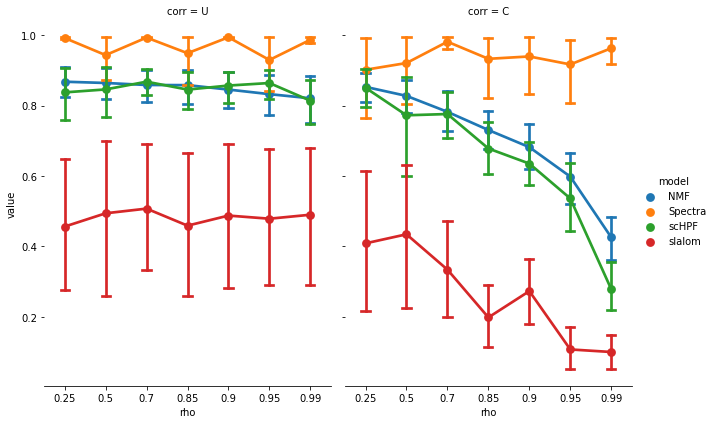

In [11]:
g = sns.catplot(x="rho", y="value", hue="model", col="corr",
                capsize=.2,  height=6, aspect=.75,
                kind="point", data=results_df2)
g.despine(left=True)
plt.savefig("simulation_correlated_factors.svg")

In [155]:
results_df2[(results_df2.rho == 0.25)&(results_df2.model == "NMF")]

,rho,model,corr,value
0,0.25,NMF,U,0.637732
1,0.25,NMF,C,0.646530
8,0.25,NMF,U,0.637732
9,0.25,NMF,C,0.646530
16,0.25,NMF,U,0.637732
17,0.25,NMF,C,0.646530
24,0.25,NMF,U,0.637732
25,0.25,NMF,C,0.646530
32,0.25,NMF,U,0.637732
33,0.25,NMF,C,0.646530


In [162]:
model.internal_model.weights.min()

tensor(0.)

## Same code for scHPF

## 

In [105]:
model = run_trials(scipy.sparse.coo_matrix(data), vcells=None, nfactors=k, 
                        ntrials=1, min_iter=20,
                        max_iter=1000, check_freq=10,
                        epsilon=0.001,
                        better_than_n_ago=5, dtype=np.float32,
                        verbose=True, model_kwargs=model_kwargs,
                        return_all=False, reproject=True,
                        batchsize=0,
                        beta_theta_simultaneous=True,
                        loss_smoothing=1
                        )

[Iter.    0]  loss:162.682297  pct:100.000000000
[Iter.   10]  loss:40.581615  pct:-75.054680151
[Iter.   20]  loss:28.153906  pct:-30.623989317
[Iter.   30]  loss:21.512732  pct:-23.588820491
[Iter.   40]  loss:16.980190  pct:-21.069110931
[Iter.   50]  loss:13.731272  pct:-19.133581428
[Iter.   60]  loss:11.348175  pct:-17.355251133
[Iter.   70]  loss:9.537597  pct:-15.954797476
[Iter.   80]  loss:8.132697  pct:-14.730121654
[Iter.   90]  loss:7.027909  pct:-13.584519529
[Iter.  100]  loss:6.153367  pct:-12.443846408
[Iter.  110]  loss:5.455604  pct:-11.339538795
[Iter.  120]  loss:4.897664  pct:-10.226916162
[Iter.  130]  loss:4.449148  pct:-9.157742394
[Iter.  140]  loss:4.087934  pct:-8.118715530
[Iter.  150]  loss:3.797028  pct:-7.116232086
[Iter.  160]  loss:3.561892  pct:-6.192628003
[Iter.  170]  loss:3.371762  pct:-5.337886941
[Iter.  180]  loss:3.218355  pct:-4.549753415
[Iter.  190]  loss:3.094132  pct:-3.859843423
[Iter.  200]  loss:2.994543  pct:-3.218621686
[Iter.  210] 

array([[2.40838942e-03, 5.35525939e-03, 1.04719661e-03],
       [1.43997046e-02, 4.71373838e-05, 4.63942455e-02],
       [2.01888923e-03, 5.20275874e-05, 9.77493818e-03],
       ...,
       [1.58313156e-03, 4.93269273e-05, 7.33240666e-04],
       [1.49959582e-03, 5.97432272e-05, 1.27868612e-03],
       [5.58313347e-05, 1.15564407e-02, 3.06465401e-03]])

In [120]:
model.beta.e_x

array([[2.40838942e-03, 5.35525939e-03, 1.04719661e-03],
       [1.43997046e-02, 4.71373838e-05, 4.63942455e-02],
       [2.01888923e-03, 5.20275874e-05, 9.77493818e-03],
       ...,
       [1.58313156e-03, 4.93269273e-05, 7.33240666e-04],
       [1.49959582e-03, 5.97432272e-05, 1.27868612e-03],
       [5.58313347e-05, 1.15564407e-02, 3.06465401e-03]])

In [136]:
data

array([[  7,   0,   5, ...,   2,   1,  44],
       [  6,   0,  14, ...,   2,   6,  50],
       [  3,   2,   8, ...,   0,   5,  23],
       ...,
       [  3,   0,   3, ...,   2,   4,  11],
       [  4,   0,   7, ...,   0,   0,  11],
       [ 14,   3,  29, ...,   4,   4, 115]])

In [138]:
I = create_mask(np.array(lst), G_input = k, D= p).T.astype(int)
terms = np.array(range(k)).astype(str)
FA = slalom.initFA(Y = data.astype(float), terms = terms, I = I, noise='gauss', 
    nHidden=0, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)

In [139]:
FA.train()

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900


In [22]:
Y_nmf.shape

(100, 3)

## Other settings

In [34]:
N = 100
k = 3
p = 500
sigma = 2.0
lam = 0.02
n_top = 20
rhos = []
models = []
corr_group = []
results = []
model_kwargs = dict(a=0.3, c=0.3)

for rho in [0.25,0.5,0.7, 0.85,0.9,0.95,0.99]:
    for trial in range(10):
        np.random.seed(trial)
        data, A_star,theta_star = simulate_corr_data(rho,N,k,p,sigma)
        A = construct_A_matrix_w(theta_star)
        nmf = NMF(n_components=k)
        Y_nmf = nmf.fit_transform(data)
        nmf_theta = nmf.components_/nmf.components_.sum(axis = 0, keepdims =True)
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        lst = []
        for i in range(k):
            lst.append(list(theta.argsort(axis = 0)[-1*n_top:,:][:,i]))
        

        model = spc.SPECTRA_Model(X = data, labels = None, L = k, adj_matrix = A, use_weights = False, lam = lam, delta=0.0,use_cell_types = False, kappa = 0.0, rho = 0.0)
        #initialize eta
        model.alpha = torch.log(torch.Tensor(Y_nmf) + 0.000000001)
        model.internal_model.theta = nn.Parameter(torch.log(torch.Tensor(nmf_theta.T) + 0.000001))
        model.internal_model.eta = nn.Parameter(torch.eye(k)*10)
        model.train(X = data)
        spectra_theta = torch.softmax(model.internal_model.theta, dim = 1).detach().numpy().T
        #spectra_theta = theta*(model.internal_model.gene_scaling.exp().detach()/(1.0 + model.internal_model.gene_scaling.exp().detach()) + model.internal_model.delta).numpy().reshape(1,-1)
        
        theta = theta_star/theta_star.sum(axis = 1, keepdims =True)
        
        
        model = run_trials(scipy.sparse.coo_matrix(data), vcells=None, nfactors=k, 
                        ntrials=1, min_iter=20,
                        max_iter=1000, check_freq=10,
                        epsilon=0.001,
                        better_than_n_ago=5, dtype=np.float32,
                        verbose=True, model_kwargs=model_kwargs,
                        return_all=False, reproject=True,
                        batchsize=0,
                        beta_theta_simultaneous=True,
                        loss_smoothing=1
                        )
        schpf_theta = model.beta.e_x.T / (model.beta.e_x.T.sum(axis = 0, keepdims = True))
        
        I = create_mask(np.array(lst), G_input = k, D= p).T.astype(int)
        terms = np.array(range(k)).astype(str)
        FA = slalom.initFA(Y = data.astype(float), terms = terms, I = I, noise='gauss', 
            nHidden=0, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)
        FA.train()
        temp = (FA.getW()*FA.getZ()).T
        slalom_theta = temp/temp.sum(axis = 0, keepdims = True)
        
        best_schpf = best_permutation(theta,schpf_theta)
        best_nmf = best_permutation(theta,nmf_theta)
        best_spade = best_permutation(theta,spectra_theta)
        best_slalom = best_permutation(theta, slalom_theta)
        
        nfactors = [np.corrcoef(nmf_theta[best_nmf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        sfactors = [np.corrcoef(spectra_theta[best_spade[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        hfactors = [np.corrcoef(schpf_theta[best_schpf[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        slfactors = [np.corrcoef(slalom_theta[best_slalom[0],:][i,:], theta[:,i])[0,1] for i in range(k)]
        
        #collect results
        results.append(np.mean(nfactors[2:]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(nfactors[0:2]))
        rhos.append(rho)
        models.append("NMF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(sfactors[2:]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(sfactors[0:2]))
        rhos.append(rho)
        models.append("Spectra")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(hfactors[2:]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(hfactors[0:2]))
        rhos.append(rho)
        models.append("scHPF")
        corr_group.append("C")
        
        #collect results
        results.append(np.mean(slfactors[2:]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("U")
        
        #collect results
        results.append(np.mean(slfactors[0:2]))
        rhos.append(rho)
        models.append("slalom")
        corr_group.append("C")

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 23%|██▎       | 2252/10000 [00:29<01:39, 77.54it/s]


[Iter.    0]  loss:468.482788  pct:100.000000000
[Iter.   10]  loss:80.517685  pct:-82.813093193
[Iter.   20]  loss:76.477486  pct:-5.017778744
[Iter.   30]  loss:72.764748  pct:-4.854681094
[Iter.   40]  loss:69.475121  pct:-4.520907696
[Iter.   50]  loss:66.728424  pct:-3.953496519
[Iter.   60]  loss:64.276558  pct:-3.674395408
[Iter.   70]  loss:62.033810  pct:-3.489216494
[Iter.   80]  loss:59.955269  pct:-3.350657993
[Iter.   90]  loss:58.029957  pct:-3.211247450
[Iter.  100]  loss:56.234745  pct:-3.093594913
[Iter.  110]  loss:54.552372  pct:-2.991696763
[Iter.  120]  loss:52.970615  pct:-2.899519369
[Iter.  130]  loss:51.479179  pct:-2.815591236
[Iter.  140]  loss:50.068848  pct:-2.739615788
[Iter.  150]  loss:48.732044  pct:-2.669930503
[Iter.  160]  loss:47.462189  pct:-2.605791568
[Iter.  170]  loss:46.253563  pct:-2.546502439
[Iter.  180]  loss:45.101135  pct:-2.491543571
[Iter.  190]  loss:44.000458  pct:-2.440465155
[Iter.  200]  loss:42.947647  pct:-2.392726627
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 11%|█         | 1081/10000 [00:17<02:24, 61.85it/s]


[Iter.    0]  loss:3938.545654  pct:100.000000000
[Iter.   10]  loss:580.299683  pct:-85.266146149
[Iter.   20]  loss:567.408203  pct:-2.221521031
[Iter.   30]  loss:560.970825  pct:-1.134523240
[Iter.   40]  loss:554.886597  pct:-1.084589116
[Iter.   50]  loss:549.048584  pct:-1.052109157
[Iter.   60]  loss:543.396484  pct:-1.029435240
[Iter.   70]  loss:537.901794  pct:-1.011175099
[Iter.   80]  loss:532.554810  pct:-0.994044809
[Iter.   90]  loss:527.354614  pct:-0.976461994
[Iter.  100]  loss:522.291199  pct:-0.960153830
[Iter.  110]  loss:517.354797  pct:-0.945143510
[Iter.  120]  loss:512.540100  pct:-0.930637406
[Iter.  130]  loss:507.841858  pct:-0.916658460
[Iter.  140]  loss:503.255127  pct:-0.903180958
[Iter.  150]  loss:498.774933  pct:-0.890243110
[Iter.  160]  loss:494.397186  pct:-0.877699799
[Iter.  170]  loss:490.117218  pct:-0.865694300
[Iter.  180]  loss:485.931305  pct:-0.854063667
[Iter.  190]  loss:481.835968  pct:-0.842781042
[Iter.  200]  loss:477.827271  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 23%|██▎       | 2334/10000 [00:51<02:48, 45.54it/s]


[Iter.    0]  loss:435.486115  pct:100.000000000
[Iter.   10]  loss:71.844780  pct:-83.502393026
[Iter.   20]  loss:67.575333  pct:-5.942599210
[Iter.   30]  loss:64.664230  pct:-4.307936315
[Iter.   40]  loss:62.045902  pct:-4.049113521
[Iter.   50]  loss:59.665844  pct:-3.835963701
[Iter.   60]  loss:57.485897  pct:-3.653592666
[Iter.   70]  loss:55.476601  pct:-3.495285835
[Iter.   80]  loss:53.614727  pct:-3.356142238
[Iter.   90]  loss:51.881588  pct:-3.232580178
[Iter.  100]  loss:50.261772  pct:-3.122140030
[Iter.  110]  loss:48.742481  pct:-3.022756379
[Iter.  120]  loss:47.312950  pct:-2.932823815
[Iter.  130]  loss:45.964123  pct:-2.850862942
[Iter.  140]  loss:44.688091  pct:-2.776146736
[Iter.  150]  loss:43.478191  pct:-2.707432490
[Iter.  160]  loss:42.328518  pct:-2.644253189
[Iter.  170]  loss:41.234093  pct:-2.585550488
[Iter.  180]  loss:40.190350  pct:-2.531262518
[Iter.  190]  loss:39.193375  pct:-2.480632678
[Iter.  200]  loss:38.239658  pct:-2.433360962
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 281/10000 [00:03<02:13, 72.67it/s]


[Iter.    0]  loss:5054.274902  pct:100.000000000
[Iter.   10]  loss:797.372559  pct:-84.223799180
[Iter.   20]  loss:786.297302  pct:-1.388968836
[Iter.   30]  loss:777.633179  pct:-1.101889007
[Iter.   40]  loss:769.340942  pct:-1.066342918
[Iter.   50]  loss:761.310669  pct:-1.043786051
[Iter.   60]  loss:753.525513  pct:-1.022599126
[Iter.   70]  loss:745.971863  pct:-1.002441162
[Iter.   80]  loss:738.636841  pct:-0.983284000
[Iter.   90]  loss:731.509155  pct:-0.964978343
[Iter.  100]  loss:724.578308  pct:-0.947472375
[Iter.  110]  loss:717.834229  pct:-0.930759245
[Iter.  120]  loss:711.268372  pct:-0.914675934
[Iter.  130]  loss:704.871948  pct:-0.899298155
[Iter.  140]  loss:698.636719  pct:-0.884590387
[Iter.  150]  loss:692.555664  pct:-0.870417275
[Iter.  160]  loss:686.621582  pct:-0.856838279
[Iter.  170]  loss:680.827881  pct:-0.843798291
[Iter.  180]  loss:675.168518  pct:-0.831247214
[Iter.  190]  loss:669.638062  pct:-0.819122396
[Iter.  200]  loss:664.230896  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:11<00:00, 76.11it/s]


[Iter.    0]  loss:323.579529  pct:100.000000000
[Iter.   10]  loss:69.557198  pct:-78.503834839
[Iter.   20]  loss:63.372360  pct:-8.891728760
[Iter.   30]  loss:58.870975  pct:-7.103072568
[Iter.   40]  loss:55.714100  pct:-5.362363344
[Iter.   50]  loss:52.969143  pct:-4.926862277
[Iter.   60]  loss:50.534214  pct:-4.596881807
[Iter.   70]  loss:48.347057  pct:-4.328071030
[Iter.   80]  loss:46.362324  pct:-4.105179696
[Iter.   90]  loss:44.547863  pct:-3.913653603
[Iter.  100]  loss:42.878765  pct:-3.746751893
[Iter.  110]  loss:41.334938  pct:-3.600446638
[Iter.  120]  loss:39.900307  pct:-3.470747545
[Iter.  130]  loss:38.561684  pct:-3.354919191
[Iter.  140]  loss:37.308167  pct:-3.250680551
[Iter.  150]  loss:36.130569  pct:-3.156405571
[Iter.  160]  loss:35.021076  pct:-3.070788178
[Iter.  170]  loss:33.972683  pct:-2.993606603
[Iter.  180]  loss:32.980549  pct:-2.920387818
[Iter.  190]  loss:32.039425  pct:-2.853572772
[Iter.  200]  loss:31.144943  pct:-2.791815589
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 15%|█▌        | 1523/10000 [00:24<02:16, 62.03it/s]


[Iter.    0]  loss:289.608032  pct:100.000000000
[Iter.   10]  loss:63.736629  pct:-77.992104428
[Iter.   20]  loss:56.787125  pct:-10.903470906
[Iter.   30]  loss:53.321926  pct:-6.102084829
[Iter.   40]  loss:50.365013  pct:-5.545397944
[Iter.   50]  loss:47.782478  pct:-5.127636488
[Iter.   60]  loss:45.493408  pct:-4.790605697
[Iter.   70]  loss:43.441120  pct:-4.511176754
[Iter.   80]  loss:41.584183  pct:-4.274607566
[Iter.   90]  loss:39.890919  pct:-4.071894398
[Iter.  100]  loss:38.336681  pct:-3.896218526
[Iter.  110]  loss:36.902073  pct:-3.742130013
[Iter.  120]  loss:35.571449  pct:-3.605823527
[Iter.  130]  loss:34.332031  pct:-3.484305686
[Iter.  140]  loss:33.173290  pct:-3.375101779
[Iter.  150]  loss:32.086414  pct:-3.276358502
[Iter.  160]  loss:31.063923  pct:-3.186680332
[Iter.  170]  loss:30.099497  pct:-3.104649868
[Iter.  180]  loss:29.187702  pct:-3.029268786
[Iter.  190]  loss:28.323807  pct:-2.959792487
[Iter.  200]  loss:27.503691  pct:-2.895500771
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 28%|██▊       | 2766/10000 [00:41<01:49, 66.14it/s]


[Iter.    0]  loss:612.848206  pct:100.000000000
[Iter.   10]  loss:103.584969  pct:-83.097778537
[Iter.   20]  loss:98.850464  pct:-4.570648392
[Iter.   30]  loss:94.482826  pct:-4.418429073
[Iter.   40]  loss:90.598518  pct:-4.111125816
[Iter.   50]  loss:87.329514  pct:-3.608232100
[Iter.   60]  loss:84.384987  pct:-3.371742900
[Iter.   70]  loss:81.668907  pct:-3.218676464
[Iter.   80]  loss:79.152779  pct:-3.080889199
[Iter.   90]  loss:76.810883  pct:-2.958703532
[Iter.  100]  loss:74.620689  pct:-2.851409986
[Iter.  110]  loss:72.563553  pct:-2.756791116
[Iter.  120]  loss:70.625015  pct:-2.671503146
[Iter.  130]  loss:68.793320  pct:-2.593550670
[Iter.  140]  loss:67.058189  pct:-2.522236632
[Iter.  150]  loss:65.410629  pct:-2.456911131
[Iter.  160]  loss:63.842812  pct:-2.396885193
[Iter.  170]  loss:62.348129  pct:-2.341191240
[Iter.  180]  loss:60.920555  pct:-2.289682424
[Iter.  190]  loss:59.554951  pct:-2.241615163
[Iter.  200]  loss:58.246677  pct:-2.196749892
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 10%|█         | 1023/10000 [00:16<02:20, 63.86it/s]


[Iter.    0]  loss:396.358063  pct:100.000000000
[Iter.   10]  loss:87.443855  pct:-77.938168571
[Iter.   20]  loss:80.092506  pct:-8.406935917
[Iter.   30]  loss:75.099693  pct:-6.233808048
[Iter.   40]  loss:71.114174  pct:-5.306971619
[Iter.   50]  loss:67.659187  pct:-4.858365616
[Iter.   60]  loss:64.611320  pct:-4.504734600
[Iter.   70]  loss:61.888542  pct:-4.214088645
[Iter.   80]  loss:59.426998  pct:-3.977382485
[Iter.   90]  loss:57.183571  pct:-3.775097762
[Iter.  100]  loss:55.123848  pct:-3.601948723
[Iter.  110]  loss:53.222260  pct:-3.449665635
[Iter.  120]  loss:51.457771  pct:-3.315320011
[Iter.  130]  loss:49.813057  pct:-3.196240945
[Iter.  140]  loss:48.274059  pct:-3.089546686
[Iter.  150]  loss:46.829025  pct:-2.993396553
[Iter.  160]  loss:45.468109  pct:-2.906138084
[Iter.  170]  loss:44.182930  pct:-2.826550659
[Iter.  180]  loss:42.966198  pct:-2.753850922
[Iter.  190]  loss:41.811771  pct:-2.686825061
[Iter.  200]  loss:40.714199  pct:-2.625031875
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 20%|█▉        | 1952/10000 [00:40<02:48, 47.82it/s]


[Iter.    0]  loss:597.464722  pct:100.000000000
[Iter.   10]  loss:103.905327  pct:-82.608959039
[Iter.   20]  loss:98.990074  pct:-4.730510778
[Iter.   30]  loss:95.030640  pct:-3.999829824
[Iter.   40]  loss:91.479317  pct:-3.737029394
[Iter.   50]  loss:88.256638  pct:-3.522850032
[Iter.   60]  loss:85.304710  pct:-3.344708417
[Iter.   70]  loss:82.581100  pct:-3.192801326
[Iter.   80]  loss:80.054321  pct:-3.059754787
[Iter.   90]  loss:77.699303  pct:-2.941775757
[Iter.  100]  loss:75.494057  pct:-2.838179875
[Iter.  110]  loss:73.423981  pct:-2.742038353
[Iter.  120]  loss:71.474464  pct:-2.655149282
[Iter.  130]  loss:69.632690  pct:-2.576827965
[Iter.  140]  loss:67.888199  pct:-2.505276712
[Iter.  150]  loss:66.231888  pct:-2.439762821
[Iter.  160]  loss:64.656036  pct:-2.379294162
[Iter.  170]  loss:63.153873  pct:-2.323314291
[Iter.  180]  loss:61.719372  pct:-2.271438900
[Iter.  190]  loss:60.347248  pct:-2.223165399
[Iter.  200]  loss:59.032787  pct:-2.178161882
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▌        | 1588/10000 [00:24<02:08, 65.31it/s]


[Iter.    0]  loss:994.014526  pct:100.000000000
[Iter.   10]  loss:174.040298  pct:-82.491173058
[Iter.   20]  loss:165.373169  pct:-4.979955558
[Iter.   30]  loss:159.623810  pct:-3.476597303
[Iter.   40]  loss:154.879364  pct:-2.972266986
[Iter.   50]  loss:150.539261  pct:-2.802247528
[Iter.   60]  loss:146.513153  pct:-2.674456992
[Iter.   70]  loss:142.754913  pct:-2.565121061
[Iter.   80]  loss:139.241043  pct:-2.461470612
[Iter.   90]  loss:135.939240  pct:-2.371286164
[Iter.  100]  loss:132.824371  pct:-2.291367949
[Iter.  110]  loss:129.870743  pct:-2.223709783
[Iter.  120]  loss:127.073151  pct:-2.154135799
[Iter.  130]  loss:124.414230  pct:-2.092432803
[Iter.  140]  loss:121.881142  pct:-2.036012020
[Iter.  150]  loss:119.463097  pct:-1.983936982
[Iter.  160]  loss:117.150650  pct:-1.935699525
[Iter.  170]  loss:114.935585  pct:-1.890783365
[Iter.  180]  loss:112.810425  pct:-1.849001088
[Iter.  190]  loss:110.768738  pct:-1.809838953
[Iter.  200]  loss:108.804718  pct:-1.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1839/10000 [00:29<02:10, 62.30it/s]


[Iter.    0]  loss:467.846680  pct:100.000000000
[Iter.   10]  loss:78.595139  pct:-83.200660126
[Iter.   20]  loss:74.369583  pct:-5.376357238
[Iter.   30]  loss:71.190269  pct:-4.275018799
[Iter.   40]  loss:68.342812  pct:-3.999785233
[Iter.   50]  loss:65.754066  pct:-3.787882086
[Iter.   60]  loss:63.382442  pct:-3.606809617
[Iter.   70]  loss:61.196266  pct:-3.449182794
[Iter.   80]  loss:59.170418  pct:-3.310411754
[Iter.   90]  loss:57.284515  pct:-3.187238616
[Iter.  100]  loss:55.521751  pct:-3.077208501
[Iter.  110]  loss:53.868198  pct:-2.978207580
[Iter.  120]  loss:52.312225  pct:-2.888481700
[Iter.  130]  loss:50.843861  pct:-2.806924588
[Iter.  140]  loss:49.454639  pct:-2.732328297
[Iter.  150]  loss:48.137226  pct:-2.663882186
[Iter.  160]  loss:46.885315  pct:-2.600713137
[Iter.  170]  loss:45.693302  pct:-2.542401151
[Iter.  180]  loss:44.556358  pct:-2.488206725
[Iter.  190]  loss:43.470150  pct:-2.437830164
[Iter.  200]  loss:42.430862  pct:-2.390807410
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  2%|▏         | 162/10000 [00:02<02:40, 61.45it/s]


[Iter.    0]  loss:3942.501709  pct:100.000000000
[Iter.   10]  loss:597.725464  pct:-84.838932589
[Iter.   20]  loss:589.133118  pct:-1.437507135
[Iter.   30]  loss:581.796631  pct:-1.245302054
[Iter.   40]  loss:573.364441  pct:-1.449336331
[Iter.   50]  loss:564.378052  pct:-1.567308420
[Iter.   60]  loss:557.574158  pct:-1.205556102
[Iter.   70]  loss:551.460754  pct:-1.096428741
[Iter.   80]  loss:545.680298  pct:-1.048208145
[Iter.   90]  loss:540.090698  pct:-1.024335977
[Iter.  100]  loss:534.657654  pct:-1.005950380
[Iter.  110]  loss:529.380066  pct:-0.987096669
[Iter.  120]  loss:524.248901  pct:-0.969278007
[Iter.  130]  loss:519.253235  pct:-0.952918831
[Iter.  140]  loss:514.388733  pct:-0.936826509
[Iter.  150]  loss:509.644470  pct:-0.922310772
[Iter.  160]  loss:505.013855  pct:-0.908597170
[Iter.  170]  loss:500.491852  pct:-0.895421607
[Iter.  180]  loss:496.073700  pct:-0.882761995
[Iter.  190]  loss:491.755493  pct:-0.870476864
[Iter.  200]  loss:487.532959  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:14<00:00, 74.23it/s]


[Iter.    0]  loss:444.185364  pct:100.000000000
[Iter.   10]  loss:72.587067  pct:-83.658383961
[Iter.   20]  loss:68.485580  pct:-5.650436635
[Iter.   30]  loss:65.571556  pct:-4.254945835
[Iter.   40]  loss:62.949562  pct:-3.998675912
[Iter.   50]  loss:60.562321  pct:-3.792308135
[Iter.   60]  loss:58.373043  pct:-3.614917036
[Iter.   70]  loss:56.353249  pct:-3.460149340
[Iter.   80]  loss:54.480221  pct:-3.323726401
[Iter.   90]  loss:52.735413  pct:-3.202645238
[Iter.  100]  loss:51.103714  pct:-3.094123148
[Iter.  110]  loss:49.572411  pct:-2.996462069
[Iter.  120]  loss:48.130836  pct:-2.908016939
[Iter.  130]  loss:46.769955  pct:-2.827463441
[Iter.  140]  loss:45.482018  pct:-2.753770392
[Iter.  150]  loss:44.260326  pct:-2.686097052
[Iter.  160]  loss:43.099079  pct:-2.623675305
[Iter.  170]  loss:41.993176  pct:-2.565956507
[Iter.  180]  loss:40.938179  pct:-2.512304625
[Iter.  190]  loss:39.930138  pct:-2.462350320
[Iter.  200]  loss:38.965538  pct:-2.415718218
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 313/10000 [00:04<02:08, 75.22it/s]


[Iter.    0]  loss:5221.142578  pct:100.000000000
[Iter.   10]  loss:843.953857  pct:-83.835834993
[Iter.   20]  loss:831.200012  pct:-1.511201721
[Iter.   30]  loss:821.600464  pct:-1.154902334
[Iter.   40]  loss:812.605591  pct:-1.094798925
[Iter.   50]  loss:803.912964  pct:-1.069722760
[Iter.   60]  loss:795.488159  pct:-1.047974727
[Iter.   70]  loss:787.316040  pct:-1.027308709
[Iter.   80]  loss:779.385681  pct:-1.007264997
[Iter.   90]  loss:771.686340  pct:-0.987873014
[Iter.  100]  loss:764.207947  pct:-0.969097568
[Iter.  110]  loss:756.940918  pct:-0.950922957
[Iter.  120]  loss:749.876831  pct:-0.933241518
[Iter.  130]  loss:743.008301  pct:-0.915954459
[Iter.  140]  loss:736.327637  pct:-0.899137204
[Iter.  150]  loss:729.826111  pct:-0.882966434
[Iter.  160]  loss:723.495422  pct:-0.867424224
[Iter.  170]  loss:717.326599  pct:-0.852641641
[Iter.  180]  loss:711.309998  pct:-0.838753445
[Iter.  190]  loss:705.435913  pct:-0.825812162
[Iter.  200]  loss:699.696838  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1654/10000 [00:33<02:47, 49.87it/s]


[Iter.    0]  loss:326.811188  pct:100.000000000
[Iter.   10]  loss:67.408768  pct:-79.373783552
[Iter.   20]  loss:61.926617  pct:-8.132697301
[Iter.   30]  loss:58.395657  pct:-5.701845625
[Iter.   40]  loss:55.342773  pct:-5.227928457
[Iter.   50]  loss:52.655178  pct:-4.856271561
[Iter.   60]  loss:50.258350  pct:-4.551931615
[Iter.   70]  loss:48.098644  pct:-4.297208523
[Iter.   80]  loss:46.136063  pct:-4.080326306
[Iter.   90]  loss:44.339825  pct:-3.893349028
[Iter.  100]  loss:42.685810  pct:-3.730313774
[Iter.  110]  loss:41.154762  pct:-3.586784034
[Iter.  120]  loss:39.731087  pct:-3.459321494
[Iter.  130]  loss:38.401974  pct:-3.345272219
[Iter.  140]  loss:37.156754  pct:-3.242594230
[Iter.  150]  loss:35.986462  pct:-3.149607512
[Iter.  160]  loss:34.883572  pct:-3.064735916
[Iter.  170]  loss:33.841526  pct:-2.987210153
[Iter.  180]  loss:32.854710  pct:-2.915992634
[Iter.  190]  loss:31.918324  pct:-2.850081827
[Iter.  200]  loss:31.028091  pct:-2.789094126
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 14%|█▍        | 1436/10000 [00:32<03:13, 44.18it/s]


[Iter.    0]  loss:287.516083  pct:100.000000000
[Iter.   10]  loss:61.042091  pct:-78.769158527
[Iter.   20]  loss:55.725677  pct:-8.709422892
[Iter.   30]  loss:52.357677  pct:-6.043892479
[Iter.   40]  loss:49.468521  pct:-5.518114022
[Iter.   50]  loss:46.940239  pct:-5.110890943
[Iter.   60]  loss:44.696663  pct:-4.779643436
[Iter.   70]  loss:42.683464  pct:-4.504136823
[Iter.   80]  loss:40.860439  pct:-4.271032800
[Iter.   90]  loss:39.196941  pct:-4.071169946
[Iter.  100]  loss:37.669239  pct:-3.897503933
[Iter.  110]  loss:36.258469  pct:-3.745152416
[Iter.  120]  loss:34.949478  pct:-3.610164820
[Iter.  130]  loss:33.729862  pct:-3.489654212
[Iter.  140]  loss:32.589333  pct:-3.381364636
[Iter.  150]  loss:31.519306  pct:-3.283363951
[Iter.  160]  loss:30.512524  pct:-3.194177327
[Iter.  170]  loss:29.562780  pct:-3.112634280
[Iter.  180]  loss:28.664753  pct:-3.037696078
[Iter.  190]  loss:27.813778  pct:-2.968715753
[Iter.  200]  loss:27.005873  pct:-2.904694211
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  5%|▍         | 454/10000 [00:10<03:45, 42.39it/s]


[Iter.    0]  loss:621.930115  pct:100.000000000
[Iter.   10]  loss:96.056084  pct:-84.555163188
[Iter.   20]  loss:92.245384  pct:-3.967160972
[Iter.   30]  loss:88.988098  pct:-3.531110092
[Iter.   40]  loss:85.991409  pct:-3.367516449
[Iter.   50]  loss:83.145363  pct:-3.309686945
[Iter.   60]  loss:80.322937  pct:-3.394567954
[Iter.   70]  loss:77.722870  pct:-3.237017016
[Iter.   80]  loss:75.399033  pct:-2.989901536
[Iter.   90]  loss:73.273987  pct:-2.818399260
[Iter.  100]  loss:71.292213  pct:-2.704607000
[Iter.  110]  loss:69.426674  pct:-2.616750779
[Iter.  120]  loss:67.663956  pct:-2.538963920
[Iter.  130]  loss:65.991150  pct:-2.472225824
[Iter.  140]  loss:64.399734  pct:-2.411558834
[Iter.  150]  loss:62.883583  pct:-2.354282110
[Iter.  160]  loss:61.436329  pct:-2.301481739
[Iter.  170]  loss:60.052330  pct:-2.252736933
[Iter.  180]  loss:58.726749  pct:-2.207375795
[Iter.  190]  loss:57.455284  pct:-2.165053088
[Iter.  200]  loss:56.234276  pct:-2.125145353
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  8%|▊         | 764/10000 [00:10<02:02, 75.29it/s]


[Iter.    0]  loss:397.841797  pct:100.000000000
[Iter.   10]  loss:87.146408  pct:-78.095206682
[Iter.   20]  loss:80.667480  pct:-7.434532019
[Iter.   30]  loss:75.624352  pct:-6.251749699
[Iter.   40]  loss:71.635498  pct:-5.274562195
[Iter.   50]  loss:68.164482  pct:-4.845385353
[Iter.   60]  loss:65.095009  pct:-4.503039077
[Iter.   70]  loss:62.347115  pct:-4.221359419
[Iter.   80]  loss:59.862728  pct:-3.984765713
[Iter.   90]  loss:57.598255  pct:-3.782776082
[Iter.  100]  loss:55.520042  pct:-3.608117524
[Iter.  110]  loss:53.601543  pct:-3.455507073
[Iter.  120]  loss:51.821507  pct:-3.320868789
[Iter.  130]  loss:50.162640  pct:-3.201116668
[Iter.  140]  loss:48.610703  pct:-3.093810683
[Iter.  150]  loss:47.153790  pct:-2.997103352
[Iter.  160]  loss:45.781914  pct:-2.909364819
[Iter.  170]  loss:44.486492  pct:-2.829548820
[Iter.  180]  loss:43.260292  pct:-2.756342531
[Iter.  190]  loss:42.097031  pct:-2.688981878
[Iter.  200]  loss:40.991142  pct:-2.626998508
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1837/10000 [00:24<01:47, 76.05it/s]


[Iter.    0]  loss:617.110352  pct:100.000000000
[Iter.   10]  loss:105.194870  pct:-82.953634632
[Iter.   20]  loss:99.179482  pct:-5.718328745
[Iter.   30]  loss:95.355515  pct:-3.855602915
[Iter.   40]  loss:91.908058  pct:-3.615371777
[Iter.   50]  loss:88.763077  pct:-3.421877741
[Iter.   60]  loss:85.875603  pct:-3.253012587
[Iter.   70]  loss:83.205742  pct:-3.108986435
[Iter.   80]  loss:80.723351  pct:-2.983437562
[Iter.   90]  loss:78.404945  pct:-2.872037813
[Iter.  100]  loss:76.231247  pct:-2.772399643
[Iter.  110]  loss:74.186440  pct:-2.682374375
[Iter.  120]  loss:72.257072  pct:-2.600700449
[Iter.  130]  loss:70.431183  pct:-2.526935462
[Iter.  140]  loss:68.697968  pct:-2.460863586
[Iter.  150]  loss:67.052200  pct:-2.395656336
[Iter.  160]  loss:65.484879  pct:-2.337465094
[Iter.  170]  loss:63.989407  pct:-2.283690506
[Iter.  180]  loss:62.559933  pct:-2.233922696
[Iter.  190]  loss:61.191410  pct:-2.187538549
[Iter.  200]  loss:59.879444  pct:-2.144036133
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 25%|██▍       | 2467/10000 [00:47<02:25, 51.80it/s]


[Iter.    0]  loss:996.585876  pct:100.000000000
[Iter.   10]  loss:163.335266  pct:-83.610517671
[Iter.   20]  loss:157.547577  pct:-3.543441258
[Iter.   30]  loss:152.967133  pct:-2.907340389
[Iter.   40]  loss:148.750961  pct:-2.756259592
[Iter.   50]  loss:144.831116  pct:-2.635173277
[Iter.   60]  loss:141.167374  pct:-2.529665015
[Iter.   70]  loss:137.729095  pct:-2.435603999
[Iter.   80]  loss:134.490891  pct:-2.351140799
[Iter.   90]  loss:131.433380  pct:-2.273395889
[Iter.  100]  loss:128.539215  pct:-2.202001528
[Iter.  110]  loss:125.792351  pct:-2.136985446
[Iter.  120]  loss:123.179146  pct:-2.077395756
[Iter.  130]  loss:120.687950  pct:-2.022416751
[Iter.  140]  loss:118.308464  pct:-1.971602038
[Iter.  150]  loss:116.031654  pct:-1.924468981
[Iter.  160]  loss:113.849594  pct:-1.880573240
[Iter.  170]  loss:111.755348  pct:-1.839484740
[Iter.  180]  loss:109.742508  pct:-1.801113149
[Iter.  190]  loss:107.805511  pct:-1.765037538
[Iter.  200]  loss:105.939178  pct:-1.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 23%|██▎       | 2312/10000 [00:33<01:50, 69.88it/s]


[Iter.    0]  loss:466.103638  pct:100.000000000
[Iter.   10]  loss:80.402718  pct:-82.750035945
[Iter.   20]  loss:75.959023  pct:-5.526797105
[Iter.   30]  loss:72.462555  pct:-4.603097136
[Iter.   40]  loss:69.480896  pct:-4.114758220
[Iter.   50]  loss:66.783875  pct:-3.881673438
[Iter.   60]  loss:64.320763  pct:-3.688183555
[Iter.   70]  loss:62.056049  pct:-3.520967716
[Iter.   80]  loss:59.962048  pct:-3.374371704
[Iter.   90]  loss:58.016487  pct:-3.244653133
[Iter.  100]  loss:56.201187  pct:-3.128938131
[Iter.  110]  loss:54.501034  pct:-3.025119998
[Iter.  120]  loss:52.903400  pct:-2.931381757
[Iter.  130]  loss:51.397564  pct:-2.846388842
[Iter.  140]  loss:49.974430  pct:-2.768874128
[Iter.  150]  loss:48.626221  pct:-2.697798412
[Iter.  160]  loss:47.346165  pct:-2.632439826
[Iter.  170]  loss:46.128418  pct:-2.572007136
[Iter.  180]  loss:44.967758  pct:-2.516149136
[Iter.  190]  loss:43.859695  pct:-2.464127164
[Iter.  200]  loss:42.800186  pct:-2.415678602
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1692/10000 [00:26<02:12, 62.70it/s]


[Iter.    0]  loss:3936.020264  pct:100.000000000
[Iter.   10]  loss:631.205933  pct:-83.963349570
[Iter.   20]  loss:618.082458  pct:-2.079111340
[Iter.   30]  loss:608.912109  pct:-1.483677298
[Iter.   40]  loss:601.257996  pct:-1.257014543
[Iter.   50]  loss:593.978394  pct:-1.210728523
[Iter.   60]  loss:586.954834  pct:-1.182460447
[Iter.   70]  loss:580.164978  pct:-1.156793600
[Iter.   80]  loss:573.595337  pct:-1.132374646
[Iter.   90]  loss:567.230957  pct:-1.109559209
[Iter.  100]  loss:561.061951  pct:-1.087565175
[Iter.  110]  loss:555.080811  pct:-1.066039165
[Iter.  120]  loss:549.274292  pct:-1.046067247
[Iter.  130]  loss:543.632263  pct:-1.027178750
[Iter.  140]  loss:538.146362  pct:-1.009119813
[Iter.  150]  loss:532.808838  pct:-0.991835082
[Iter.  160]  loss:527.612061  pct:-0.975354944
[Iter.  170]  loss:522.549744  pct:-0.959477099
[Iter.  180]  loss:517.615601  pct:-0.944243706
[Iter.  190]  loss:512.803589  pct:-0.929649669
[Iter.  200]  loss:508.108337  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:39<00:00, 62.83it/s]


[Iter.    0]  loss:451.455414  pct:100.000000000
[Iter.   10]  loss:74.224220  pct:-83.558905182
[Iter.   20]  loss:70.471664  pct:-5.055702617
[Iter.   30]  loss:67.128281  pct:-4.744295195
[Iter.   40]  loss:64.427795  pct:-4.022872631
[Iter.   50]  loss:61.981934  pct:-3.796283577
[Iter.   60]  loss:59.741470  pct:-3.614703716
[Iter.   70]  loss:57.675579  pct:-3.458052261
[Iter.   80]  loss:55.760487  pct:-3.320456420
[Iter.   90]  loss:53.976925  pct:-3.198612163
[Iter.  100]  loss:52.309315  pct:-3.089487168
[Iter.  110]  loss:50.744568  pct:-2.991335032
[Iter.  120]  loss:49.271751  pct:-2.902412079
[Iter.  130]  loss:47.881557  pct:-2.821482695
[Iter.  140]  loss:46.566032  pct:-2.747456692
[Iter.  150]  loss:45.318222  pct:-2.679657895
[Iter.  160]  loss:44.132267  pct:-2.616949638
[Iter.  170]  loss:43.002914  pct:-2.559017804
[Iter.  180]  loss:41.925591  pct:-2.505234652
[Iter.  190]  loss:40.896248  pct:-2.455165541
[Iter.  200]  loss:39.911293  pct:-2.408423475
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 10%|█         | 1046/10000 [00:25<03:35, 41.50it/s]


[Iter.    0]  loss:5387.118164  pct:100.000000000
[Iter.   10]  loss:764.223816  pct:-85.813869131
[Iter.   20]  loss:754.595215  pct:-1.259919002
[Iter.   30]  loss:747.276672  pct:-0.969863357
[Iter.   40]  loss:740.792664  pct:-0.867685160
[Iter.   50]  loss:734.522339  pct:-0.846434504
[Iter.   60]  loss:728.397827  pct:-0.833808775
[Iter.   70]  loss:722.407166  pct:-0.822443642
[Iter.   80]  loss:716.543335  pct:-0.811707143
[Iter.   90]  loss:710.800598  pct:-0.801450036
[Iter.  100]  loss:705.174133  pct:-0.791567264
[Iter.  110]  loss:699.660278  pct:-0.781913959
[Iter.  120]  loss:694.256592  pct:-0.772330042
[Iter.  130]  loss:688.964355  pct:-0.762288236
[Iter.  140]  loss:683.784729  pct:-0.751798903
[Iter.  150]  loss:678.716553  pct:-0.741194714
[Iter.  160]  loss:673.756470  pct:-0.730803306
[Iter.  170]  loss:668.898926  pct:-0.720964349
[Iter.  180]  loss:664.139221  pct:-0.711573065
[Iter.  190]  loss:659.471680  pct:-0.702795642
[Iter.  200]  loss:654.892212  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 324/10000 [00:06<03:11, 50.61it/s]


[Iter.    0]  loss:328.046021  pct:100.000000000
[Iter.   10]  loss:68.268723  pct:-79.189280307
[Iter.   20]  loss:61.776627  pct:-9.509619788
[Iter.   30]  loss:57.905392  pct:-6.266504190
[Iter.   40]  loss:54.861473  pct:-5.256710162
[Iter.   50]  loss:52.209885  pct:-4.833243241
[Iter.   60]  loss:49.846298  pct:-4.527086091
[Iter.   70]  loss:47.715191  pct:-4.275357261
[Iter.   80]  loss:45.777233  pct:-4.061511078
[Iter.   90]  loss:44.002228  pct:-3.877484984
[Iter.  100]  loss:42.366695  pct:-3.716930850
[Iter.  110]  loss:40.851845  pct:-3.575569447
[Iter.  120]  loss:39.442497  pct:-3.449899366
[Iter.  130]  loss:38.126217  pct:-3.337213556
[Iter.  140]  loss:36.892521  pct:-3.235820610
[Iter.  150]  loss:35.732735  pct:-3.143689279
[Iter.  160]  loss:34.639385  pct:-3.059797876
[Iter.  170]  loss:33.606098  pct:-2.982983219
[Iter.  180]  loss:32.627346  pct:-2.912424201
[Iter.  190]  loss:31.698385  pct:-2.847184687
[Iter.  200]  loss:30.815042  pct:-2.786712119
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [02:14<00:00, 74.38it/s]


[Iter.    0]  loss:285.238281  pct:100.000000000
[Iter.   10]  loss:61.866894  pct:-78.310450718
[Iter.   20]  loss:55.066326  pct:-10.992256460
[Iter.   30]  loss:51.687778  pct:-6.135415063
[Iter.   40]  loss:48.827995  pct:-5.532803415
[Iter.   50]  loss:46.326950  pct:-5.122154231
[Iter.   60]  loss:44.107121  pct:-4.791659187
[Iter.   70]  loss:42.114929  pct:-4.516711342
[Iter.   80]  loss:40.310802  pct:-4.283817577
[Iter.   90]  loss:38.664528  pct:-4.083953844
[Iter.  100]  loss:37.152592  pct:-3.910396092
[Iter.  110]  loss:35.756363  pct:-3.758092575
[Iter.  120]  loss:34.460808  pct:-3.623285505
[Iter.  130]  loss:33.253712  pct:-3.502808486
[Iter.  140]  loss:32.124886  pct:-3.394586901
[Iter.  150]  loss:31.065886  pct:-3.296509845
[Iter.  160]  loss:30.069500  pct:-3.207330346
[Iter.  170]  loss:29.129610  pct:-3.125725099
[Iter.  180]  loss:28.240921  pct:-3.050809947
[Iter.  190]  loss:27.398897  pct:-2.981573614
[Iter.  200]  loss:26.599508  pct:-2.917595115
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1678/10000 [00:25<02:06, 65.81it/s]


[Iter.    0]  loss:621.128906  pct:100.000000000
[Iter.   10]  loss:103.227020  pct:-83.380736311
[Iter.   20]  loss:98.861771  pct:-4.228785857
[Iter.   30]  loss:94.881378  pct:-4.026220075
[Iter.   40]  loss:91.202415  pct:-3.877433885
[Iter.   50]  loss:87.941063  pct:-3.575949740
[Iter.   60]  loss:84.994247  pct:-3.350898195
[Iter.   70]  loss:82.281639  pct:-3.191519920
[Iter.   80]  loss:79.764275  pct:-3.059448656
[Iter.   90]  loss:77.417107  pct:-2.942630621
[Iter.  100]  loss:75.219482  pct:-2.838680367
[Iter.  110]  loss:73.154663  pct:-2.745059218
[Iter.  120]  loss:71.208336  pct:-2.660564792
[Iter.  130]  loss:69.368500  pct:-2.583736999
[Iter.  140]  loss:67.624855  pct:-2.513597267
[Iter.  150]  loss:65.968773  pct:-2.448925254
[Iter.  160]  loss:64.392555  pct:-2.389339050
[Iter.  170]  loss:62.889542  pct:-2.334141898
[Iter.  180]  loss:61.453728  pct:-2.283072617
[Iter.  190]  loss:60.079983  pct:-2.235413563
[Iter.  200]  loss:58.763760  pct:-2.190784824
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  9%|▉         | 925/10000 [00:15<02:27, 61.63it/s]


[Iter.    0]  loss:402.504456  pct:100.000000000
[Iter.   10]  loss:83.282639  pct:-79.308886484
[Iter.   20]  loss:77.555214  pct:-6.877093139
[Iter.   30]  loss:73.299614  pct:-5.487187463
[Iter.   40]  loss:69.636307  pct:-4.997716894
[Iter.   50]  loss:66.415749  pct:-4.624826210
[Iter.   60]  loss:63.545452  pct:-4.321710647
[Iter.   70]  loss:60.959602  pct:-4.069291626
[Iter.   80]  loss:58.609596  pct:-3.855022035
[Iter.   90]  loss:56.458214  pct:-3.670699994
[Iter.  100]  loss:54.476398  pct:-3.510233861
[Iter.  110]  loss:52.641018  pct:-3.369129762
[Iter.  120]  loss:50.933315  pct:-3.244053220
[Iter.  130]  loss:49.337967  pct:-3.132229562
[Iter.  140]  loss:47.842152  pct:-3.031773238
[Iter.  150]  loss:46.435215  pct:-2.940788817
[Iter.  160]  loss:45.108074  pct:-2.858048161
[Iter.  170]  loss:43.852993  pct:-2.782386966
[Iter.  180]  loss:42.663216  pct:-2.713104152
[Iter.  190]  loss:41.533039  pct:-2.649065541
[Iter.  200]  loss:40.457348  pct:-2.589965114
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 21%|██        | 2063/10000 [00:37<02:25, 54.63it/s]


[Iter.    0]  loss:638.273987  pct:100.000000000
[Iter.   10]  loss:103.758293  pct:-83.743924565
[Iter.   20]  loss:98.840317  pct:-4.739839323
[Iter.   30]  loss:93.107559  pct:-5.800019421
[Iter.   40]  loss:89.770073  pct:-3.584549198
[Iter.   50]  loss:86.891594  pct:-3.206501799
[Iter.   60]  loss:84.238350  pct:-3.053510585
[Iter.   70]  loss:81.769554  pct:-2.930726657
[Iter.   80]  loss:79.461876  pct:-2.822172931
[Iter.   90]  loss:77.296036  pct:-2.725634304
[Iter.  100]  loss:75.256096  pct:-2.639126134
[Iter.  110]  loss:73.329727  pct:-2.559751062
[Iter.  120]  loss:71.505859  pct:-2.487214760
[Iter.  130]  loss:69.774544  pct:-2.421222020
[Iter.  140]  loss:68.127525  pct:-2.360486137
[Iter.  150]  loss:66.557571  pct:-2.304434090
[Iter.  160]  loss:65.058441  pct:-2.252381235
[Iter.  170]  loss:63.624577  pct:-2.203963956
[Iter.  180]  loss:62.251064  pct:-2.158776281
[Iter.  190]  loss:60.933514  pct:-2.116511057
[Iter.  200]  loss:59.667973  pct:-2.076921223
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  6%|▋         | 642/10000 [00:09<02:21, 66.22it/s]


[Iter.    0]  loss:996.061768  pct:100.000000000
[Iter.   10]  loss:166.425308  pct:-83.291669414
[Iter.   20]  loss:158.490158  pct:-4.767994863
[Iter.   30]  loss:153.396713  pct:-3.213729411
[Iter.   40]  loss:148.976425  pct:-2.881605474
[Iter.   50]  loss:144.959732  pct:-2.696193784
[Iter.   60]  loss:141.249710  pct:-2.559346599
[Iter.   70]  loss:137.782013  pct:-2.455011866
[Iter.   80]  loss:134.509338  pct:-2.375255297
[Iter.   90]  loss:131.437485  pct:-2.283747489
[Iter.  100]  loss:128.528229  pct:-2.213414223
[Iter.  110]  loss:125.766403  pct:-2.148808544
[Iter.  120]  loss:123.138039  pct:-2.089878136
[Iter.  130]  loss:120.637032  pct:-2.031059702
[Iter.  140]  loss:118.248589  pct:-1.979858889
[Iter.  150]  loss:115.965813  pct:-1.930488902
[Iter.  160]  loss:113.778946  pct:-1.885785741
[Iter.  170]  loss:111.676331  pct:-1.847982805
[Iter.  180]  loss:109.657089  pct:-1.808119342
[Iter.  190]  loss:107.715370  pct:-1.770719129
[Iter.  200]  loss:105.845161  pct:-1.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 23%|██▎       | 2300/10000 [00:35<01:57, 65.67it/s]


[Iter.    0]  loss:465.897156  pct:100.000000000
[Iter.   10]  loss:77.999336  pct:-83.258251816
[Iter.   20]  loss:74.208252  pct:-4.860405834
[Iter.   30]  loss:70.965576  pct:-4.369697030
[Iter.   40]  loss:68.032890  pct:-4.132547089
[Iter.   50]  loss:65.414314  pct:-3.848985450
[Iter.   60]  loss:63.033287  pct:-3.639917728
[Iter.   70]  loss:60.845383  pct:-3.471030086
[Iter.   80]  loss:58.821041  pct:-3.327025805
[Iter.   90]  loss:56.937977  pct:-3.201344680
[Iter.  100]  loss:55.178486  pct:-3.090188771
[Iter.  110]  loss:53.528255  pct:-2.990713467
[Iter.  120]  loss:51.975582  pct:-2.900661205
[Iter.  130]  loss:50.510494  pct:-2.818800350
[Iter.  140]  loss:49.124454  pct:-2.744062902
[Iter.  150]  loss:47.810150  pct:-2.675458415
[Iter.  160]  loss:46.561249  pct:-2.612209674
[Iter.  170]  loss:45.372192  pct:-2.553746791
[Iter.  180]  loss:44.238159  pct:-2.499401381
[Iter.  190]  loss:43.154804  pct:-2.448915077
[Iter.  200]  loss:42.118343  pct:-2.401727675
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 260/10000 [00:03<02:05, 77.77it/s]


[Iter.    0]  loss:3981.084473  pct:100.000000000
[Iter.   10]  loss:620.956726  pct:-84.402320740
[Iter.   20]  loss:608.441467  pct:-2.015480027
[Iter.   30]  loss:600.297180  pct:-1.338548989
[Iter.   40]  loss:592.528931  pct:-1.294067300
[Iter.   50]  loss:585.227661  pct:-1.232221610
[Iter.   60]  loss:578.380371  pct:-1.170021599
[Iter.   70]  loss:571.876831  pct:-1.124439964
[Iter.   80]  loss:565.614441  pct:-1.095059250
[Iter.   90]  loss:559.555176  pct:-1.071271293
[Iter.  100]  loss:553.676208  pct:-1.050650148
[Iter.  110]  loss:547.965210  pct:-1.031469015
[Iter.  120]  loss:542.413452  pct:-1.013158812
[Iter.  130]  loss:537.013000  pct:-0.995633799
[Iter.  140]  loss:531.756836  pct:-0.978777897
[Iter.  150]  loss:526.637939  pct:-0.962638586
[Iter.  160]  loss:521.650146  pct:-0.947100958
[Iter.  170]  loss:516.786926  pct:-0.932276210
[Iter.  180]  loss:512.042664  pct:-0.918030711
[Iter.  190]  loss:507.412415  pct:-0.904270162
[Iter.  200]  loss:502.890503  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 24%|██▍       | 2415/10000 [00:37<01:57, 64.72it/s]


[Iter.    0]  loss:457.632050  pct:100.000000000
[Iter.   10]  loss:76.510643  pct:-83.281186117
[Iter.   20]  loss:71.749794  pct:-6.222466329
[Iter.   30]  loss:68.513634  pct:-4.510340863
[Iter.   40]  loss:65.751411  pct:-4.031638872
[Iter.   50]  loss:63.251255  pct:-3.802437618
[Iter.   60]  loss:60.961910  pct:-3.619445632
[Iter.   70]  loss:58.851814  pct:-3.461335068
[Iter.   80]  loss:56.896492  pct:-3.322450276
[Iter.   90]  loss:55.076214  pct:-3.199280138
[Iter.  100]  loss:53.374752  pct:-3.089286052
[Iter.  110]  loss:51.778713  pct:-2.990250553
[Iter.  120]  loss:50.276768  pct:-2.900700697
[Iter.  130]  loss:48.859364  pct:-2.819203061
[Iter.  140]  loss:47.518288  pct:-2.744767430
[Iter.  150]  loss:46.246502  pct:-2.676413227
[Iter.  160]  loss:45.037914  pct:-2.613360138
[Iter.  170]  loss:43.887135  pct:-2.555135473
[Iter.  180]  loss:42.789505  pct:-2.501028054
[Iter.  190]  loss:41.740841  pct:-2.450750699
[Iter.  200]  loss:40.737511  pct:-2.403713506
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 10%|█         | 1050/10000 [00:25<03:35, 41.44it/s]


[Iter.    0]  loss:5345.810059  pct:100.000000000
[Iter.   10]  loss:889.733093  pct:-83.356443637
[Iter.   20]  loss:877.541138  pct:-1.370293592
[Iter.   30]  loss:866.088745  pct:-1.305054782
[Iter.   40]  loss:856.119934  pct:-1.151014961
[Iter.   50]  loss:846.825684  pct:-1.085624819
[Iter.   60]  loss:837.882263  pct:-1.056111143
[Iter.   70]  loss:829.227051  pct:-1.032986707
[Iter.   80]  loss:820.837463  pct:-1.011735856
[Iter.   90]  loss:812.697266  pct:-0.991694229
[Iter.  100]  loss:804.790649  pct:-0.972885790
[Iter.  110]  loss:797.103638  pct:-0.955156689
[Iter.  120]  loss:789.622192  pct:-0.938578744
[Iter.  130]  loss:782.333435  pct:-0.923068956
[Iter.  140]  loss:775.225525  pct:-0.908552522
[Iter.  150]  loss:768.288818  pct:-0.894798523
[Iter.  160]  loss:761.517700  pct:-0.881324575
[Iter.  170]  loss:754.910706  pct:-0.867608806
[Iter.  180]  loss:748.465515  pct:-0.853768582
[Iter.  190]  loss:742.179382  pct:-0.839869398
[Iter.  200]  loss:736.047058  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 80%|████████  | 8000/10000 [02:19<00:34, 57.42it/s]


[Iter.    0]  loss:330.911285  pct:100.000000000
[Iter.   10]  loss:64.196182  pct:-80.600178857
[Iter.   20]  loss:60.039036  pct:-6.475691090
[Iter.   30]  loss:56.734020  pct:-5.504777883
[Iter.   40]  loss:53.826805  pct:-5.124288930
[Iter.   50]  loss:51.243595  pct:-4.799114467
[Iter.   60]  loss:48.937717  pct:-4.499835892
[Iter.   70]  loss:46.870201  pct:-4.224791092
[Iter.   80]  loss:44.991364  pct:-4.008597234
[Iter.   90]  loss:43.272366  pct:-3.820728737
[Iter.  100]  loss:41.688904  pct:-3.659290960
[Iter.  110]  loss:40.221035  pct:-3.521006001
[Iter.  120]  loss:38.853363  pct:-3.400389787
[Iter.  130]  loss:37.574055  pct:-3.292657878
[Iter.  140]  loss:36.373390  pct:-3.195461680
[Iter.  150]  loss:35.243282  pct:-3.106963287
[Iter.  160]  loss:34.176735  pct:-3.026243084
[Iter.  170]  loss:33.167747  pct:-2.952263957
[Iter.  180]  loss:32.211155  pct:-2.884104686
[Iter.  190]  loss:31.302443  pct:-2.821110851
[Iter.  200]  loss:30.437658  pct:-2.762673358
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1757/10000 [00:43<03:22, 40.61it/s]


[Iter.    0]  loss:282.357819  pct:100.000000000
[Iter.   10]  loss:61.400108  pct:-78.254501232
[Iter.   20]  loss:55.526020  pct:-9.566902154
[Iter.   30]  loss:51.912758  pct:-6.507331470
[Iter.   40]  loss:48.961044  pct:-5.685911677
[Iter.   50]  loss:46.405090  pct:-5.220382889
[Iter.   60]  loss:44.144295  pct:-4.871869825
[Iter.   70]  loss:42.120018  pct:-4.585590834
[Iter.   80]  loss:40.290077  pct:-4.344586927
[Iter.   90]  loss:38.622841  pct:-4.138081740
[Iter.  100]  loss:37.093624  pct:-3.959358585
[Iter.  110]  loss:35.683125  pct:-3.802539133
[Iter.  120]  loss:34.375904  pct:-3.663413661
[Iter.  130]  loss:33.159119  pct:-3.539646341
[Iter.  140]  loss:32.022221  pct:-3.428613567
[Iter.  150]  loss:30.956430  pct:-3.328283161
[Iter.  160]  loss:29.954344  pct:-3.237087175
[Iter.  170]  loss:29.009691  pct:-3.153641301
[Iter.  180]  loss:28.117002  pct:-3.077208730
[Iter.  190]  loss:27.271626  pct:-3.006639733
[Iter.  200]  loss:26.469458  pct:-2.941401098
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 14%|█▍        | 1381/10000 [00:31<03:13, 44.54it/s]


[Iter.    0]  loss:622.550598  pct:100.000000000
[Iter.   10]  loss:103.776039  pct:-83.330501598
[Iter.   20]  loss:98.230331  pct:-5.343919222
[Iter.   30]  loss:94.436707  pct:-3.861968929
[Iter.   40]  loss:91.000114  pct:-3.639042728
[Iter.   50]  loss:87.859535  pct:-3.451181620
[Iter.   60]  loss:84.970360  pct:-3.288402799
[Iter.   70]  loss:82.297318  pct:-3.145852629
[Iter.   80]  loss:79.811783  pct:-3.020189167
[Iter.   90]  loss:77.490402  pct:-2.908568801
[Iter.  100]  loss:75.313614  pct:-2.809107022
[Iter.  110]  loss:73.264626  pct:-2.720608183
[Iter.  120]  loss:71.329041  pct:-2.641909390
[Iter.  130]  loss:69.494164  pct:-2.572412303
[Iter.  140]  loss:67.749840  pct:-2.510029105
[Iter.  150]  loss:66.089432  pct:-2.450792541
[Iter.  160]  loss:64.508324  pct:-2.392376589
[Iter.  170]  loss:63.001312  pct:-2.336150326
[Iter.  180]  loss:61.562321  pct:-2.284065990
[Iter.  190]  loss:60.185863  pct:-2.235876098
[Iter.  200]  loss:58.867313  pct:-2.190797030
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 27%|██▋       | 2725/10000 [00:37<01:41, 71.89it/s]


[Iter.    0]  loss:404.518127  pct:100.000000000
[Iter.   10]  loss:79.511147  pct:-80.344233417
[Iter.   20]  loss:74.640717  pct:-6.125468194
[Iter.   30]  loss:70.672264  pct:-5.316739491
[Iter.   40]  loss:67.333466  pct:-4.724340681
[Iter.   50]  loss:64.372978  pct:-4.396754779
[Iter.   60]  loss:61.713867  pct:-4.130787633
[Iter.   70]  loss:59.302765  pct:-3.906905214
[Iter.   80]  loss:57.099525  pct:-3.715238986
[Iter.   90]  loss:55.073021  pct:-3.549074183
[Iter.  100]  loss:53.198734  pct:-3.403275542
[Iter.  110]  loss:51.456844  pct:-3.274307137
[Iter.  120]  loss:49.831203  pct:-3.159231566
[Iter.  130]  loss:48.308350  pct:-3.056024630
[Iter.  140]  loss:46.877098  pct:-2.962741508
[Iter.  150]  loss:45.527954  pct:-2.878045009
[Iter.  160]  loss:44.252838  pct:-2.800731972
[Iter.  170]  loss:43.044827  pct:-2.729794694
[Iter.  180]  loss:41.897903  pct:-2.664485278
[Iter.  190]  loss:40.806824  pct:-2.604139163
[Iter.  200]  loss:39.766975  pct:-2.548221676
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 20%|█▉        | 1986/10000 [00:28<01:53, 70.52it/s]


[Iter.    0]  loss:655.524170  pct:100.000000000
[Iter.   10]  loss:107.548576  pct:-83.593498315
[Iter.   20]  loss:100.988808  pct:-6.099354263
[Iter.   30]  loss:96.728943  pct:-4.218155363
[Iter.   40]  loss:93.387169  pct:-3.454781876
[Iter.   50]  loss:90.353287  pct:-3.248714119
[Iter.   60]  loss:87.550522  pct:-3.102006572
[Iter.   70]  loss:84.945923  pct:-2.974966847
[Iter.   80]  loss:82.514717  pct:-2.862062908
[Iter.   90]  loss:80.236298  pct:-2.761228027
[Iter.  100]  loss:78.094200  pct:-2.669736188
[Iter.  110]  loss:76.074005  pct:-2.586869452
[Iter.  120]  loss:74.163208  pct:-2.511760904
[Iter.  130]  loss:72.351456  pct:-2.442926038
[Iter.  140]  loss:70.629669  pct:-2.379753776
[Iter.  150]  loss:68.990128  pct:-2.321321400
[Iter.  160]  loss:67.425873  pct:-2.267360296
[Iter.  170]  loss:65.930969  pct:-2.217106731
[Iter.  180]  loss:64.500023  pct:-2.170370566
[Iter.  190]  loss:63.128277  pct:-2.126737328
[Iter.  200]  loss:61.811523  pct:-2.085837684
[Iter.  

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 26%|██▌       | 2573/10000 [00:34<01:40, 73.99it/s]


[Iter.    0]  loss:989.205200  pct:100.000000000
[Iter.   10]  loss:175.562698  pct:-82.252147171
[Iter.   20]  loss:166.458923  pct:-5.185483653
[Iter.   30]  loss:160.788910  pct:-3.406253816
[Iter.   40]  loss:155.860321  pct:-3.065254233
[Iter.   50]  loss:151.366898  pct:-2.882981013
[Iter.   60]  loss:147.214127  pct:-2.743513319
[Iter.   70]  loss:143.349289  pct:-2.625317105
[Iter.   80]  loss:139.736206  pct:-2.520474927
[Iter.   90]  loss:136.345062  pct:-2.426818285
[Iter.  100]  loss:133.151093  pct:-2.342563547
[Iter.  110]  loss:130.133713  pct:-2.266132184
[Iter.  120]  loss:127.275482  pct:-2.196379808
[Iter.  130]  loss:124.561234  pct:-2.132577784
[Iter.  140]  loss:121.978073  pct:-2.073807659
[Iter.  150]  loss:119.514641  pct:-2.019569787
[Iter.  160]  loss:117.161049  pct:-1.969291714
[Iter.  170]  loss:114.908691  pct:-1.922445646
[Iter.  180]  loss:112.749657  pct:-1.878913338
[Iter.  190]  loss:110.677078  pct:-1.838212631
[Iter.  200]  loss:108.684799  pct:-1.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 21%|██        | 2099/10000 [00:46<02:56, 44.84it/s]


[Iter.    0]  loss:465.407288  pct:100.000000000
[Iter.   10]  loss:77.587555  pct:-83.329106140
[Iter.   20]  loss:73.604111  pct:-5.134127783
[Iter.   30]  loss:70.442123  pct:-4.295938466
[Iter.   40]  loss:67.550095  pct:-4.105538942
[Iter.   50]  loss:64.968742  pct:-3.821389517
[Iter.   60]  loss:62.621090  pct:-3.613510666
[Iter.   70]  loss:60.459240  pct:-3.452271396
[Iter.   80]  loss:58.456036  pct:-3.313313808
[Iter.   90]  loss:56.590935  pct:-3.190604428
[Iter.  100]  loss:54.847290  pct:-3.081137857
[Iter.  110]  loss:53.211403  pct:-2.982621648
[Iter.  120]  loss:51.671757  pct:-2.893451525
[Iter.  130]  loss:50.218544  pct:-2.812392745
[Iter.  140]  loss:48.843441  pct:-2.738237486
[Iter.  150]  loss:47.539234  pct:-2.670178065
[Iter.  160]  loss:46.299698  pct:-2.607396411
[Iter.  170]  loss:45.119354  pct:-2.549354925
[Iter.  180]  loss:43.993439  pct:-2.495415872
[Iter.  190]  loss:42.917683  pct:-2.445264804
[Iter.  200]  loss:41.888325  pct:-2.398447089
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▌        | 1605/10000 [00:29<02:34, 54.37it/s]


[Iter.    0]  loss:3971.165039  pct:100.000000000
[Iter.   10]  loss:635.628479  pct:-83.993905775
[Iter.   20]  loss:617.416016  pct:-2.865268625
[Iter.   30]  loss:608.870667  pct:-1.384050447
[Iter.   40]  loss:601.098328  pct:-1.276517214
[Iter.   50]  loss:593.638550  pct:-1.241024553
[Iter.   60]  loss:586.528992  pct:-1.197624061
[Iter.   70]  loss:579.745850  pct:-1.156488799
[Iter.   80]  loss:573.237061  pct:-1.122696966
[Iter.   90]  loss:566.952637  pct:-1.096304524
[Iter.  100]  loss:560.868774  pct:-1.073081226
[Iter.  110]  loss:554.973083  pct:-1.051171181
[Iter.  120]  loss:549.247437  pct:-1.031698139
[Iter.  130]  loss:543.681458  pct:-1.013382791
[Iter.  140]  loss:538.266846  pct:-0.995916219
[Iter.  150]  loss:532.996643  pct:-0.979105936
[Iter.  160]  loss:527.863708  pct:-0.963033189
[Iter.  170]  loss:522.861450  pct:-0.947642018
[Iter.  180]  loss:517.984070  pct:-0.932824627
[Iter.  190]  loss:513.225952  pct:-0.918583785
[Iter.  200]  loss:508.581604  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
100%|██████████| 10000/10000 [03:23<00:00, 49.22it/s]


[Iter.    0]  loss:459.749542  pct:100.000000000
[Iter.   10]  loss:75.249870  pct:-83.632419172
[Iter.   20]  loss:71.374924  pct:-5.149439566
[Iter.   30]  loss:68.264381  pct:-4.358032395
[Iter.   40]  loss:65.514503  pct:-4.028276347
[Iter.   50]  loss:63.045616  pct:-3.768459193
[Iter.   60]  loss:60.786057  pct:-3.584007532
[Iter.   70]  loss:58.701889  pct:-3.428693355
[Iter.   80]  loss:56.768837  pct:-3.292998053
[Iter.   90]  loss:54.967705  pct:-3.172748110
[Iter.  100]  loss:53.282825  pct:-3.065216767
[Iter.  110]  loss:51.701164  pct:-2.968425962
[Iter.  120]  loss:50.211811  pct:-2.880695632
[Iter.  130]  loss:48.805492  pct:-2.800772636
[Iter.  140]  loss:47.474216  pct:-2.727717465
[Iter.  150]  loss:46.211151  pct:-2.660529088
[Iter.  160]  loss:45.010262  pct:-2.598700872
[Iter.  170]  loss:43.866379  pct:-2.541382148
[Iter.  180]  loss:42.774891  pct:-2.488210595
[Iter.  190]  loss:41.731804  pct:-2.438549775
[Iter.  200]  loss:40.733395  pct:-2.392442162
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  5%|▌         | 512/10000 [00:06<02:08, 74.10it/s]


[Iter.    0]  loss:5359.464355  pct:100.000000000
[Iter.   10]  loss:896.504089  pct:-83.272509214
[Iter.   20]  loss:885.046265  pct:-1.278056045
[Iter.   30]  loss:874.042542  pct:-1.243293552
[Iter.   40]  loss:863.720581  pct:-1.180944858
[Iter.   50]  loss:854.031250  pct:-1.121813150
[Iter.   60]  loss:844.818481  pct:-1.078739046
[Iter.   70]  loss:835.964905  pct:-1.047985674
[Iter.   80]  loss:827.411682  pct:-1.023155710
[Iter.   90]  loss:819.127075  pct:-1.001267823
[Iter.  100]  loss:811.092163  pct:-0.980911552
[Iter.  110]  loss:803.292786  pct:-0.961589545
[Iter.  120]  loss:795.716980  pct:-0.943093950
[Iter.  130]  loss:788.353394  pct:-0.925402701
[Iter.  140]  loss:781.191956  pct:-0.908404536
[Iter.  150]  loss:774.222839  pct:-0.892113156
[Iter.  160]  loss:767.435242  pct:-0.876698195
[Iter.  170]  loss:760.820435  pct:-0.861936847
[Iter.  180]  loss:754.369873  pct:-0.847842833
[Iter.  190]  loss:748.074829  pct:-0.834477114
[Iter.  200]  loss:741.927185  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 16%|█▌        | 1588/10000 [00:31<02:44, 51.02it/s]


[Iter.    0]  loss:329.511688  pct:100.000000000
[Iter.   10]  loss:64.852058  pct:-80.318740398
[Iter.   20]  loss:60.419876  pct:-6.834297046
[Iter.   30]  loss:57.096737  pct:-5.500076143
[Iter.   40]  loss:54.206970  pct:-5.061176609
[Iter.   50]  loss:51.649723  pct:-4.717561509
[Iter.   60]  loss:49.359211  pct:-4.434703517
[Iter.   70]  loss:47.287167  pct:-4.197887956
[Iter.   80]  loss:45.399048  pct:-3.992877729
[Iter.   90]  loss:43.667469  pct:-3.814130271
[Iter.  100]  loss:42.069347  pct:-3.659753310
[Iter.  110]  loss:40.586689  pct:-3.524319911
[Iter.  120]  loss:39.205044  pct:-3.404183088
[Iter.  130]  loss:37.912209  pct:-3.297624771
[Iter.  140]  loss:36.697906  pct:-3.202931481
[Iter.  150]  loss:35.553406  pct:-3.118708509
[Iter.  160]  loss:34.471500  pct:-3.043042830
[Iter.  170]  loss:33.446419  pct:-2.973707621
[Iter.  180]  loss:32.473804  pct:-2.907977369
[Iter.  190]  loss:31.550016  pct:-2.844717721
[Iter.  200]  loss:30.671251  pct:-2.785307922
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  2%|▏         | 194/10000 [00:03<02:57, 55.38it/s]


[Iter.    0]  loss:280.467896  pct:100.000000000
[Iter.   10]  loss:61.551235  pct:-78.054087473
[Iter.   20]  loss:55.544838  pct:-9.758369963
[Iter.   30]  loss:52.074680  pct:-6.247488968
[Iter.   40]  loss:49.101353  pct:-5.709737665
[Iter.   50]  loss:46.495075  pct:-5.307954512
[Iter.   60]  loss:44.190559  pct:-4.956472976
[Iter.   70]  loss:42.135071  pct:-4.651420156
[Iter.   80]  loss:40.284504  pct:-4.391987076
[Iter.   90]  loss:38.603523  pct:-4.172772451
[Iter.  100]  loss:37.064022  pct:-3.987981045
[Iter.  110]  loss:35.644077  pct:-3.831059567
[Iter.  120]  loss:34.328609  pct:-3.690564980
[Iter.  130]  loss:33.105972  pct:-3.561569185
[Iter.  140]  loss:31.965399  pct:-3.445219768
[Iter.  150]  loss:30.897243  pct:-3.341598507
[Iter.  160]  loss:29.893599  pct:-3.248331662
[Iter.  170]  loss:28.947828  pct:-3.163788601
[Iter.  180]  loss:28.054399  pct:-3.086341378
[Iter.  190]  loss:27.208582  pct:-3.014919518
[Iter.  200]  loss:26.406176  pct:-2.949092728
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 33%|███▎      | 3274/10000 [00:44<01:31, 73.61it/s]


[Iter.    0]  loss:623.263672  pct:100.000000000
[Iter.   10]  loss:104.343445  pct:-83.258538957
[Iter.   20]  loss:99.790649  pct:-4.363278803
[Iter.   30]  loss:95.824806  pct:-3.974163134
[Iter.   40]  loss:92.211143  pct:-3.771114039
[Iter.   50]  loss:88.923973  pct:-3.564829895
[Iter.   60]  loss:85.924660  pct:-3.372896251
[Iter.   70]  loss:83.162308  pct:-3.214853569
[Iter.   80]  loss:80.601425  pct:-3.079378913
[Iter.   90]  loss:78.215034  pct:-2.960730137
[Iter.  100]  loss:75.981804  pct:-2.855244654
[Iter.  110]  loss:73.884247  pct:-2.760604461
[Iter.  120]  loss:71.907951  pct:-2.674853648
[Iter.  130]  loss:70.040962  pct:-2.596359791
[Iter.  140]  loss:68.272644  pct:-2.524691438
[Iter.  150]  loss:66.593758  pct:-2.459090954
[Iter.  160]  loss:64.996292  pct:-2.398821709
[Iter.  170]  loss:63.473347  pct:-2.343126592
[Iter.  180]  loss:62.018867  pct:-2.291480272
[Iter.  190]  loss:60.627598  pct:-2.243300692
[Iter.  200]  loss:59.294769  pct:-2.198385834
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  2%|▏         | 235/10000 [00:05<03:30, 46.33it/s]


[Iter.    0]  loss:404.233124  pct:100.000000000
[Iter.   10]  loss:80.929939  pct:-79.979391376
[Iter.   20]  loss:75.668991  pct:-6.500620449
[Iter.   30]  loss:71.666397  pct:-5.289609306
[Iter.   40]  loss:68.179420  pct:-4.865567079
[Iter.   50]  loss:65.118759  pct:-4.489127797
[Iter.   60]  loss:62.380024  pct:-4.205754585
[Iter.   70]  loss:59.908192  pct:-3.962538195
[Iter.   80]  loss:57.659031  pct:-3.754345948
[Iter.   90]  loss:55.594856  pct:-3.579967647
[Iter.  100]  loss:53.686638  pct:-3.432364992
[Iter.  110]  loss:51.914993  pct:-3.299973070
[Iter.  120]  loss:50.264084  pct:-3.180024342
[Iter.  130]  loss:48.718689  pct:-3.074551009
[Iter.  140]  loss:47.267120  pct:-2.979490283
[Iter.  150]  loss:45.899593  pct:-2.893188749
[Iter.  160]  loss:44.607754  pct:-2.814490293
[Iter.  170]  loss:43.384392  pct:-2.742487272
[Iter.  180]  loss:42.223385  pct:-2.676093590
[Iter.  190]  loss:41.119301  pct:-2.614863822
[Iter.  200]  loss:40.067432  pct:-2.558089309
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1827/10000 [00:36<02:44, 49.70it/s]


[Iter.    0]  loss:662.279236  pct:100.000000000
[Iter.   10]  loss:105.718307  pct:-84.037198053
[Iter.   20]  loss:99.811676  pct:-5.587141536
[Iter.   30]  loss:96.178055  pct:-3.640477107
[Iter.   40]  loss:92.950943  pct:-3.355351512
[Iter.   50]  loss:89.983986  pct:-3.191960185
[Iter.   60]  loss:87.237610  pct:-3.052071999
[Iter.   70]  loss:84.681465  pct:-2.930094851
[Iter.   80]  loss:82.291870  pct:-2.821863117
[Iter.   90]  loss:80.049629  pct:-2.724741706
[Iter.  100]  loss:77.938873  pct:-2.636809116
[Iter.  110]  loss:75.946045  pct:-2.556911955
[Iter.  120]  loss:74.059608  pct:-2.483916660
[Iter.  130]  loss:72.269600  pct:-2.416983538
[Iter.  140]  loss:70.567375  pct:-2.355381424
[Iter.  150]  loss:68.945389  pct:-2.298493298
[Iter.  160]  loss:67.397026  pct:-2.245781421
[Iter.  170]  loss:65.916458  pct:-2.196785257
[Iter.  180]  loss:64.498543  pct:-2.151079388
[Iter.  190]  loss:63.138645  pct:-2.108416027
[Iter.  200]  loss:61.832577  pct:-2.068572135
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 27%|██▋       | 2715/10000 [00:48<02:11, 55.54it/s]


[Iter.    0]  loss:994.694702  pct:100.000000000
[Iter.   10]  loss:156.776703  pct:-84.238708313
[Iter.   20]  loss:151.282639  pct:-3.504388235
[Iter.   30]  loss:147.074326  pct:-2.781755414
[Iter.   40]  loss:143.036407  pct:-2.745494889
[Iter.   50]  loss:139.267914  pct:-2.634639473
[Iter.   60]  loss:135.834137  pct:-2.465590789
[Iter.   70]  loss:132.633972  pct:-2.355935604
[Iter.   80]  loss:129.620117  pct:-2.272309975
[Iter.   90]  loss:126.768562  pct:-2.199932335
[Iter.  100]  loss:124.061852  pct:-2.135159353
[Iter.  110]  loss:121.486229  pct:-2.076079413
[Iter.  120]  loss:119.030174  pct:-2.021673328
[Iter.  130]  loss:116.683762  pct:-1.971275497
[Iter.  140]  loss:114.438339  pct:-1.924365767
[Iter.  150]  loss:112.286140  pct:-1.880662378
[Iter.  160]  loss:110.220177  pct:-1.839909838
[Iter.  170]  loss:108.234245  pct:-1.801785713
[Iter.  180]  loss:106.322830  pct:-1.765998455
[Iter.  190]  loss:104.481010  pct:-1.732290007
[Iter.  200]  loss:102.704231  pct:-1.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 24%|██▍       | 2443/10000 [00:39<02:02, 61.90it/s]


[Iter.    0]  loss:464.746063  pct:100.000000000
[Iter.   10]  loss:78.107101  pct:-83.193599180
[Iter.   20]  loss:74.214928  pct:-4.983124063
[Iter.   30]  loss:71.020096  pct:-4.304837245
[Iter.   40]  loss:68.149963  pct:-4.041296218
[Iter.   50]  loss:65.543030  pct:-3.825289794
[Iter.   60]  loss:63.156361  pct:-3.641377530
[Iter.   70]  loss:60.957558  pct:-3.481522567
[Iter.   80]  loss:58.921036  pct:-3.340885018
[Iter.   90]  loss:57.026077  pct:-3.216098413
[Iter.  100]  loss:55.255688  pct:-3.104526283
[Iter.  110]  loss:53.595810  pct:-3.003994423
[Iter.  120]  loss:52.034565  pct:-2.912998174
[Iter.  130]  loss:50.561951  pct:-2.830069376
[Iter.  140]  loss:49.169384  pct:-2.754179105
[Iter.  150]  loss:47.849434  pct:-2.684495913
[Iter.  160]  loss:46.595676  pct:-2.620213814
[Iter.  170]  loss:45.402447  pct:-2.560816297
[Iter.  180]  loss:44.264790  pct:-2.505717747
[Iter.  190]  loss:43.178352  pct:-2.454405038
[Iter.  200]  loss:42.139179  pct:-2.406699352
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1664/10000 [00:21<01:49, 75.88it/s]


[Iter.    0]  loss:3950.229736  pct:100.000000000
[Iter.   10]  loss:669.363159  pct:-83.055085861
[Iter.   20]  loss:654.118774  pct:-2.277446041
[Iter.   30]  loss:644.685547  pct:-1.442127624
[Iter.   40]  loss:635.808594  pct:-1.376943095
[Iter.   50]  loss:627.268616  pct:-1.343168072
[Iter.   60]  loss:619.036316  pct:-1.312404223
[Iter.   70]  loss:611.100891  pct:-1.281899721
[Iter.   80]  loss:603.456604  pct:-1.250904265
[Iter.   90]  loss:596.098877  pct:-1.219263656
[Iter.  100]  loss:589.022034  pct:-1.187192853
[Iter.  110]  loss:582.205139  pct:-1.157324199
[Iter.  120]  loss:575.623596  pct:-1.130450854
[Iter.  130]  loss:569.256592  pct:-1.106105524
[Iter.  140]  loss:563.088440  pct:-1.083545091
[Iter.  150]  loss:557.106079  pct:-1.062419403
[Iter.  160]  loss:551.298523  pct:-1.042450688
[Iter.  170]  loss:545.656250  pct:-1.023451490
[Iter.  180]  loss:540.170532  pct:-1.005343158
[Iter.  190]  loss:534.833557  pct:-0.988016706
[Iter.  200]  loss:529.637573  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1772/10000 [00:23<01:50, 74.38it/s]


[Iter.    0]  loss:462.507111  pct:100.000000000
[Iter.   10]  loss:75.685333  pct:-83.635855208
[Iter.   20]  loss:71.899750  pct:-5.001739879
[Iter.   30]  loss:68.868843  pct:-4.215462067
[Iter.   40]  loss:66.135071  pct:-3.969534198
[Iter.   50]  loss:63.642120  pct:-3.769483285
[Iter.   60]  loss:61.353577  pct:-3.595957659
[Iter.   70]  loss:59.242504  pct:-3.440830438
[Iter.   80]  loss:57.286171  pct:-3.302245895
[Iter.   90]  loss:55.464832  pct:-3.179368813
[Iter.  100]  loss:53.761871  pct:-3.070343670
[Iter.  110]  loss:52.163898  pct:-2.972316309
[Iter.  120]  loss:50.659283  pct:-2.884400568
[Iter.  130]  loss:49.238480  pct:-2.804625322
[Iter.  140]  loss:47.893337  pct:-2.731892567
[Iter.  150]  loss:46.617001  pct:-2.664956637
[Iter.  160]  loss:45.403728  pct:-2.602638693
[Iter.  170]  loss:44.248108  pct:-2.545210743
[Iter.  180]  loss:43.145794  pct:-2.491211596
[Iter.  190]  loss:42.092793  pct:-2.440565599
[Iter.  200]  loss:41.085152  pct:-2.393855999
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  3%|▎         | 266/10000 [00:05<03:25, 47.40it/s]


[Iter.    0]  loss:5517.987305  pct:100.000000000
[Iter.   10]  loss:749.523743  pct:-86.416715291
[Iter.   20]  loss:742.032104  pct:-0.999519796
[Iter.   30]  loss:734.629028  pct:-0.997675994
[Iter.   40]  loss:728.354492  pct:-0.854109474
[Iter.   50]  loss:722.618408  pct:-0.787540140
[Iter.   60]  loss:717.088928  pct:-0.765200543
[Iter.   70]  loss:711.692322  pct:-0.752571436
[Iter.   80]  loss:706.412537  pct:-0.741863442
[Iter.   90]  loss:701.242432  pct:-0.731881827
[Iter.  100]  loss:696.176697  pct:-0.722394230
[Iter.  110]  loss:691.210571  pct:-0.713342677
[Iter.  120]  loss:686.339111  pct:-0.704772202
[Iter.  130]  loss:681.558411  pct:-0.696550816
[Iter.  140]  loss:676.864380  pct:-0.688720246
[Iter.  150]  loss:672.253479  pct:-0.681214881
[Iter.  160]  loss:667.722473  pct:-0.674002590
[Iter.  170]  loss:663.269592  pct:-0.666875991
[Iter.  180]  loss:658.892273  pct:-0.659960804
[Iter.  190]  loss:654.589111  pct:-0.653090315
[Iter.  200]  loss:650.358398  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 19%|█▊        | 1860/10000 [00:31<02:19, 58.16it/s]


[Iter.    0]  loss:331.124298  pct:100.000000000
[Iter.   10]  loss:65.324623  pct:-80.271874986
[Iter.   20]  loss:59.062038  pct:-9.586866924
[Iter.   30]  loss:55.844292  pct:-5.448079377
[Iter.   40]  loss:53.050404  pct:-5.002996739
[Iter.   50]  loss:50.585892  pct:-4.645604377
[Iter.   60]  loss:48.374001  pct:-4.372545583
[Iter.   70]  loss:46.368778  pct:-4.145248063
[Iter.   80]  loss:44.536880  pct:-3.950713833
[Iter.   90]  loss:42.852638  pct:-3.781679879
[Iter.  100]  loss:41.295673  pct:-3.633299927
[Iter.  110]  loss:39.849594  pct:-3.501769401
[Iter.  120]  loss:38.500942  pct:-3.384355389
[Iter.  130]  loss:37.238575  pct:-3.278795727
[Iter.  140]  loss:36.053173  pct:-3.183263369
[Iter.  150]  loss:34.936840  pct:-3.096351619
[Iter.  160]  loss:33.882793  pct:-3.017006201
[Iter.  170]  loss:32.885284  pct:-2.943998714
[Iter.  180]  loss:31.939217  pct:-2.876872822
[Iter.  190]  loss:31.040222  pct:-2.814704120
[Iter.  200]  loss:30.184462  pct:-2.756940880
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1696/10000 [00:25<02:06, 65.69it/s]


[Iter.    0]  loss:281.134491  pct:100.000000000
[Iter.   10]  loss:59.760750  pct:-78.743005889
[Iter.   20]  loss:54.547680  pct:-8.723233781
[Iter.   30]  loss:51.207363  pct:-6.123664248
[Iter.   40]  loss:48.343674  pct:-5.592339163
[Iter.   50]  loss:45.840740  pct:-5.177375467
[Iter.   60]  loss:43.621670  pct:-4.840825922
[Iter.   70]  loss:41.631809  pct:-4.561633118
[Iter.   80]  loss:39.830536  pct:-4.326675634
[Iter.   90]  loss:38.186928  pct:-4.126502585
[Iter.  100]  loss:36.676781  pct:-3.954617933
[Iter.  110]  loss:35.281204  pct:-3.805068085
[Iter.  120]  loss:33.985363  pct:-3.672893955
[Iter.  130]  loss:32.777996  pct:-3.552608643
[Iter.  140]  loss:31.650131  pct:-3.440920657
[Iter.  150]  loss:30.593779  pct:-3.337593161
[Iter.  160]  loss:29.601542  pct:-3.243264272
[Iter.  170]  loss:28.666691  pct:-3.158114898
[Iter.  180]  loss:27.783491  pct:-3.080926561
[Iter.  190]  loss:26.947079  pct:-3.010465552
[Iter.  200]  loss:26.153385  pct:-2.945378797
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 80%|███████▉  | 7956/10000 [01:56<00:29, 68.47it/s]


[Iter.    0]  loss:626.169434  pct:100.000000000
[Iter.   10]  loss:104.390648  pct:-83.328693577
[Iter.   20]  loss:99.894730  pct:-4.306820932
[Iter.   30]  loss:95.960915  pct:-3.937960509
[Iter.   40]  loss:92.402702  pct:-3.707980791
[Iter.   50]  loss:89.157288  pct:-3.512250889
[Iter.   60]  loss:86.176529  pct:-3.343258580
[Iter.   70]  loss:83.422638  pct:-3.195639260
[Iter.   80]  loss:80.865250  pct:-3.065580721
[Iter.   90]  loss:78.479607  pct:-2.950146096
[Iter.  100]  loss:76.245346  pct:-2.846931394
[Iter.  110]  loss:74.145638  pct:-2.753884224
[Iter.  120]  loss:72.166229  pct:-2.669622018
[Iter.  130]  loss:70.295090  pct:-2.592818755
[Iter.  140]  loss:68.522057  pct:-2.522271682
[Iter.  150]  loss:66.838440  pct:-2.457043355
[Iter.  160]  loss:65.236534  pct:-2.396683442
[Iter.  170]  loss:63.709709  pct:-2.340444617
[Iter.  180]  loss:62.251984  pct:-2.288074367
[Iter.  190]  loss:60.857811  pct:-2.239563443
[Iter.  200]  loss:59.522415  pct:-2.194288279
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 18%|█▊        | 1784/10000 [00:23<01:46, 77.20it/s]


[Iter.    0]  loss:405.693695  pct:100.000000000
[Iter.   10]  loss:84.357872  pct:-79.206509575
[Iter.   20]  loss:78.713562  pct:-6.690910834
[Iter.   30]  loss:74.371078  pct:-5.516817445
[Iter.   40]  loss:70.629868  pct:-5.030464817
[Iter.   50]  loss:67.343239  pct:-4.653312879
[Iter.   60]  loss:64.415169  pct:-4.347979276
[Iter.   70]  loss:61.777840  pct:-4.094267161
[Iter.   80]  loss:59.381660  pct:-3.878703452
[Iter.   90]  loss:57.189182  pct:-3.692180655
[Iter.  100]  loss:55.171104  pct:-3.528775495
[Iter.  110]  loss:53.303650  pct:-3.384841663
[Iter.  120]  loss:51.567425  pct:-3.257234976
[Iter.  130]  loss:49.946434  pct:-3.143439410
[Iter.  140]  loss:48.427460  pct:-3.041206713
[Iter.  150]  loss:46.999435  pct:-2.948790418
[Iter.  160]  loss:45.652985  pct:-2.864823361
[Iter.  170]  loss:44.380035  pct:-2.788315440
[Iter.  180]  loss:43.173580  pct:-2.718463876
[Iter.  190]  loss:42.027611  pct:-2.654330232
[Iter.  200]  loss:40.936943  pct:-2.595121884
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 20%|█▉        | 1991/10000 [00:39<02:38, 50.52it/s]


[Iter.    0]  loss:669.788208  pct:100.000000000
[Iter.   10]  loss:105.643410  pct:-84.227337634
[Iter.   20]  loss:101.460953  pct:-3.959032543
[Iter.   30]  loss:97.741531  pct:-3.665864833
[Iter.   40]  loss:94.342194  pct:-3.477884703
[Iter.   50]  loss:91.310570  pct:-3.213433698
[Iter.   60]  loss:88.518921  pct:-3.057311845
[Iter.   70]  loss:85.922920  pct:-2.932707092
[Iter.   80]  loss:83.497185  pct:-2.823152969
[Iter.   90]  loss:81.221848  pct:-2.725046630
[Iter.  100]  loss:79.080482  pct:-2.636439722
[Iter.  110]  loss:77.059113  pct:-2.556092060
[Iter.  120]  loss:75.145981  pct:-2.482680699
[Iter.  130]  loss:73.330826  pct:-2.415505140
[Iter.  140]  loss:71.604858  pct:-2.353672399
[Iter.  150]  loss:69.960396  pct:-2.296579621
[Iter.  160]  loss:68.390717  pct:-2.243668353
[Iter.  170]  loss:66.889931  pct:-2.194429161
[Iter.  180]  loss:65.452728  pct:-2.148608076
[Iter.  190]  loss:64.074432  pct:-2.105788307
[Iter.  200]  loss:62.750858  pct:-2.065682078
[Iter.  

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 25%|██▌       | 2535/10000 [00:32<01:36, 77.17it/s]


[Iter.    0]  loss:989.296814  pct:100.000000000
[Iter.   10]  loss:164.863098  pct:-83.335325070
[Iter.   20]  loss:159.397079  pct:-3.315489481
[Iter.   30]  loss:154.626617  pct:-2.992816463
[Iter.   40]  loss:150.226776  pct:-2.845461785
[Iter.   50]  loss:146.107224  pct:-2.742222604
[Iter.   60]  loss:142.213501  pct:-2.664976064
[Iter.   70]  loss:138.594589  pct:-2.544703364
[Iter.   80]  loss:135.235138  pct:-2.423941160
[Iter.   90]  loss:132.082367  pct:-2.331325308
[Iter.  100]  loss:129.105896  pct:-2.253496069
[Iter.  110]  loss:126.285797  pct:-2.184330046
[Iter.  120]  loss:123.606773  pct:-2.121397500
[Iter.  130]  loss:121.056030  pct:-2.063594926
[Iter.  140]  loss:118.622658  pct:-2.010120844
[Iter.  150]  loss:116.296867  pct:-1.960662869
[Iter.  160]  loss:114.070152  pct:-1.914681916
[Iter.  170]  loss:111.935013  pct:-1.871777518
[Iter.  180]  loss:109.884727  pct:-1.831674726
[Iter.  190]  loss:107.913223  pct:-1.794156710
[Iter.  200]  loss:106.015259  pct:-1.

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 13%|█▎        | 1319/10000 [00:22<02:30, 57.85it/s]


[Iter.    0]  loss:464.658539  pct:100.000000000
[Iter.   10]  loss:78.964012  pct:-83.006011258
[Iter.   20]  loss:74.220222  pct:-6.007533741
[Iter.   30]  loss:71.024765  pct:-4.305373053
[Iter.   40]  loss:68.147339  pct:-4.051299778
[Iter.   50]  loss:65.532501  pct:-3.837035591
[Iter.   60]  loss:63.139378  pct:-3.651811822
[Iter.   70]  loss:60.935886  pct:-3.489884277
[Iter.   80]  loss:58.896114  pct:-3.347406848
[Iter.   90]  loss:56.999035  pct:-3.221060487
[Iter.  100]  loss:55.227367  pct:-3.108241191
[Iter.  110]  loss:53.566738  pct:-3.006895586
[Iter.  120]  loss:52.005024  pct:-2.915455051
[Iter.  130]  loss:50.532005  pct:-2.832454510
[Iter.  140]  loss:49.139091  pct:-2.756498203
[Iter.  150]  loss:47.818729  pct:-2.686989220
[Iter.  160]  loss:46.564495  pct:-2.622893435
[Iter.  170]  loss:45.370651  pct:-2.563850074
[Iter.  180]  loss:44.232315  pct:-2.508970337
[Iter.  190]  loss:43.145111  pct:-2.457940485
[Iter.  200]  loss:42.105183  pct:-2.410304227
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 22%|██▏       | 2177/10000 [00:39<02:22, 55.04it/s]


[Iter.    0]  loss:3979.082520  pct:100.000000000
[Iter.   10]  loss:652.077759  pct:-83.612362058
[Iter.   20]  loss:635.794800  pct:-2.497088540
[Iter.   30]  loss:626.830566  pct:-1.409925561
[Iter.   40]  loss:618.727905  pct:-1.292639761
[Iter.   50]  loss:610.956238  pct:-1.256071920
[Iter.   60]  loss:603.470825  pct:-1.225196198
[Iter.   70]  loss:596.254822  pct:-1.195750170
[Iter.   80]  loss:589.283081  pct:-1.169255236
[Iter.   90]  loss:582.542908  pct:-1.143792102
[Iter.  100]  loss:576.022278  pct:-1.119338987
[Iter.  110]  loss:569.702087  pct:-1.097212846
[Iter.  120]  loss:563.570801  pct:-1.076226813
[Iter.  130]  loss:557.618713  pct:-1.056138358
[Iter.  140]  loss:551.836914  pct:-1.036873257
[Iter.  150]  loss:546.216492  pct:-1.018493366
[Iter.  160]  loss:540.750122  pct:-1.000769789
[Iter.  170]  loss:535.429688  pct:-0.983898912
[Iter.  180]  loss:530.248474  pct:-0.967673907
[Iter.  190]  loss:525.199951  pct:-0.952105135
[Iter.  200]  loss:520.277954  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 26%|██▌       | 2569/10000 [00:54<02:38, 46.84it/s]


[Iter.    0]  loss:463.613464  pct:100.000000000
[Iter.   10]  loss:76.616013  pct:-83.474158168
[Iter.   20]  loss:72.827278  pct:-4.945094777
[Iter.   30]  loss:69.720558  pct:-4.265874066
[Iter.   40]  loss:66.926056  pct:-4.008146710
[Iter.   50]  loss:64.385239  pct:-3.796454499
[Iter.   60]  loss:62.057697  pct:-3.615023257
[Iter.   70]  loss:59.912254  pct:-3.457174623
[Iter.   80]  loss:57.924164  pct:-3.318337020
[Iter.   90]  loss:56.073475  pct:-3.195020545
[Iter.  100]  loss:54.343697  pct:-3.084842331
[Iter.  110]  loss:52.721138  pct:-2.985734677
[Iter.  120]  loss:51.194378  pct:-2.895916437
[Iter.  130]  loss:49.753616  pct:-2.814296462
[Iter.  140]  loss:48.390545  pct:-2.739642949
[Iter.  150]  loss:47.098015  pct:-2.671038449
[Iter.  160]  loss:45.869732  pct:-2.607929300
[Iter.  170]  loss:44.700291  pct:-2.549483449
[Iter.  180]  loss:43.584869  pct:-2.495333427
[Iter.  190]  loss:42.519245  pct:-2.444940761
[Iter.  200]  loss:41.499702  pct:-2.397838180
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 13%|█▎        | 1346/10000 [00:22<02:27, 58.60it/s]


[Iter.    0]  loss:5526.054199  pct:100.000000000
[Iter.   10]  loss:779.048889  pct:-85.902258645
[Iter.   20]  loss:770.514954  pct:-1.095430039
[Iter.   30]  loss:763.498535  pct:-0.910614184
[Iter.   40]  loss:757.068726  pct:-0.842150872
[Iter.   50]  loss:750.876099  pct:-0.817974213
[Iter.   60]  loss:744.843689  pct:-0.803382832
[Iter.   70]  loss:738.954224  pct:-0.790698158
[Iter.   80]  loss:733.198059  pct:-0.778960911
[Iter.   90]  loss:727.566772  pct:-0.768044398
[Iter.  100]  loss:722.053650  pct:-0.757747985
[Iter.  110]  loss:716.653137  pct:-0.747937871
[Iter.  120]  loss:711.360596  pct:-0.738508105
[Iter.  130]  loss:706.173157  pct:-0.729227764
[Iter.  140]  loss:701.086853  pct:-0.720262964
[Iter.  150]  loss:696.097656  pct:-0.711637475
[Iter.  160]  loss:691.202454  pct:-0.703235041
[Iter.  170]  loss:686.397156  pct:-0.695208448
[Iter.  180]  loss:681.679321  pct:-0.687333045
[Iter.  190]  loss:677.046326  pct:-0.679644440
[Iter.  200]  loss:672.495850  pct:-0

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 14%|█▍        | 1397/10000 [00:23<02:26, 58.86it/s]


[Iter.    0]  loss:331.364441  pct:100.000000000
[Iter.   10]  loss:64.306595  pct:-80.593397586
[Iter.   20]  loss:60.110935  pct:-6.524462456
[Iter.   30]  loss:56.812351  pct:-5.487494035
[Iter.   40]  loss:53.940178  pct:-5.055543816
[Iter.   50]  loss:51.397434  pct:-4.714006852
[Iter.   60]  loss:49.118523  pct:-4.433901467
[Iter.   70]  loss:47.056309  pct:-4.198444470
[Iter.   80]  loss:45.175453  pct:-3.997031664
[Iter.   90]  loss:43.448654  pct:-3.822427645
[Iter.  100]  loss:41.854370  pct:-3.669351992
[Iter.  110]  loss:40.375240  pct:-3.533991282
[Iter.  120]  loss:38.997112  pct:-3.413299935
[Iter.  130]  loss:37.708271  pct:-3.304965861
[Iter.  140]  loss:36.498962  pct:-3.207011595
[Iter.  150]  loss:35.360943  pct:-3.117950448
[Iter.  160]  loss:34.287136  pct:-3.036702860
[Iter.  170]  loss:33.271492  pct:-2.962172376
[Iter.  180]  loss:32.308762  pct:-2.893559470
[Iter.  190]  loss:31.394361  pct:-2.830192355
[Iter.  200]  loss:30.524313  pct:-2.771352821
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 15%|█▍        | 1464/10000 [00:24<02:25, 58.65it/s]


[Iter.    0]  loss:280.650757  pct:100.000000000
[Iter.   10]  loss:59.593666  pct:-78.765901393
[Iter.   20]  loss:54.730904  pct:-8.159864582
[Iter.   30]  loss:51.346645  pct:-6.183450384
[Iter.   40]  loss:48.446857  pct:-5.647472942
[Iter.   50]  loss:45.915169  pct:-5.225702601
[Iter.   60]  loss:43.673580  pct:-4.882021896
[Iter.   70]  loss:41.666412  pct:-4.595839884
[Iter.   80]  loss:39.852280  pct:-4.353945031
[Iter.   90]  loss:38.199657  pct:-4.146869983
[Iter.  100]  loss:36.684071  pct:-3.967540430
[Iter.  110]  loss:35.286247  pct:-3.810436823
[Iter.  120]  loss:33.990707  pct:-3.671514986
[Iter.  130]  loss:32.784801  pct:-3.547751743
[Iter.  140]  loss:31.658175  pct:-3.436430655
[Iter.  150]  loss:30.602055  pct:-3.336010162
[Iter.  160]  loss:29.609154  pct:-3.244556163
[Iter.  170]  loss:28.673134  pct:-3.161251772
[Iter.  180]  loss:27.788671  pct:-3.084637909
[Iter.  190]  loss:26.951103  pct:-3.014063782
[Iter.  200]  loss:26.156404  pct:-2.948668591
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  2%|▏         | 233/10000 [00:03<02:29, 65.13it/s]


[Iter.    0]  loss:627.754089  pct:100.000000000
[Iter.   10]  loss:103.700272  pct:-83.480751762
[Iter.   20]  loss:99.197685  pct:-4.341923406
[Iter.   30]  loss:95.331879  pct:-3.897073374
[Iter.   40]  loss:91.832115  pct:-3.671136600
[Iter.   50]  loss:88.636078  pct:-3.480304561
[Iter.   60]  loss:85.697662  pct:-3.315146154
[Iter.   70]  loss:82.980598  pct:-3.170522776
[Iter.   80]  loss:80.455833  pct:-3.042596778
[Iter.   90]  loss:78.099564  pct:-2.928650088
[Iter.  100]  loss:75.892113  pct:-2.826457364
[Iter.  110]  loss:73.817047  pct:-2.734230921
[Iter.  120]  loss:71.860535  pct:-2.650488644
[Iter.  130]  loss:70.010696  pct:-2.574206086
[Iter.  140]  loss:68.257393  pct:-2.504336648
[Iter.  150]  loss:66.591843  pct:-2.440102327
[Iter.  160]  loss:65.006340  pct:-2.380926194
[Iter.  170]  loss:63.494312  pct:-2.325969651
[Iter.  180]  loss:62.049789  pct:-2.275042922
[Iter.  190]  loss:60.667572  pct:-2.227594034
[Iter.  200]  loss:59.343060  pct:-2.183229751
[Iter.  2

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 17%|█▋        | 1695/10000 [00:22<01:51, 74.46it/s]


[Iter.    0]  loss:404.786804  pct:100.000000000
[Iter.   10]  loss:79.893143  pct:-80.262912078
[Iter.   20]  loss:75.146271  pct:-5.941526128
[Iter.   30]  loss:71.266991  pct:-5.162305530
[Iter.   40]  loss:67.878662  pct:-4.754415082
[Iter.   50]  loss:64.872772  pct:-4.428328136
[Iter.   60]  loss:62.175083  pct:-4.158430362
[Iter.   70]  loss:59.731106  pct:-3.930798693
[Iter.   80]  loss:57.499653  pct:-3.735830623
[Iter.   90]  loss:55.448803  pct:-3.566717036
[Iter.  100]  loss:53.553169  pct:-3.418709867
[Iter.  110]  loss:51.792488  pct:-3.287725408
[Iter.  120]  loss:50.150150  pct:-3.170996141
[Iter.  130]  loss:48.612362  pct:-3.066368459
[Iter.  140]  loss:47.167683  pct:-2.971835154
[Iter.  150]  loss:45.806370  pct:-2.886113521
[Iter.  160]  loss:44.520164  pct:-2.807917977
[Iter.  170]  loss:43.302044  pct:-2.736109781
[Iter.  180]  loss:42.145844  pct:-2.670082759
[Iter.  190]  loss:41.046188  pct:-2.609166314
[Iter.  200]  loss:39.998436  pct:-2.552617971
[Iter.  21

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
  9%|▊         | 873/10000 [00:11<01:58, 76.91it/s]


[Iter.    0]  loss:680.937988  pct:100.000000000
[Iter.   10]  loss:105.383095  pct:-84.523830438
[Iter.   20]  loss:100.899002  pct:-4.255039882
[Iter.   30]  loss:97.404640  pct:-3.463227391
[Iter.   40]  loss:94.209511  pct:-3.280264049
[Iter.   50]  loss:91.261215  pct:-3.129509503
[Iter.   60]  loss:88.522163  pct:-3.001331740
[Iter.   70]  loss:85.964233  pct:-2.889592724
[Iter.   80]  loss:83.567825  pct:-2.787680395
[Iter.   90]  loss:81.318214  pct:-2.691958170
[Iter.  100]  loss:79.201515  pct:-2.602982904
[Iter.  110]  loss:77.203682  pct:-2.522468474
[Iter.  120]  loss:75.312256  pct:-2.449916945
[Iter.  130]  loss:73.516876  pct:-2.383914302
[Iter.  140]  loss:71.808708  pct:-2.323504639
[Iter.  150]  loss:70.180206  pct:-2.267833433
[Iter.  160]  loss:68.624718  pct:-2.216420653
[Iter.  170]  loss:67.136574  pct:-2.168524652
[Iter.  180]  loss:65.710602  pct:-2.123986829
[Iter.  190]  loss:64.342354  pct:-2.082233229
[Iter.  200]  loss:63.027657  pct:-2.043284380
[Iter.  

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:171: RuntimeWarning: divide by zero encountered in log
  self.kappa = torch.tensor(np.log(kappa/(1- kappa))) #
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/spectra/spectra.py:175: RuntimeWarning: divide by zero encountered in log
  self.rho = torch.tensor(np.log(rho/(1-rho)))
 27%|██▋       | 2683/10000 [00:45<02:02, 59.51it/s]


[Iter.    0]  loss:983.228149  pct:100.000000000
[Iter.   10]  loss:172.568314  pct:-82.448804131
[Iter.   20]  loss:166.443481  pct:-3.549221769
[Iter.   30]  loss:161.062714  pct:-3.232789759
[Iter.   40]  loss:156.147949  pct:-3.051460076
[Iter.   50]  loss:151.623260  pct:-2.897693337
[Iter.   60]  loss:147.432510  pct:-2.763922968
[Iter.   70]  loss:143.531952  pct:-2.645656960
[Iter.   80]  loss:139.885788  pct:-2.540315165
[Iter.   90]  loss:136.464462  pct:-2.445799343
[Iter.  100]  loss:133.243164  pct:-2.360540000
[Iter.  110]  loss:130.201172  pct:-2.283038090
[Iter.  120]  loss:127.320763  pct:-2.212275972
[Iter.  130]  loss:124.586777  pct:-2.147321336
[Iter.  140]  loss:121.985985  pct:-2.087534487
[Iter.  150]  loss:119.506622  pct:-2.032497825
[Iter.  160]  loss:117.138550  pct:-1.981540825
[Iter.  170]  loss:114.872971  pct:-1.934102161
[Iter.  180]  loss:112.701660  pct:-1.890183926
[Iter.  190]  loss:110.617744  pct:-1.849055025
[Iter.  200]  loss:108.614815  pct:-1.

In [37]:
results_df2 = pd.DataFrame()
results_df2["rho"] = rhos
results_df2["model"] = models
results_df2["corr"] = corr_group
results_df2["value"] = results

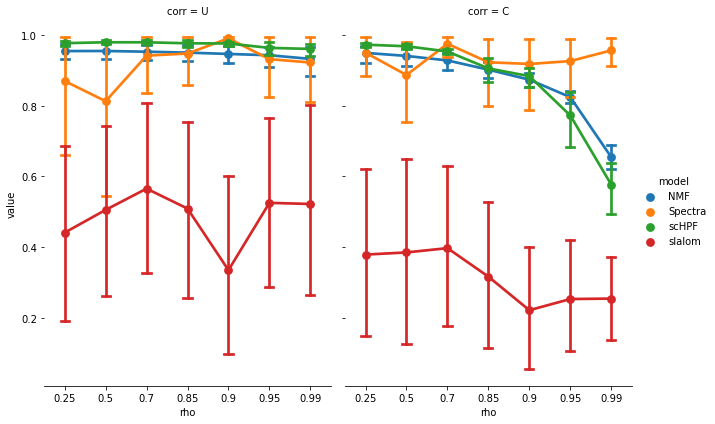

In [38]:
g = sns.catplot(x="rho", y="value", hue="model", col="corr",
                capsize=.2,  height=6, aspect=.75,
                kind="point", data=results_df2)
g.despine(left=True)
plt.savefig("simulation_correlated_factors_N100.svg")